# Tesis

### Notas importantes

* Métricas a considerar para la evaluación de desempeño:

    * Reward: ingresos - penalizaciones (es la métrica principal).

    * Cantidad de clientes atendidos.

    * Cantidad de pedidos tarde.

    * Penalty.

    * Costo (distancia recorrida).

    * En la métrica principal se espera al menos un 10% de mejora.

* Parámetros de instance:

    * Tamaño del área de servicio: de 5 a 8 km de arista, aproximadamente el diametro de la comuna de Santiago Centro
    
    * N° vehículos y de clientes: aproximadamente 50 clientes por vehículo es razonable

    * dod: mayor a 0.6. Se observa que a mayor dod, mejor reward se obtiene

    * t_max: 7 horas

    * t_service: 7 a 10 min

    * t_window: 30 min

    * categorías de clientes: podrían ser 3

    * penalty factor: entre 10 y 15 parece adecuado. 15 es un penalty donde al atrasarse 15 min ya se pierde al cliente

    * t_delta: entre 5 y 10 min parece adecuado. Entre mayor es el t_delta, menos decisiones se toman por lo que el algoritmo se ejecuta más rápido

    * velocidad: 35 km/h +- 5 km/h es adecuado en el contexto urbano

    * puntos de espera: 4 puntos de espera es razonable

### Descripción del modelo

**Instancia:**

* Se tiene un área de servicio donde un set de varios vehículos parten y terminan en un depósito. Los clientes realizan pedidos hasta un t_max.

* Los vehículos (con capacidad y autonomía ilimitada) tienen una velocidad determinística o estocástica durante cada tramo que recorren. Cada vez que recorre un tramo entre dos localizaciones se samplea una velocidad (con una distribución de probabilidad como lognormal si se está trabajando con el caso estocástico). Esto implica que la duración en los tiempos de viaje puede ser estocástica.

* Existen clientes tempranos (t_arrival = 0) que son conocidos al inicio del problema y clientes tardíos (t_arrival > 0) que van apareciendo dinámicamente durante el día, es decir, en instantes y ubicaciones aleatorias. Todos los clientes tienen un tiempo de servicio t_service conocido, fijo e igual para cada uno. Además, cada cliente tiene una ventana de tiempo de 30 min desde que se confirmó su pedido para ser atendido sin penalización. Por último, cada cliente pertenece a una categoría que indica el nivel de reward que entrega al ser atendido.

* Nota: todos los clientes tienen un id único para cada realización.

* Nota: en un contexto real deberían haber entre 3 y 4 camiones en un área equivalente a Santiago Centro y deberían haber entre 145 y 255 clientes. Además la velocidad del vehículo debería rondar los 30 o 35 km/h con una desviación estándar de 5 km/h.

**Estados:**

* Un estado tiene los siguientes elementos:

    * Plan de ruta de cada vehículo (que incluye la posición actual del vehículo en la posición 0 de la lista, y el depot en la posición final de la lista).

    * Un (posible) cliente aleatorio.
    
    * Tiempo t.

* En el estado inicial (t = 0) los vehículos se encuentran en el depot y el cliente aleatorio es uno de los clientes tempranos (t_arrival = 0).

* En el estado terminal los vehículos se encuentran en el depot, no quedan clientes por atender, y todos los clientes del día fueron vistos (confirmados o rechazados).
    
* Los puntos de decisión se dan en los momentos en que llega un nuevo cliente o bien luego de un intervalo de tiempo t_delta en el que no ha llegado ningún cliente.

**Acciones**

* Una acción en un punto de decisión incluye la confirmación o rechazo del cliente aleatorio y una decisión de movimiento; actualización del plan de ruta a cada vehículo.

* Las acciones posibles para cada vehículo se determinan considerando las siguientes condiciones:

    * Si se superó el t_max del problema o bien quedan clientes por atender en la ruta, se puede continuar con el mismo plan de ruta.

    * Si no quedan clientes por atender en el plan de ruta y no se ha alcanzado t_max se puede enviar el vehículo a cualquier idlepoint sólo mientras éste se encuentre suficientemente lejos del vehículo (a más de 1/3 de la diagonal del área de servicio). Lo anterior se justifica en que si un vehículo se encuentra en un cliente muy cercano a un idlepoint, no se espera que mover el vehículo tan poco tenga un aporte significativo al reward. Además, esta medida permite disminuir el espacio de acciones.

    * Si el vehículo se encuentra en el depot, en un idlepoint o en un cliente, no tiene clientes por atender en su plan de ruta y no se ha superado t_max, se puede esperar en la posición hasta el siguiente punto de decisión.

    * Si en el punto de decisión existe un cliente aleatorio, se puede considerar su inserción en alguna de las 5 posiciones menos costosas (en términos de distancia) en el plan de ruta de alguno de los 3 vehículos más cercanos. Lo anterior se justifica en la necesidad de eliminar las acciones evidentemente malas para disminuir el espacio de acciones. Si la siguiente posición en la ruta es un idlepoint, éste se puede sacar de la ruta e insertar al cliente en su lugar.

    * Otras restricciones importantes: un cliente aleatorio sólo puede ser insertado en un vehículo. Todos los clientes tempranos (t_arrival = 0) deben ser atendidos, es decir, no existe la opción de rechazar a dichos clientes.

    * Nota: eventualmente si el espacio de acciones sigue siendo demasiado grande se podrían quitar los idlepoints.

**Estado-Accion:**

* Un objeto State-Action tiene los siguientes elementos (dado que pertenece a una clase hija de State): 

    * Plan de ruta de cada vehículo (que incluye la posición actual del vehículo en la posición 0 de la lista, y el depot en la posición final de la lista).

    * Un (posible) cliente aleatorio.
    
    * Tiempo t.

* Este objeto permite calcular los valores asociados a tomar una acción en cierto estado. Para esto se extrae de este elemento el vector de features.

* Nota: Si la diferencia de la escala entre los features demasiado alta se deberían estandarizar los features para que no afecte la regresión.

**Transición y Rewards:**

* La transición entre dos estados está dada por la llegada de un cliente aleatorio o bien por el paso de t_delta minutos sin la llegada de un cliente. En este intervalo de tiempo se ejecuta el plan de ruta de cada vehículo, que considera para cada tramo entre localizaciones el sampleo de una velocidad que es aleatoria.

* En la transición a otro estado se percibe un reward que está compuesto por la ganancia asociada a aceptar al cliente menos la penalización por los clientes que fueron o están siendo atendidos fuera de su ventana de tiempo.

* La penalización por minuto de atraso está dada por una función monótona no decreciente (ej. logaritmo).

**Algoritmos para la solución del MDP:**

1. Política miope 1 (cheapest insertion algorithm):

    * Para este algoritmo el take action considera lo siguiente: siempre aceptar al cliente aleatorio e insertarlo en alguna posición dentro de cualquiera de los planes de ruta de forma que el aumento en distancia total por recorrer sea el mínimo.

    * Nota con respecto al take action anterior: se observa que se tiende a asignar a todos los clientes al vehículo que ya tiene clientes en la ruta (habitualmente al primer vehículo). Esto se genera porque en la mayoría de los casos es menos costoso asignar el cliente al vehículo que ya tiene una ruta con clientes a mover un vehículo del depot para atenderlo. Esto afecta claramente el reward obtenido por el algoritmo, dado que el vehículo que concentra todos los pedidos tiende a llegar tarde.

    * Para solucionar lo anterior se consideró un take action alternativo similar: siempre aceptar al cliente aleatorio e insertarlo en alguna posición dentro del plan de ruta del vehículo más cercano de forma que el aumento en distancia total por recorrer sea el mínimo. Esto permite que la asignación de clientes sea más balanceada entre los vehículos, lo que mejora el reward del algoritmo.

    * Nota importante con respecto a los take action: se observa que con cualquiera de los take action anteriores los clientes tempranos (t_arrival = 0) tienden a asignarse a sólo un vehículo. Esto se produce porque el algoritmo los asigna siempre a un mismo vehículo. Cuando las instancias son muy grandes y la cantidad de clientes tempranos es alta esto es un problema debido a que se colapsa uno de los vehículos, mientras los demás se encuentran relativamente inutilizados. Eventualmente se debería considerar alguna medida que balancee la asignación de estos clientes; por ejemplo, si al insertar en cierto vehículo se está generando un atraso, se intenta insertar en el siguiente vehículo.

    * Nota extra: queda por verificar con Gasco cuál es la política que aplican.

2. Política inteligente (AVI algorithm):

    * Este es un algoritmo de AVI que utiliza una aproximación lineal de la value function. Las decisiones se toman con una política inicialmente arbitraria que se va actualizando a medida que el algoritmo aprende y actualiza la value function. Para hacer el aprendizaje más eficaz durante el entrenamiento se utiliza una estrategia e-greedy para la toma de decisiones para promover la exploración de acciones buenas. La estrategia e-greedy considera la elección aleatoria entre la 2da, 3ra, 4ta y 5ta mejor opción en cierto punto de decisión.
    
    * El take action del algoritmo considera lo siguiente: para cierto par state-action se aplica la política de decisión actual, que selecciona la acción que maximiza el value-to-go calculado con la aproximación lineal de la value function. Esto permite iterativamente actualizar los parámetros de la value function e ir mejorando la toma de decisiones hasta obtener una política de decisión que converge a la óptima.

    * Value Function Approximation: la actualización de los parámetros se realiza en base a RLS propuesto por powell 2011 (p. 350). Eventualmente se podría considerar la opción de utilizar la versión de RLS para datos no estacionarios. Esto se explica porque la política se actualiza iterativamente, por lo que los values no son estacionarios (el promedio converge a cierto valor según la política).

    * Los features que se están utilizando para la aproximación lineal son los siguientes:
        * Tiempo restante.
        * Por vehículo: largo (en número de localizaciones) del plan de ruta.
        * Desviación del largo (en número de localizaciones) de los planes de ruta.
        * Por vehículo: raíz del largo (en número de localizaciones) del plan de ruta.
        * Desviación de la raíz del largo (en número de localizaciones) del plan de ruta.
        * Por vehículo: razón entre tiempo restante y número de localizaciones en el plan de ruta.
        * Desviación de razón entre tiempo restante y número de localizaciones en el plan de ruta.
        * Por vehículo: largo (en distancia) del plan de ruta.
        * Desviación del largo (en distancia) de los planes de ruta.
        * Por vehículo: tiempo estimado para completar la ruta.
        * Por vehículo: razón entre el tiempo estimado para completar la ruta y el largo (en número de localizaciones) del plan de ruta.
        * Por vehículo: producto entre el tiempo estimado para completar la ruta y el tiempo que queda.
        * Por vehículo: distancia entre los vehículos.
        * Distancia promedio entre todos las localizaciones que están actualmente en los planes de ruta.
        * Desviación de la distancia entre todos las localizaciones que están actualmente en los planes de ruta.
        * Por vehículo: distancia máxima entre dos puntos del plan de ruta.
        * Por vehículo: cuadrado de la distancia máxima entre dos puntos del plan de ruta.
        * Razón entre clientes que han sido confirmados y clientes vistos.
        * Por vehículo: factor de ocupación, entendida como razón entre clientes en el plan de ruta y clientes confirmados.
        * Desviación de los factores de ocupación de los vehículos.
        * Por vehículo: atraso promedio en el plan de ruta.

    * Nota: para calcular el Mean Squared Value Error, como se menciona en Sutton (p. 199), se requiere una distribución que indique la importancia para cada estado, con la finalidad de tener una mejor aproximación en los estados más importantes. Estaba pensando que todos los estados son igual de importantes entonces sería una distribución u(s) uniforme. En la p. 234 menciona que podría darle más importancia a los pares state-action donde se tomen acciones greedy o casi greedy porque hay acciones que son claramente más malas. 

    * Nota: eventualmente se podría considerar realizar importance sampling (Sutton p. 103)

    * Nota: El algoritmo del código está basado en el algoritmo que plantea Sutton en la sección 5.4, p. 104 (On policy first visit MC control for e-soft policies), utilizando RLS según los planteado por Powell en la sección 9.3.1 p. 350.

3. Política miope 2 (cluster algorithm):

    * Este algoritmo considera la clusterización del área de servicio en zonas fijas donde existe un grupo de vehículos asignado exclusivamente a cada zona.

    * Para este algoritmo el take action considera los siguiente: siempre aceptar al cliente aleatorio y, dependiendo de su zona, insertarlo con cheapest insertion (en términos de distancia recorrida) en alguna posición dentro de cualquiera de los planes de ruta de alguno de los vehículos asignados a su zona.

DUDAS: 

* En sutton p.91 dice lo siguiente q no lo entiendo: That is, the return after taking an action in one state depends on the actions taken in later states in the same episode.Because all the action selections are undergoing learning, the problem becomes nonstationary from the point of view of the earlier state.

* ecuación 3.17 p. 85 pdf sutton no debería tener un q* en vez de un v* dentro de la ecuación

* En nuestro problema sería posible computar una matriz de transición exacta a priori

___

### Importación de librerías

In [353]:
# librerías generales
import numpy as np
import copy
import random
import itertools
from math import log, factorial
import heapq

# librerías para graficar y animar
import matplotlib.pyplot as plt
import seaborn as sns

# librería para entrenar una regresión lineal
from sklearn.linear_model import Ridge

# librería para guardar los resultados
import pickle

### Funciones Auxiliares

In [354]:
def euclideanDistance(loc_list):

    '''
    Descripción:

        * Función auxiliar para medir la distancia euclideana de una secuencia de localizaciones del área de servicio. Por ejemplo, para una secuencia [o1, o2, o3], entrega 
        la distancia euclideana entre o1 y o2 + la distancia euclideana entre o2 y o3. Si se entregan dos localizaciones, se mide la distancia sólo entre los dos objetos.

    Parámetros:

        * loc_list: secuencia de localizaciones (objetos con atributo posición) 

    Return:

        * distance: distancia euclideana entre las localizaciones entregadas.
    '''

    # crear un array de coordenadas
    coord = np.array([loc.pos for loc in loc_list])

    # calcular la distancia total a lo largo de la secuencia de objetos
    delta = coord[1:] - coord[:-1]
    distances = np.hypot(delta[:, 0], delta[:, 1])
    total_distance = np.sum(distances)

    return total_distance

def sampleVel(instance):

    '''
    Descripción:

        * Función auxiliar para samplear la velocidad de un vehículo en un tramo (según el tipo de instancia puede ser determinista o estocástica).

    Parámetros:

        * intance: objeto de la clase Instance.

    Return:

        * vel: velocidad generada para el vehículo en el tramo.
    '''

    if instance.stoc_travel_time:
        mean = log(instance.vel_mean ** 2 / (instance.vel_mean ** 2 + instance.vel_std ** 2) ** (1/2))
        std = (log(1 + (instance.vel_std ** 2 / instance.vel_mean ** 2))) ** (1/2)
        vel = round(random.lognormvariate(mean, std), 2)
    else:
        vel = instance.vel_mean

    return vel


def mean_absolute_percentage_error(values_observed, values_predicted):

    '''
    Descripción:

        * Función auxiliar para calcular el error absoluto porcentual medio.

    Parámetros:

        * values_observed: secuencia con los valores observados (True).
        * values_predicted: secuencia con los valores predichos.

    Return:

        * mape: mean absolute percentage error.
    '''

    ape = [abs(value_observed - value_predicted) / max(1, abs(value_observed)) for value_observed, value_predicted in zip(values_observed, values_predicted)]
    mape = np.mean(ape)

    return mape

def mean_squared_error(values_observed, values_predicted):

    '''
    Descripción:

        * Función auxiliar para calcular el error cuadrático medio.

    Parámetros:

        * values_observed: secuencia con los valores observados (True).
        * values_predicted: secuencia con los valores predichos.

    Return:

        * mse: mean squared error.
    '''

    se = [(value_observed - value_predicted) ** 2 for value_observed, value_predicted in zip(values_observed, values_predicted)]
    mse = np.mean(se)
    
    return mse

### Clase Location

In [355]:
class Location:

    '''
    Descripción:

        * Clase para cualquier punto del área de servicio que no es depot, customer o idlepoint.

    Atributos:

        * id: 'Service Area'.
        * pos: coordenadas de posición.
        * t_start_serving: tiempo en que el vehículo llega a la posición.
        * t_leave: tiempo en que el vehículo deja la posición.
    '''

    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        self.id = 'Service Area'
        self.pos = None
        self.t_start_serving = None
        self.t_leave = None

### Clase Depot

In [356]:
class Depot:

    '''
    Descripción:

        * Clase para puntos del área de servicio que son depot.

    Atributos:

        * id: 'Depot'.
        * pos: coordenadas de posición.
        * t_start_serving: tiempo en que el vehículo llega a la posición.
        * t_leave: tiempo en que el vehículo deja la posición.
    '''

    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        self.id = 'Depot'
        self.pos = None
        self.t_start_serving = None
        self.t_leave = None

### Clase IdlePoint

In [357]:
class IdlePoint:

    '''
    Descripción:

        * Clase para puntos del área de servicio que son depot.

    Atributos:

        * id: id único para el idlepoint.
        * pos: coordenadas de posición.
        * t_start_serving: tiempo en que el vehículo llega a la posición.
        * t_leave: tiempo en que el vehículo deja la posición.
    '''
    
    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        self.id = None
        self.pos = None
        self.t_start_serving = None
        self.t_leave = None

### Clase Customer

In [358]:
class Customer:

    '''
    Descripción:

        * Clase que genera objetos customer.

    Atributos:

        * id: id único para el objeto customer en la realización.
        * pos: coordenadas de posición.
        * t_arrival: tiempo en que aparece el cliente.
        * category: valor numérico que representa el nivel de importancia del cliente (debería ser igual o mayor a 1).
        * t_confirmed: si se confirma el cliente este atributo indica el instante en que se confirmó.
        * t_start_serving: si se confirma el cliente este atributo indica el instante en que se comenzó a atender.
        * t_leave: si se confirma el cliente este atributo indica el instante en que se dejó su posición.
        * status: puede ser 'not seen', 'confirmed' o 'rejected'.
        * penalty: indica la penalización acumulada que se ha generado por atender al cliente fuera de su ventana de tiempo.
    '''

    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        self.id = None
        self.pos = None
        self.t_arrival = None
        self.category = None
        self.t_confirmed = None
        self.t_start_serving = None
        self.t_leave = None
        self.status = None
        self.penalty = None

### Clase Vehicle

In [359]:
class Vehicle:

    '''
    Descripción:

        * Clase que genera objetos vehicle.

    Atributos:

        * id: id único para el objeto vehicle.
        * route: lista que representa el plan de ruta del vehículo. El primer objeto de la lista indica la posición actual del vehículo, mientras que el objeto final de la lista es el depot. 
    '''

    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        self.id = None
        self.route = None

### Clase Instance

In [360]:
class Instance:

    '''
    Descripción:

        * Clase que genera la estructura básica del VRP a resolver y contiene los parámetros de la simulación.

    Atributos:

        * A_x: tamaño (en km) en la dirección x del área de servicio.
        * A_y: tamaño (en km) en la dirección y del área de servicio.
        * n_vehicles: n° de vehículos.
        * n_cust_range: rango del número de clientes.
        * dod: grado de dinamismo (degree of dinamism) del problema. Entendido como la proporción: Clientes tardíos / Clientes totales.
        * t_max: límite de tiempo (en min) para la llegada de pedidos.
        * t_service: tiempo de servicio (en min) para los clientes.
        * t_window: ventana de tiempo (en min) para la atención satisfactoria del cliente.
        * cust_categories: posibles categorías de cliente.
        * penalty_factor: factor de penalización por atención fuera de ventana de tiempo.
        * t_delta: tiempo máximo (en min) entre puntos de decisión. Si no llega un cliente en t_delta minutos se transita a un nuevo punto de decisión.
        * vel_mean: velocidad promedio de los vehículos (en km/min).
        * vel_std: desviación estándar de la velocidad de los vehículos (en km/min).
        * idle_points_pos: coordenadas de los puntos de espera.
        * stoc_travel_time: booleano que indica si se trata de un problema con tiempos de viaje estocásticos (True) o determinísticos (False).

        * self.depot: objeto de la clase Depot que indica donde comienzan y terminan el día los vehículos.
        * vehicles: lista de objetos vehicles.
        * idle_points: lista de objetos idlepoint.
    '''

    def __init__(self, A_x, A_y, n_vehicles, n_cust_range, dod, t_max, t_service, t_window, cust_categories, penalty_factor, t_delta, vel_mean, vel_std, idle_points_pos, stoc_travel_time=True):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * A_x: tamaño en la dirección x del área de servicio. Se ingresa en km. 
            * A_y: tamaño en la dirección y del área de servicio. Se ingresa en km. 
            * n_vehicles: n° de vehículos.
            * n_cust_range: lista que contiene una cota inferior y superior para el número de clientes.
            * dod: número entre 0 y 1 que indica el grado de dinamismo.
            * t_max: límite de tiempo para la llegada de pedidos. Se ingresa en horas.
            * t_service: tiempo de servicio para los clientes. Se ingresa en minutos.
            * t_window: ventana de tiempo para la atención satisfactoria del cliente. Se ingresa en minutos.
            * cust_categories: lista que contiene las posibles categorías de cliente. Las categorías son numéricas.
            * penalty_factor: factor de penalización por atención fuera de ventana de tiempo. Entre más cercano a 1 más fuerte la penalización. Un factor de 15 es adecuado.
            * t_delta: tiempo máximo entre puntos de decisión. Se ingresa en minutos.
            * vel_mean: velocidad promedio de los vehículos. Se ingresa en km/h.
            * vel_std: desviación estándar de la velocidad de los vehículos. Se ingresa en km/h.
            * idle_points_pos: lista que contiene tuplas con las coordenadas de los puntos de espera.
            * stoc_travel_time: True o False para tiempos de viaje estocásticos o determinísticos respectivamente.

        Return:

            * None.
        '''

        # se definen los atributos de la clase
        self.A_x = A_x
        self.A_y = A_y
        self.n_vehicles = n_vehicles
        self.n_cust_range = n_cust_range
        self.dod = dod
        self.t_max = t_max * 60
        self.t_service = t_service
        self.t_window = t_window
        self.cust_categories = cust_categories
        self.penalty_factor = penalty_factor
        self.t_delta = t_delta
        self.vel_mean = vel_mean / 60
        self.vel_std = vel_std / 60
        self.idle_points_pos = idle_points_pos
        self.stoc_travel_time = stoc_travel_time

        # se crea el depot
        self.depot = Depot()
        self.depot.pos = (self.A_x/2, self.A_y/2)

        # se crean los vehículos
        self.vehicles = []
        for i in range(self.n_vehicles):
            vehicle = Vehicle()
            vehicle.id = 'v' + str(i)
            self.vehicles.append(vehicle)
            
        # se crean los idle points
        self.idle_points = []
        for i in range(len(self.idle_points_pos)):
            idle_point = IdlePoint()
            idle_point.id = 'i' + str(i)
            idle_point.pos = self.idle_points_pos[i]
            self.idle_points.append(idle_point)

### Clase State

In [361]:
class State:

    '''
    Descripción:

        * Clase que genera objetos state. Estos objetos representan los estados que se generan en el sistema con la llegada de un cliente o con el paso de un tiempo determinado.

    Atributos:

        * vehicles: lista de los vehículos generados con Instance. Permite acceder al plan de ruta de los vehículos.
        * random_cust: objeto customer que corresponde al cliente que llega aleatoriamente entre un estado y otro.
        * t: instante de tiempo (en min) actual del episodio.
    '''

    def __init__(self, instance):

        '''
        Descripción:

            * Método constructor de la clase State.

        Parámetros:

            * instance: objeto de la clase Instance.

        Return:

            * None
        '''

        self.vehicles = instance.vehicles
        self.random_cust = None
        self.t = 0


    def initialState(self, realization, instance):

        '''
        Descripción:

            * Método que define el estado inicial del problema.

        Parámetros:

            * realization: lista de clientes de una realización aleatoria.
            * instance: objeto de la clase Instance.

        Return:

            * None
        '''

        # ningun cliente ha sido visto, por ende, su status es 'None', su penalty actual es 0 y no hay tiempos de inicio y fin de servicio aun
        for cust in realization:
            cust.t_confirmed = None 
            cust.t_start_serving = None
            cust.t_leave = None
            cust.status = None
            cust.penalty = 0

        # ningun idlepoint ha sido visitado por lo que no hay tiempos de inicio y final de servicio
        for idlepoint in instance.idle_points:
            idlepoint.t_start_serving = None
            idlepoint.t_leave = None

        # el depot tiene tiempo de inicio y fin de servicio igual a 0 porque es la posición inicial
            instance.depot.t_start_serving = 0
            instance.depot.t_leave = 0

        # la ruta inicial de cada vehículo sólo contiene el depot como posición inicial y final
        for vehicle in self.vehicles:
            vehicle.route = [instance.depot, instance.depot]

        # el primer random customer es el primer cliente que tiene t_arrival = 0
        for cust in realization:
            if cust.t_arrival == 0:
                self.random_cust = cust
                break

        # tiempo inicial del problema
        self.t = 0


    def isTerminalState(self, instance):

        '''
        Descripción:

            * Método que permite identificar un estado terminal.

        Parámetros:

            * instance: objeto de la clase Instance.

        Return:

            * True o False dependiendo de si el estado es terminal o no.
        '''

        # si todos los vehículos tienen el depot como única localización en el plan de ruta entonces es el estado terminal
        for vehicle in self.vehicles:
            if vehicle.route != [instance.depot]:
                return False

        return True

### Clase StateAction

In [362]:
class StateAction(State):

    '''
    Descripción:

        * Clase que genera objetos state-action, que corresponde a un estado luego de haber aplicado una acción. Sobre estos objetos se calcula el value-to-go.

    Atributos:

        * vehicles: lista de los vehículos generados con Instance. Permite acceder al plan de ruta de los vehiculos.
        * random_cust: objeto customer que corresponde al cliente que llega aleatoriamente.
        * t: instante de tiempo (en min) actual del episodio.
    '''
    
    def __init__(self, state, action):

        '''
        Descripción:

            * Método constructor de la clase StateAction.

        Parámetros:

            * state: objeto de la clase State.
            * action: lista de vehículos que contienen sus respectivos planes de ruta.

        Return:

            * None
        '''

        # se copian los parámetros de entrada
        state_copy = copy.copy(state)
        action_copy = copy.copy(action)

        # la clase tiene los mismos atributos que el objeto state que toma como parámetro
        self.vehicles = [vehicle for vehicle in state_copy.vehicles]
        self.random_cust = state_copy.random_cust
        self.t = state_copy.t

        # cambia la ruta de cada vehículo según la acción
        for vehicle, route in zip(self.vehicles, action_copy):
            vehicle.route = route

        # se cambia el status de random_cust a confirmed o a rejected dependiendo si se insertó o no
        if self.random_cust is not None:
            self.random_cust.status = 'rejected'
            for route in action_copy:
                if self.random_cust in route:
                    self.random_cust.status = 'confirmed'
                    self.random_cust.t_confirmed = self.t
                    break

                
    def getFeatures(self, realization, instance):

        '''
        Descripción:

            * Método para obtener características del objeto state.

        Parámetros:

            * realization: lista de clientes de una realización aleatoria.
            * instance: objeto de la clase Instance.

        Return:

            * features: lista que representa un vector de características del objeto state.
        '''

        # # feature constante
        # c = [1]

        # # tiempo restante de pedidos
        # t_left = [instance.t_max - self.t]

        # # por vehículo: largo (en número de localizaciones) del plan de ruta
        # n_cust_route = [len(vehicle.route) for vehicle in self.vehicles]

        # # desviación del largo (en número de localizaciones) del planes de ruta
        # std_n_cust_route = [np.std(n_cust_route)]

        # # por vehículo: raiz del largo (en número de localizaciones) del plan de ruta
        # sqrt_n_cust_route = [np.sqrt(len(vehicle.route)) for vehicle in self.vehicles]

        # # desviación de la raiz del largo (en número de localizaciones) del plan de ruta
        # std_sqrt_n_cust_route = [np.std(sqrt_n_cust_route)]

        # # por vehículo: razón entre tiempo restante y número de localizaciones en el plan de ruta (t_left / n_cust_route)
        # t_n_cust_route = [t_left[0] / len(vehicle.route) for vehicle in self.vehicles]

        # # desviación de razón entre tiempo restante y número de localizaciones en el plan de ruta
        # std_t_n_cust_route = [np.std(t_n_cust_route)]

        # # por vehículo: largo (en distancia) del plan de ruta
        # route_len = [sum(euclideanDistance([vehicle.route[i], vehicle.route[i+1]]) for i in range(len(vehicle.route)-1)) for vehicle in self.vehicles if len(vehicle.route) > 1]

        # # desviación del largo (en distancia) de los planes de ruta
        # std_route_len = [np.std(route_len)]

        # # por vehículo: tiempo estimado para completar la ruta (route_len / vel_mean)
        # t_fin_route = [length / instance.vel_mean for length in route_len]

        # # por vehículo: razón entre el tiempo estimado para completar la ruta y el largo (en número de localizaciones) del plan de ruta (t_fin_route / n_cust_route)
        # t_fin_route_per_cust = [t_fin / n_cust for t_fin, n_cust in zip(t_fin_route, n_cust_route)]

        # # por vehículo: producto entre el tiempo estimado para completar la ruta y el tiempo que queda
        # t_fin_route_t_left = [t_fin * t_left[0] for t_fin in t_fin_route]

        # # por vehículo: distancia entre los vehículos (tiene tamaño: n_vehiculos! / (2 * (n_vehículos - 2)!))
        # vehicles_dist = []
        # for vehicle_pair in itertools.combinations(self.vehicles, 2):
        #     dist = euclideanDistance([vehicle_pair[0].route[0], vehicle_pair[1].route[0]])
        #     vehicles_dist.append(dist)

        # # distancia promedio entre todos las localizaciones que están actualmente en los planes de ruta
        # all_loc = [loc for vehicle in self.vehicles for loc in vehicle.route]
        # loc_dist = [euclideanDistance([a, b]) for a, b in itertools.combinations(all_loc, 2)]
        # mean_loc_dist = [np.mean(loc_dist)]

        # # desviación de la distancia entre todos las localizaciones que están actualmente en los planes de ruta
        # std_loc_dist = [np.std(loc_dist)]

        # # por vehículo: distancia máxima entre dos puntos del plan de ruta. Esto indica una medida de área que abarca cada vehículo
        # route_max_dist = []
        # for vehicle in self.vehicles:
        #     max_dist = 0
        #     for i, j in itertools.combinations(range(len(vehicle.route)), 2):
        #         dist = euclideanDistance([vehicle.route[i], vehicle.route[j]])
        #         if dist > max_dist:
        #             max_dist = dist
        #     route_max_dist.append(max_dist)
        
        # # por vehículo: cuadrado de la distancia máxima entre dos puntos del plan de ruta. Esto indica una medida de área que abarca cada vehículo
        # squared_route_max_dist = [max_dist ** 2 for max_dist in route_max_dist]

        # # razón entre clientes que han sido confirmados y clientes vistos (n_clients_confirmed / n_clients_seen)
        # n_confirmed_cust = np.sum([cust.status == 'confirmed' for cust in realization])
        # n_seen_cust = np.sum([cust.status is not None for cust in realization])
        # p_confirmed_cust = [n_confirmed_cust / n_seen_cust]

        # # por vehículo: factor de ocupación (clientes en el plan de ruta / clientes confirmados)
        # vehicles_of = [np.sum([isinstance(loc, Customer) for loc in vehicle.route]) / n_confirmed_cust for vehicle in self.vehicles]
        
        # # desviación de los factores de ocupación de los vehículos
        # std_vehicles_of = [np.std(vehicles_of)]

        # # # por vehículo: atraso promedio en el plan de ruta
        # # mean_delay_vehicle = []
        # # for vehicle in self.vehicles:
        # #     delays = []
        # #     for cust in vehicle.route:
        # #         if cust.t_start_serving is None:
        # #             if isinstance(cust, Customer) and self.t >= cust.t_confirmed + instance.t_window:
        # #                 extra_time = self.t - (cust.t_confirmed + instance.t_window)
        # #                 delays.append(extra_time)
        # #             else:
        # #                 delays.append(0)
        # #         elif cust.t_start_serving is not None:
        # #             if isinstance(cust, Customer) and cust.t_start_serving >= cust.t_confirmed + instance.t_window:
        # #                 extra_time = cust.t_start_serving - (cust.t_confirmed + instance.t_window)
        # #                 delays.append(extra_time)
        # #             else:
        # #                 delays.append(0)
        # #     mean_delay_vehicle.append(np.mean(delays))

        # # # FEATURES PARA AGREGAR CUANDO EL SE INCLUYAN INSTANCIAS CON CATEGORÍAS DE CLIENTES
        # # # categoría promedio de los clientes confirmados que aún no se han atendido
        # # mean_category = [np.mean([cust.category for cust in realization if cust.status != 'not seen'])]
        # # # desviación estandar de la categoría de los clientes confirmados que aun no se han atendido
        # # std_category = [np.std([cust.category for cust in realization if cust.status != 'not seen'])]   

        # # se crea el vector de features
        # features = np.array([c + 
        #                      t_left + 
        #                      n_cust_route + 
        #                      std_n_cust_route + 
        #                      sqrt_n_cust_route + 
        #                      std_sqrt_n_cust_route + 
        #                      t_n_cust_route + 
        #                      std_t_n_cust_route + 
        #                      route_len + 
        #                      std_route_len +
        #                      t_fin_route + 
        #                      t_fin_route_per_cust +
        #                      t_fin_route_t_left +
        #                      vehicles_dist + 
        #                      mean_loc_dist + 
        #                      std_loc_dist + 
        #                      route_max_dist + 
        #                      squared_route_max_dist +
        #                      p_confirmed_cust + 
        #                      vehicles_of + 
        #                      std_vehicles_of]).T

        # return features

        ##################################################

        # # feature constante
        # c = [1]

        # # tiempo restante de pedidos
        # t_left = [instance.t_max - self.t]

        # # promedio del largo (en número de localizaciones) de los planes de ruta
        # n_cust_route = [len(vehicle.route) for vehicle in self.vehicles]
        # mean_n_cust_route = [np.mean(n_cust_route)]

        # # desviación del largo (en número de localizaciones) de los planes de ruta
        # std_n_cust_route = [np.std(n_cust_route)]

        # # promedio de la raiz cuadrada del largo (en número de localizaciones) de los planes de ruta
        # sqrt_n_cust_route = [np.sqrt(len(vehicle.route)) for vehicle in self.vehicles]
        # mean_sqrt_n_cust_route = [np.mean(sqrt_n_cust_route)]

        # # desviación de la raiz del largo (en número de localizaciones) de los planes de ruta
        # std_sqrt_n_cust_route = [np.std(sqrt_n_cust_route)]

        # # razón entre tiempo restante y número de localizaciones promedio en los planes de ruta (t_left / mean_n_cust_route)
        # t_n_cust_route = [t_left[0] / mean_n_cust_route[0]]

        # # promedio del largo (en distancia) del plan de ruta
        # route_len = [sum(euclideanDistance([vehicle.route[i], vehicle.route[i+1]]) for i in range(len(vehicle.route)-1)) for vehicle in self.vehicles if len(vehicle.route) > 1]
        # mean_route_len = [np.mean(route_len)]

        # # desviación del largo (en distancia) de los planes de ruta
        # std_route_len = [np.std(route_len)]

        # # promedio del tiempo estimado para completar la ruta (route_len / vel_mean)
        # t_fin_route = [length / instance.vel_mean for length in route_len]
        # mean_t_fin_route = [np.mean(t_fin_route)]

        # # razón entre el promedio del tiempo estimado para completar la ruta y el promedio del largo (en número de localizaciones) del plan de ruta (mean_t_fin_route / mean_n_cust_route)
        # t_fin_route_per_cust = [mean_t_fin_route[0] / mean_n_cust_route[0]]

        # # producto entre el promedio del tiempo estimado para completar la ruta y el tiempo que queda
        # t_fin_route_t_left = [mean_t_fin_route[0] * t_left[0]]

        # # promedio de la distancia entre los vehículos (tiene tamaño: n_vehiculos! / (2 * (n_vehículos - 2)!))
        # vehicles_dist = []
        # for vehicle_pair in itertools.combinations(self.vehicles, 2):
        #     dist = euclideanDistance([vehicle_pair[0].route[0], vehicle_pair[1].route[0]])
        #     vehicles_dist.append(dist)
        # mean_vehicles_dist = [np.mean(vehicles_dist)]

        # # distancia promedio entre todos las localizaciones que están actualmente en los planes de ruta
        # all_loc = [loc for vehicle in self.vehicles for loc in vehicle.route]
        # loc_dist = [euclideanDistance([a, b]) for a, b in itertools.combinations(all_loc, 2)]
        # mean_loc_dist = [np.mean(loc_dist)]

        # # desviación de la distancia entre todos las localizaciones que están actualmente en los planes de ruta
        # std_loc_dist = [np.std(loc_dist)]

        # # distancia máxima entre dos puntos que estén en algun plan de ruta. Esto indica una medida de área
        # max_dist = 0
        # for vehicle in self.vehicles:
        #     for i, j in itertools.combinations(range(len(vehicle.route)), 2):
        #         dist = euclideanDistance([vehicle.route[i], vehicle.route[j]])
        #         if dist > max_dist:
        #             max_dist = dist
        # route_max_dist = [max_dist]
        
        # # cuadrado de la distancia máxima entre dos puntos. Esto indica una medida de área
        # squared_route_max_dist = [route_max_dist[0] ** 2]

        # # razón entre clientes que han sido confirmados y clientes vistos (n_clients_confirmed / n_clients_seen)
        # n_confirmed_cust = np.sum([cust.status == 'confirmed' for cust in realization])
        # n_seen_cust = np.sum([cust.status is not None for cust in realization])
        # p_confirmed_cust = [n_confirmed_cust / n_seen_cust]

        # # promedio del factor de ocupación (clientes en el plan de ruta / clientes confirmados)
        # vehicles_of = [np.sum([isinstance(loc, Customer) for loc in vehicle.route]) / n_confirmed_cust for vehicle in self.vehicles]
        # mean_vehicles_of = [np.mean(vehicles_of)]
        
        # # desviación de los factores de ocupación de los vehículos
        # std_vehicles_of = [np.std(vehicles_of)]

        # # promedio de atraso en el sistema
        # mean_delay_vehicle = []
        # for vehicle in self.vehicles:
        #     delays = []
        #     for cust in vehicle.route:
        #         if cust.t_start_serving is None:
        #             if isinstance(cust, Customer) and self.t >= cust.t_confirmed + instance.t_window:
        #                 extra_time = self.t - (cust.t_confirmed + instance.t_window)
        #                 delays.append(extra_time)
        #             else:
        #                 delays.append(0)
        #         elif cust.t_start_serving is not None:
        #             if isinstance(cust, Customer) and cust.t_start_serving >= cust.t_confirmed + instance.t_window:
        #                 extra_time = cust.t_start_serving - (cust.t_confirmed + instance.t_window)
        #                 delays.append(extra_time)
        #             else:
        #                 delays.append(0)
        #     mean_delay_vehicle.append(np.mean(delays))
        # mean_delay_system = [np.mean(mean_delay_vehicle)]

        # # desviación del atraso de los vehículos
        # std_delay_system = [np.std(mean_delay_vehicle)]
        
        # # se crea el vector de features
        # features = np.array([c + 
        #                      t_left + 
        #                      mean_n_cust_route + 
        #                      std_n_cust_route + 
        #                      mean_sqrt_n_cust_route + 
        #                      std_sqrt_n_cust_route + 
        #                      t_n_cust_route + 
        #                      mean_route_len + 
        #                      std_route_len +
        #                      mean_t_fin_route + 
        #                      t_fin_route_per_cust +
        #                      t_fin_route_t_left +
        #                      mean_vehicles_dist + 
        #                      mean_loc_dist + 
        #                      std_loc_dist + 
        #                      route_max_dist + 
        #                      squared_route_max_dist +
        #                      p_confirmed_cust + 
        #                      mean_vehicles_of + 
        #                      std_vehicles_of +
        #                      mean_delay_system +
        #                      std_delay_system]).T

        # return features

        ##################################################

        # # feature constante
        # c = [1]

        # # tiempo restante de pedidos
        # t_left = [instance.t_max - self.t]

        # # promedio del largo (en número de localizaciones) de los planes de ruta
        # n_cust_route = [len(vehicle.route) for vehicle in self.vehicles]
        # mean_n_cust_route = [np.mean(n_cust_route)]

        # # promedio del largo (en distancia) del plan de ruta
        # route_len = [sum(euclideanDistance([vehicle.route[i], vehicle.route[i+1]]) for i in range(len(vehicle.route)-1)) for vehicle in self.vehicles if len(vehicle.route) > 1]
        # mean_route_len = [np.mean(route_len)]

        # # promedio del factor de ocupación (clientes en el plan de ruta / clientes confirmados)
        # n_confirmed_cust = np.sum([cust.status == 'confirmed' for cust in realization])
        # vehicles_of = [np.sum([isinstance(loc, Customer) for loc in vehicle.route]) / n_confirmed_cust for vehicle in self.vehicles]
        # mean_vehicles_of = [np.mean(vehicles_of)]

        # # promedio de atraso en el sistema
        # mean_delay_vehicle = []
        # for vehicle in self.vehicles:
        #     delays = []
        #     for cust in vehicle.route:
        #         if cust.t_start_serving is None:
        #             if isinstance(cust, Customer) and self.t >= cust.t_confirmed + instance.t_window:
        #                 extra_time = self.t - (cust.t_confirmed + instance.t_window)
        #                 delays.append(extra_time)
        #             else:
        #                 delays.append(0)
        #         elif cust.t_start_serving is not None:
        #             if isinstance(cust, Customer) and cust.t_start_serving >= cust.t_confirmed + instance.t_window:
        #                 extra_time = cust.t_start_serving - (cust.t_confirmed + instance.t_window)
        #                 delays.append(extra_time)
        #             else:
        #                 delays.append(0)
        #     mean_delay_vehicle.append(np.mean(delays))
        # mean_delay_system = [np.mean(mean_delay_vehicle)]
        
        # # se crea el vector de features
        # features = np.array([c + 
        #                      t_left + 
        #                      mean_n_cust_route +
        #                      mean_route_len +
        #                      mean_vehicles_of + 
        #                      mean_delay_system]).T

        # return features

        ##################################################

        # # feature constante
        # c = [1]

        # # tiempo restante de pedidos
        # t_left = [instance.t_max - self.t]

        # # inserción del cliente
        # insertion_binary = [0]
        # for vehicle in self.vehicles:
        #     if self.random_cust in vehicle.route:
        #         insertion_binary = [1]
        #         break

        # # se crea el vector de features
        # features = np.array([c + 
        #                      t_left + 
        #                      insertion_binary]).T

        # return features

        ###################################################

        # feature constante
        c = [1]

        # tiempo restante de pedidos
        t_left = [instance.t_max - self.t]

        # variable binaria para la inserción del cliente
        insertion_binary = [0]
        for vehicle in self.vehicles:
            if self.random_cust in vehicle.route:
                insertion_binary = [1]
                break

        # número de clientes por atender
        n_cust_pend = 0
        for vehicle in self.vehicles:
            n_cust_pend += sum(isinstance(cust, Customer) for cust in vehicle.route)
        n_cust_pend = [n_cust_pend]

        # # distancia máxima entre dos puntos que estén en algun plan de ruta. Esto indica una medida de área
        # max_dist = 0
        # for vehicle in self.vehicles:
        #     for i, j in itertools.combinations(range(len(vehicle.route)), 2):
        #         dist = euclideanDistance([vehicle.route[i], vehicle.route[j]])
        #         if dist > max_dist:
        #             max_dist = dist
        # route_max_dist = [max_dist]

        # distancia máxima entre dos puntos que estén en cada plan de ruta. Esto indica una medida de área
        route_max_dist = []
        for vehicle in self.vehicles:
            max_dist = 0
            for i, j in itertools.combinations(range(len(vehicle.route)), 2):
                dist = euclideanDistance([vehicle.route[i], vehicle.route[j]])
                if dist > max_dist:
                    max_dist = dist
            route_max_dist.append(max_dist)
        # std de la distancia máxima en los planes de ruta
        std_route_max_dist = [np.std(route_max_dist)]

        # promedio de atraso en el sistema
        mean_delay_vehicle = []
        for vehicle in self.vehicles:
            delays = []
            for cust in vehicle.route:
                if cust.t_start_serving is None:
                    if isinstance(cust, Customer) and self.t >= cust.t_confirmed + instance.t_window:
                        extra_time = self.t - (cust.t_confirmed + instance.t_window)
                        delays.append(extra_time)
                    else:
                        delays.append(0)
                elif cust.t_start_serving is not None:
                    if isinstance(cust, Customer) and cust.t_start_serving >= cust.t_confirmed + instance.t_window:
                        extra_time = cust.t_start_serving - (cust.t_confirmed + instance.t_window)
                        delays.append(extra_time)
                    else:
                        delays.append(0)
            mean_delay_vehicle.append(np.mean(delays))
        mean_delay_system = [np.mean(mean_delay_vehicle)]

        # promedio del factor de ocupación
        vehicles_of = [np.sum([isinstance(loc, Customer) for loc in vehicle.route]) / n_cust_pend[0] for vehicle in self.vehicles]
        std_vehicles_of = [np.std(vehicles_of)]

        # promedio del tiempo estimado para completar la ruta (route_len / vel_mean)
        route_len = [sum(euclideanDistance([vehicle.route[i], vehicle.route[i+1]]) for i in range(len(vehicle.route)-1)) for vehicle in self.vehicles if len(vehicle.route) > 1]
        t_fin_route = [length / instance.vel_mean for length in route_len]
        mean_t_fin_route = [np.mean(t_fin_route)]

        # se crea el vector de features
        features = np.array([c +
                             t_left +
                             insertion_binary +
                             n_cust_pend +
                             route_max_dist +
                             std_route_max_dist +
                             mean_delay_system +
                             vehicles_of +
                             std_vehicles_of +
                             mean_t_fin_route]).T

        return features

### Clase Process

In [363]:
class Process:

    '''
    Descripción:

        * Esta clase contiene la estructura del modelo; genera objetos que contienen el MDP.

    Atributos:

        * None.
    '''

    def __init__(self):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * None.

        Return:

            * None.
        '''
        
        pass
    

    def computeActions(self, state, instance):

        '''
        Descripción:

            * Método para determinar las acciones posibles en un estado.

        Parámetros:

            * state: objeto de la clase State.
            * instance: objeto de la clase Instance.

        Return:

            * actions: lista que contiene todas las acciones posibles para state.
        '''

        # Se definen los vehículos más cercanos al posible random_cust
        if state.random_cust is not None:
            distances = []
            for vehicle in state.vehicles:
                dist = euclideanDistance([vehicle.route[0], state.random_cust])
                distances.append((vehicle, dist))
            closest = heapq.nsmallest(3, distances, key=lambda x: x[1])
            closest_vehicles = [vehicle for vehicle, _ in closest]
            
        # se obtienen las acciones para cada vehículo
        actions_per_vehicle = []
        for vehicle in state.vehicles:
            actions_one_vehicle = []

            # 1. insertar cliente en alguna ruta de vehículos cercanos (y posiblemente eliminar idlepoint)
            if state.random_cust is not None and vehicle in closest_vehicles:
                # se calcula el largo de las diferentes rutas que se generan por las distintas inserciones
                routes_len = []
                # si el vehículo tiene como siguiente posición un idlepoint, este se puede eliminar y se inserta al cliente
                if isinstance(vehicle.route[1], IdlePoint):
                    route_copy = copy.copy(vehicle.route)
                    route_copy[1] = state.random_cust
                    length = euclideanDistance(route_copy)
                    routes_len.append((route_copy, length))
                # si no, se considera la inserción del cliente en cualquier punto de la ruta
                else:
                    for i in range(1, len(vehicle.route)):
                        route_copy = copy.copy(vehicle.route)
                        route_copy.insert(i, state.random_cust)
                        length = euclideanDistance(route_copy)
                        routes_len.append((route_copy, length))
                # sólo se consideran las 5 mejores inserciones como posibles acciones
                best_insertions = heapq.nsmallest(5, routes_len, key=lambda x: x[1])
                best_insertions_routes = [route for route, _ in best_insertions]
                for route in best_insertions_routes:
                    actions_one_vehicle.append(route)

            # # 2. ir a un idlepoint. Condiciones necesarias: no hay clientes por empezar a atender ni idlepoints en la ruta, y el idlepoint se encuentra los suficientmente lejos de la posición del vehículo
            # if not any(isinstance(loc, (Customer, IdlePoint)) for loc in vehicle.route[1:]):
            #     for idlepoint in instance.idle_points:
            #         dist = euclideanDistance([vehicle.route[0], idlepoint])
            #         min_dist_idlepoint = np.hypot(instance.A_x, instance.A_y) / 3
            #         if dist >= min_dist_idlepoint:
            #             route_copy = copy.copy(vehicle.route)
            #             route_copy.insert(1, idlepoint)
            #             actions_one_vehicle.append(route_copy)

            # 3. seguir con la ruta eliminando el idlepoint. Condiciones necesarias: vehicle.route[0] no es service area y vehicle.route[1] es idlepoint
            if not isinstance(vehicle.route[0], Location) and isinstance(vehicle.route[1], IdlePoint):
                route_copy = copy.copy(vehicle.route)
                route_copy.pop(1)
                actions_one_vehicle.append(route_copy)

            # 4. seguir con la ruta. Condiciones necesarias: vehicle.route no es del tipo ['service area', 'Depot'] porque no se puede esperar en "service area"
            if not (isinstance(vehicle.route[0], Location) and isinstance(vehicle.route[1], Depot)):
                actions_one_vehicle.append(vehicle.route)

            # se guardan las acciones del vehículo
            actions_per_vehicle.append(actions_one_vehicle)

        # se crean las acciones, donde por cada acción individual de un vehículo, los demás vehículos no toman acción de movimiento
        actions = []
        for i, actions_one_vehicle in enumerate(actions_per_vehicle):
            for route in actions_one_vehicle:
                action = [vehicle.route for vehicle in state.vehicles]
                if state.random_cust is None or state.random_cust in route or (state.random_cust not in route and state.random_cust.t_arrival != 0):
                    action[i] = route
                    actions.append(action)

        # se elimina la repetición de la accion donde todos los vehículos se mantienen con la misma ruta
        dic = {}
        for action in actions:
            key = str(action)
            dic[key] = action
        actions = list(dic.values())

        # ###
        # print(len(actions))
        # print('')
        # # print('random_cust', state.random_cust.id)
        # for action in actions:
        #     for route in action:
        #         print([loc.id for loc in route])
        # ###

        return actions


    def transition(self, state, action, realization, instance):

        '''
        Descripción:

            * Método que determina la transición aleatoria entre un estado y otro.

        Parámetros:

            * state: objeto de la clase State.
            * action: lista de vehículos que contienen sus respectivos planes de ruta.
            * realization: lista de clientes de una realización aleatoria.
            * instance: objeto de la clase Instance.

        Return:

            * state: estado actualizado luego de la transición. Corresponde a un objeto de la clase State.
            * reward: reward total (ganancias - penalizaciones) percibido en la transición.
        '''
                    
        # actualización del random customer
        random_cust_before_transition = state.random_cust
        state.random_cust = None
        for cust in realization:
            if state.t <= cust.t_arrival <= state.t + instance.t_delta and cust.status is None:
                state.random_cust = cust
                break

        # actualización del tiempo del estado: cuando llega un cliente o pasados t_delta minutos si no ha llegado ningun cliente
        t_before_transition = state.t
        if state.random_cust is None:
            state.t += instance.t_delta
            # si luego de t_delta sin llegada de clientes se supera el t_max, significa que se deben atender los clientes pendientes y volver al depot
            if state.t > instance.t_max:
                state.t = float('inf')
        else:
            state.t = state.random_cust.t_arrival

        # actualización del plan de ruta de cada vehículo
        for vehicle, route in zip(state.vehicles, action):

            # si se superó t_max y la ruta tiene un idlepoint por visitar, este se elimina de la ruta y se va directo al depot
            if state.t == float('inf'):
                if isinstance(route[1], IdlePoint):
                    route.remove(route[1])

            # print(f'transition for {vehicle.id} cuya accion fue:{[cust.id for cust in route]}')

            # cuando se supera el t_max se atienden los clientes restantes y se vuelve al depot, porque no llegan clientes después de t_max
            if state.t > instance.t_max:
                range_sup = len(route)
            # cuando aun no se supera t_max se llega sólo hasta el último cliente y se espera en esa posición, no se llega hasta el depot
            else:
                range_sup = len(route)-1
            
            # se itera sobre cada loc de la ruta
            for i in range(range_sup):
                # se samplea un velocidad para el tramo
                vel = sampleVel(instance)

                # print(f'iteración sobre el cliente {i} de la ruta, que es {route[i].id}')

                # si se está en el depot, el tiempo en que se deja la posición es t del estado previo a la transición
                if isinstance(route[i], Depot):
                    route[i].t_leave = t_before_transition

                # se define la variable time como el tiempo en que se deja la posición i
                time = route[i].t_leave

                # print(f'time (route[i].t_leave): {time}')

                # si time es menor a t y no es el último cliente de la ruta, se calcula la distancia entre la loc i e i+1
                if time < state.t and i != range_sup-1:
                    time += round(euclideanDistance([route[i], route[i+1]]) / vel, 1)

                    # print(f'tiempo en que se deja la pos {i} no supera el state.t')
                    # print(f'la iteración continua y se calcula distancia entre cliente {route[i].id} con pos {route[i].pos} y cliente {route[i+1].id} con pos {route[i+1].pos}')
                    # print(f'time (considerando que se suma la distancia anterior): {time}')

                    # si time considerando la duración del viaje entre i e i+1 es menor a t entonces se alcanza a llegar a i+1
                    if time < state.t:
                        # se define el tiempo en que se comienza a atender y se deja i+1
                        route[i+1].t_start_serving = time

                        # print(f'el vehículo alcanza a llegar al cliente {i+1}')
                        # print(f'route[i+1].t_start_serving: {route[i+1].t_start_serving}')

                        # se define el tiempo en que se deja la posición
                        if isinstance(route[i+1], Customer):
                            route[i+1].t_leave = route[i+1].t_start_serving + instance.t_service
                        else:
                            route[i+1].t_leave = route[i+1].t_start_serving

                        # print(f'route[i+1].t_leave: {route[i+1].t_leave}')

                    # si time considerando la duración del viaje entre i e i+1 no es menor a t entonces el vehículo queda en una localización entre i e i+1
                    else:

                        # print(f'el cliente no alcanza a llegar a {i+1} por lo que queda en una posición intermedia entre los dos clientes')

                        t_travel = state.t - route[i].t_leave
                        cos = (route[i+1].pos[0] - route[i].pos[0]) / euclideanDistance([route[i], route[i+1]])
                        sen = (route[i+1].pos[1] - route[i].pos[1]) / euclideanDistance([route[i], route[i+1]])
                        vel_x = vel * cos
                        vel_y = vel * sen
                        pos_x = round(route[i].pos[0] + vel_x * t_travel, 2)
                        pos_y = round(route[i].pos[1] + vel_y * t_travel, 2)
                        vehicle_loc = Location()
                        vehicle_loc.pos = (pos_x, pos_y)
                        vehicle_loc.t_start_serving = state.t
                        vehicle_loc.t_leave = vehicle_loc.t_start_serving
                        vehicle.route = [vehicle_loc] + route[i+1:]
                        break
                    
                # si time es mayor o igual que t, el vehículo se encuentra en el punto i de la ruta
                elif time >= state.t:
                    # print(f'tiempo en que se deja la pos {i} es igual o superior al state.t por lo que el vehículo se mantiene en dicha posición')
                    vehicle.route = route[i:]
                    break
                # si se está en el último punto de la ruta, el vehículo se encuentra en el punto i de la ruta
                elif i == range_sup-1:
                    # print(f'se está en el último punto de la ruta ')
                    route[i].t_leave = state.t
                    vehicle.route = route[i:]
                    break

            # print(f'la posición del vehículo luego de la transición es en {vehicle.route[0].id} con pos {vehicle.route[0].pos}')
            # print('')

        # se calcula el reward de la transición
        # en primer lugar se considera la ganancia de haber aceptado al cliente o no   
        reward = 0
        for route in action:
            if random_cust_before_transition in route:
                reward += random_cust_before_transition.category
                break
        # en segundo lugar se calcula la penalización por clientes atendidos fuera de su ventana de tiempo
        for route in action:
            for cust in route:
                extra_time = 0
                if cust.t_start_serving is None:
                    if isinstance(cust, Customer) and state.t > cust.t_confirmed + instance.t_window:
                        extra_time = state.t - (cust.t_confirmed + instance.t_window)

                        # print(f'El cliente {cust.id} no se ha comenzado pero ya va atrasado (en total):{extra_time} minutos')

                elif cust.t_start_serving is not None:
                    if isinstance(cust, Customer) and cust.t_start_serving > cust.t_confirmed + instance.t_window:
                        extra_time = cust.t_start_serving - (cust.t_confirmed + instance.t_window)

                        # print(f'El cliente {cust.id} se comenzó a atender en la transición pero el atraso total fue de:{extra_time} minutos')

                if extra_time > 0:

                    # print(f'El penalty acumulado para el cliente {cust.id} es de {round(log(extra_time + 1, instance.penalty_factor), 2)}')

                    penalty = round(log(extra_time + 1, instance.penalty_factor), 2) - cust.penalty

                    # print(f'el penalty para la transición es: {penalty}')

                    reward -= penalty
                    cust.penalty += penalty

        return state, reward

### Clase ValueFunction

In [364]:
class ValueFunction:

    '''
    Descripción:

        * Clase que crea un objeto value function, que representa la aproximación lineal de la value function.

    Atributos:

        * weights: pesos de la regresión asociados a los features.
        * n_features: número de features que se extraen de un objeto stateaction para obtener la aproximación lineal.
        * B: matriz para la actualización de los pesos de la regresión. Este atributo sólo se crea cuando se utiliza el algoritmo RLS para actualizar la value function.

    '''


    def __init__(self, instance, initial_weights=None):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * instance: objeto de la clase Instance.
            * initial_weights: pesos iniciales de la regresión. Si no se ingresa un valor, se considera un vector de ceros.

        Return:

            * None.
        '''
        
        # se calcula la cantidad de features
        # self.n_features = self.n_features = int(10 + 10 * instance.n_vehicles + (factorial(instance.n_vehicles) / (2 * factorial(instance.n_vehicles - 2)))) #int(10 + 11 * instance.n_vehicles + (factorial(instance.n_vehicles) / (2 * factorial(instance.n_vehicles - 2))))
        # self.n_features = 22 #20
        self.n_features = 8 + 2*instance.n_vehicles
        # se define el vector de pesos inicial
        if initial_weights is None:
            self.weights = np.zeros(self.n_features).reshape(1, -1).T
        else:
            self.weights = initial_weights.reshape(1, -1).T


    def initializeRecursiveLeastSquares(self, lambd):

        '''
        Descripción:

            * Método para la inicialización de la matriz de actualización B de Recursive Least Squares para el entrenamiento de la aproximación lineal de la value function.

        Parámetros:

            * lambd: parámetro de penalización (ridge) para la aproximación lineal de la value function.

        Return:

            * None.
        '''

        # inicialización de la matriz B para la actualización de los weights
        self.B = lambd * np.identity(self.n_features)


    def predict(self, features):

        '''
        Descripción:

            * Método que entrega el value-to-go aproximado para un stateaction.

        Parámetros:

            * features: features de un stateaction.

        Return:

            * value_pred: value predicho por la aproximación lineal de la value function.
        '''

        # se obtiene el value aproximado a partir de los parámetros actuales de la value function
        value_pred = np.dot(self.weights.T, features)[0][0]
        
        return value_pred


    def updateWeights(self, features, value_predicted, value_observed):

        '''
        Descripción:

            * Método que actualiza los pesos de la regresión.

        Parámetros:

            * features: features observados para un stateaction.
            * value_predicted: value-to-go predicho para el stateaction a partir de los features.
            * value_observed: value-to-go observado para el stateaction.

        Return:

            * None.
        '''
        
        # se actualiza gamma
        gamma = 1 + features.T @ self.B @ features
        # se calcula el error del value
        error = value_predicted - value_observed
        # se actualiza la matriz H
        H = (1 / gamma) * self.B
        # se actualizan los pesos
        self.weights = self.weights - (H @ features) * error
        # se actualiza la matriz B
        self.B = self.B - (1 / gamma) * (self.B @ features @ features.T @ self.B)

### Superclase Algorithm y subclases de algoritmos derivados

In [365]:
class Algorithm:
    
    '''
    Descripción:

        * Super clase que crea un objeto algorithm, que permite crear las realizaciones aleatorias.

    Atributos:

        * instance: objeto de la clase Instance que contiene las características del problema.
        * process: objeto de la clase Process que contiene el MDP.
    ''' 

    def __init__(self, instance, process):

        '''
        Descripción:

            * Método constructor de la clase.

        Parámetros:

            * instance: objeto de la clase Instance que contiene las características del problema.
            * process: objeto de la clase Process que contiene el MDP.

        Return:

            * None.
        '''

        self.instance = instance
        self.process = process

    
    def simulateRealizations(self, N, simulation_seed):

        '''
        Descripción:

            * Método para crear simular realizaciones aleatorias.

        Parámetros:

            * N: n° de realizaciones a simular.
            * simulation_seed: seed para replicar las realizaciones generadas.

        Return:

            * simulated_realizations: realizaciones aleatorias.
        '''

        random.seed(simulation_seed)
        realizations = []
        for _ in range(N):
            n_cust = random.randint(self.instance.n_cust_range[0], self.instance.n_cust_range[1])
            realization = []
            # se crean los early request customers (t_arrival = 0)
            for j in range(1+int((1-self.instance.dod)*n_cust)):
                customer = Customer()
                customer.id = 'C' + str(j)
                customer.pos = (round(random.uniform(0, self.instance.A_x), 2), round(random.uniform(0, self.instance.A_y), 2))
                customer.category = 1
                customer.t_arrival = 0
                realization.append(customer)
            # se crean los late request customers (t_arrival > 0)
            for j in range(int((1-self.instance.dod)*n_cust), n_cust):
                customer = Customer()
                customer.id = 'C' + str(j)
                customer.pos = (round(random.uniform(0, self.instance.A_x), 2), round(random.uniform(0, self.instance.A_y), 2))
                customer.t_arrival = random.randint(1, self.instance.t_max)
                customer.category = random.choice(self.instance.cust_categories)
                realization.append(customer)
            # se ordena la realización por tiempo de llegada de los clientes
            realization = sorted(realization, key=lambda cust : cust.t_arrival)
            realizations.append(realization)
        simulated_realizations = realizations

        return simulated_realizations


    def simulateTrainRealizations(self, N, simulation_seed=None):

        '''
        Descripción:

            * Método para crear las realizaciones de train.

        Parámetros:

            * N: n° de realizaciones a simular.
            * simulation_seed: seed para replicar las realizaciones generadas.

        Return:

            * None.
        '''
        
        self.train_realizations = self.simulateRealizations(N, simulation_seed)
        

    def simulateTestRealizations(self, N, simulation_seed=None):

        '''
        Descripción:

            * Método para crear las realizaciones de train.

        Parámetros:

            * N: n° de realizaciones a simular.
            * simulation_seed: seed para replicar las realizaciones generadas.

        Return:

            * None.
        '''

        self.test_realizations = self.simulateRealizations(N, simulation_seed)

In [366]:
class CheapestInsertion(Algorithm):

    '''
    Descripción:

        * Subclase que crea un objeto del algortimo Cheapest Insertion. Esta clase contiene la forma una forma de resolver el VRP.

    Atributos:

        * instance: objeto de la clase Instance que contiene las características del problema.
        * process: objeto de la clase Process que contiene el MDP.
        * train_realizations: conjunto de realizaciones para entrenar el algoritmo.
        * test_realizations: conjunto de realizaciones para testear el algoritmo.
    ''' 

    def takeAction(self, state, actions):

        '''
        Descripción:

            * Método para que selecciona una acción en cierto estado a partir de un conjunto de acciones.

        Parámetros:

            * state: objeto de la clase State.
            * actions: lista que contiene todas las acciones posibles para state.

        Return:

            * min_len_action: entrega la acción que tiene el menor costo en distancia recorrida. Corresponde a una lista que contiene los planes de ruta de cada vehículo.
        '''

        # se define cuál es el vehículo más cercano
        if state.random_cust is not None:
            min_dist = float('inf')
            for i, vehicle in enumerate(state.vehicles):
                dist = euclideanDistance([vehicle.route[0], state.random_cust])
                if dist < min_dist:
                    closest_vehicle_index = i
                    min_dist = dist
                            
        # se calcula el costo de la acción con la inserción en el vehículo más cercano y se obtiene el mínimo
        min_len = float('inf')
        for action in actions:
            # se consideran sólo las acciones donde se inserta el cliente en el vehículo más cercano
            if (state.random_cust is not None and state.random_cust in action[closest_vehicle_index]) or state.random_cust is None:
                action_len = 0
                for route in action:
                    # se cuantifica la distancia total de la ruta del vehículo más cercano
                    action_len += euclideanDistance(route)
                if action_len < min_len:
                    min_len = action_len
                    min_len_action = action
                    
        # se cambia el status de random_cust (del estado justo antes de la transición) a confirmed o a rejected dependiendo si se insertó o no
        if state.random_cust is not None:
            state.random_cust.status = 'rejected'
            state.random_cust.t_confirmed = None
            for route in min_len_action:
                # si se insertó el cliente en la acción su status es 'confirmed'
                if state.random_cust in route:
                    state.random_cust.status = 'confirmed'
                    state.random_cust.t_confirmed = state.t
                    break

        return min_len_action

        # # se calcula el costo de cada acción: largo (en distancia) total de la acción
        # min_len = float('inf')
        # for action in actions:
        #     # se consideran sólo las acciones que insertan al posible cliente en algún plan de ruta
        #     if (state.random_cust is not None and any(state.random_cust in route for route in action)) or state.random_cust is None:
        #         action_len = 0
        #         for route in action:
        #             # se cuantifica la distancia entre cada loc de la ruta
        #             action_len += euclideanDistance(route)
        #         if action_len < min_len:
        #             min_len = action_len
        #             min_len_action = action

        # # ###
        # # for i, route in enumerate(min_len_action):
        # #     if state.random_cust in route:
        # #         break
        # # print('la acción más barata es insertar en el vehículo', state.vehicles[i].id)
        # # ###
            
        # # se cambia el status de random_cust (del estado justo antes de la transición) a confirmed o a rejected dependiendo si se insertó o no
        # if state.random_cust is not None:
        #     state.random_cust.status = 'rejected'
        #     for route in min_len_action:
        #         # si se insertó el cliente en la acción su status es 'confirmed'
        #         if state.random_cust in route:
        #             state.random_cust.status = 'confirmed'
        #             state.random_cust.t_confirmed = state.t
        #             break

        # return min_len_action
    

    def takeActionLr(self, state, actions, lr, realization):

        '''
        Descripción:

            * Método para que selecciona una acción en cierto estado a partir de un conjunto de acciones. Para esto, se aproxima el value-to-go (con los parámetros actuales de la value function) de cada par estado-accion (representado por un objeto stateaction) y se escoge una acción greedy.

        Parámetros:

            * state: objeto de la clase State que representa el estado actual del problema.
            * actions: lista que contiene todas las acciones posibles para state.
            * lr: objeto de la clase Ridge de Sklearn que contiene los pesos de la aproximación lineal.
            * realization: la realización aleatoria sobre la que se está aplicando la política de decisión dada por la value function.

        Return:

            * best_action: acción greedy escogida. Corresponde a una lista que contiene los planes de ruta de cada vehículo.
        '''

        # se computan los state-action posibles y los values (predichos) asociados a cada uno
        best_value = float('-inf')
        for action in actions:
            # se crea un objeto state_action
            state_action = StateAction(state, action)
            # se extraen sus features
            features = state_action.getFeatures(realization, self.instance)
            features = features[1:].T
            # se calcula el value
            value = lr.predict(features)

            # se escoge la acción con mayor value
            if value > best_value:
                best_value = value
                best_action = action

        # se cambia el status de random_cust (del estado justo antes de la transición) a confirmed o a rejected dependiendo si se insertó o no
        if state.random_cust is not None:
            state.random_cust.status = 'rejected'
            state.random_cust.t_confirmed = None
            for route in best_action:
                # si se insertó el cliente en la acción su status es 'confirmed'
                if state.random_cust in route:
                    state.random_cust.status = 'confirmed'
                    state.random_cust.t_confirmed = state.t
                    break
        
        return best_action
    

    def train(self, ridge_penalty):

        '''
        Descripción:

            * Método que aplica el algoritmo On policy Monte Carlo control (AVI) para encontrar una aproximación de la value function.

        Parámetros:

            * ridge_penalty: coeficiente de penalización ridge. 

        Return:

            * lr: objeto de la clase Ridge de Sklearn que contiene los pesos de la aproximación lineal entrenada.
            * train_rewards: rewards obtenidos en las realizaciones de train.
            * train_mape: mape obtenido en train.
            * train_mse: mse obtenido en train.
        '''

        all_values_obs = []
        all_features_obs = []
        train_rewards = []

        for realization in copy.deepcopy(self.train_realizations):
            # se crea una instancia de state
            state = State(self.instance)
            # lista para guardar los rewards recibidos durante la realizacion
            realization_rewards = []
            # lista para guardar values observados (o returns) recibidos durante la realizacion
            realization_values_obs = []
            # lista para guardar los features extraidos de los state_action
            realization_features = []
            # se define el estado inicial
            state.initialState(realization, self.instance)
            
            ###
            s = 0
            ###

            while True:

                # ###
                # print(f'state {s} (t={state.t}):' )
                # try:
                #     print('random customer', {state.random_cust.id: (state.random_cust.t_arrival, state.random_cust.pos)})
                # except:
                #     print('no random_cust')
                # print('vehicle route:')
                # for vehicle in state.vehicles:
                #     print(vehicle.id, [cust.id for cust in vehicle.route])
                # ###

                # si se está en el estado terminal termina el problema
                if state.isTerminalState(self.instance):
                    break
                # se definen las acciones
                actions = self.process.computeActions(state, self.instance)
                # se aplica take action sobre el conjunto de acciones
                action = self.takeAction(state, actions)
                # se crea un objeto state_action
                state_action = StateAction(state, action)
                # se extraen las features del state_action
                features = state_action.getFeatures(realization, self.instance)
                features = features.T.tolist()[0]
                features = features[1:]
                # se almacenan los features en la lista
                realization_features.append(features)

                # ###
                # print('action:')
                # for i, route in enumerate(action):
                #     print('v'+str(i), [cust.id for cust in route])
                # print('________________________________')
                # s += 1
                # ###

                # se aplica la transición aleatoria creando un estado nuevo y un reward
                state, reward = self.process.transition(state, action, realization, self.instance)
                # se guarda el reward observado en la primera posición de lista
                realization_rewards.append(reward)

            # a continuación se calcula y almacena el value observado para cada state_action visitado durante la realizacion
            realization_values_obs = list(itertools.accumulate(realization_rewards[::-1]))[::-1]
            # se agregan los values observados en la realización a la lista de values observados
            all_values_obs += realization_values_obs
            # se agregan los features observados en la realización a la lista de features observados
            all_features_obs += realization_features
            # se guarda el reward del episodio
            train_rewards.append(np.sum(realization_rewards))
            
        # a partir de los values y features observados en todas las realizaciones, se entrena una regresión lineal de sklearn
        lr = Ridge(alpha=ridge_penalty)
        lr.fit(all_features_obs, all_values_obs)
        values_pred = lr.predict(all_features_obs)

        # se calculan los errores de entrenamiento
        train_mape = round(mean_absolute_percentage_error(all_values_obs, values_pred), 2)
        train_mse = round(mean_squared_error(all_values_obs, values_pred), 2)

        return lr, train_rewards, train_mape, train_mse
        # return lr, train_rewards, train_mape, train_mse, all_features_obs, all_values_obs
        

    def test(self):

        '''
        Descripción:

            * Método que aplica la política de decisión CI a una realizacion.

        Parámetros:

            * None.

        Return:

            * test_reward: rewards obtenidos en las realizaciones test aplicando la política CI.
        '''

        test_rewards = []

        for realization in copy.deepcopy(self.test_realizations):

            # se crea una instancia de state
            state = State(self.instance)
            # se crea variable para calcular el reward del episodio
            episode_reward = 0

            ###
            s = 0
            ###

            # se define el estado inicial
            state.initialState(realization, self.instance)
            while True:

                # ###
                # print(f'state {s} (t={state.t}):' )
                # try:
                #     print('random customer', {state.random_cust.id: (state.random_cust.t_arrival, state.random_cust.pos)})
                # except:
                #     print('no random_cust')
                # print('vehicle route:')
                # for vehicle in state.vehicles:
                #     print(vehicle.id, [cust.id for cust in vehicle.route])
                # ###

                # si se está en el estado terminal termina el problema
                if state.isTerminalState(self.instance):
                    break
                # se buscan las acciones posibles en el estado
                actions = self.process.computeActions(state, self.instance)
                # se toma la decisión devolviendo la accion
                action = self.takeAction(state, actions)

                # ###
                # print('action:')
                # for i, route in enumerate(action):
                #     print('v'+str(i), [cust.id for cust in route])
                # print('________________________________')
                # s += 1
                # ###

                # a partir de la acción y el estado se genera la transición al siguiente estado
                state, reward = self.process.transition(state, action, realization, self.instance)
                # se actualiza el reward total
                episode_reward += reward

            # se guarda el reward total
            test_rewards.append(episode_reward)
        
        return test_rewards


    def testLr(self, lr):

        '''
        Descripción:

            * Método que aplica la política de decisión a una realization dada la regresión Ridge previamente entrenada.

        Parámetros:

            * lr: objeto de la clase Ridge de Sklearn que contiene los pesos de la aproximación lineal entrenada.

        Return:

            * test_reward: rewards obtenidos en las realizaciones test aplicando la política CI.
            * test_mape: mape obtenido en test.
            * test_mse: mse obtenido en test.
            * fig: gráfico de la distribución del MAPE y MSE para test.
        '''

        all_values_obs = []
        all_features_obs = []
        test_rewards = []

        for realization in copy.deepcopy(self.test_realizations):
            # se crea una instancia de state
            state = State(self.instance)
            # lista para guardar los rewards recibidos por luego de tomar una acción en un estado (rewards de un state_action)
            realization_rewards = []
            # lista para guardar values observados (o returns) recibidos durante la realizacion
            realization_values_obs = []
            # lista para guardar los features extraidos de los state_action
            realization_features = []
            # se define el estado inicial
            state.initialState(realization, self.instance)
            
            ###
            s = 0
            ###

            while True:

                # ###
                # print(f'state {s} (t={state.t}):' )
                # try:
                #     print('random customer', {state.random_cust.id: (state.random_cust.t_arrival, state.random_cust.pos)})
                # except:
                #     print('no random_cust')
                # print('vehicle route:')
                # for vehicle in state.vehicles:
                #     print(vehicle.id, [cust.id for cust in vehicle.route])
                # ###

                # si se está en el estado terminal termina el problema
                if state.isTerminalState(self.instance):
                    break
                # se definen las acciones
                actions = self.process.computeActions(state, self.instance)
                # se aplica take action sobre el conjunto de acciones
                action = self.takeActionLr(state, actions, lr, realization)
                # se crea un objeto state_action
                state_action = StateAction(state, action)
                # se extraen las features del state_action
                features = state_action.getFeatures(realization, self.instance)
                features = features.T.tolist()[0]
                features = features[1:]
                # se almacenan los features en la lista
                realization_features.append(features)

                # ###
                # print('action:')
                # for i, route in enumerate(action):
                #     print('v'+str(i), [cust.id for cust in route])
                # print('________________________________')
                # s += 1
                # ###

                # se aplica la transición aleatoria creando un estado nuevo y un reward
                state, reward = self.process.transition(state, action, realization, self.instance)
                # se guarda el reward observado
                realization_rewards.append(reward)

            # a continuación se calcula y almacena el value observado para cada state_action visitado durante la realizacion
            realization_values_obs = list(itertools.accumulate(realization_rewards[::-1]))[::-1]
            # se agregan los values observados en la realización a la lista de values observados
            all_values_obs += realization_values_obs
            # se agregan los features observados en la realización a la lista de features observados
            all_features_obs += realization_features
            # se guarda el reward del episodio
            test_rewards.append(np.sum(realization_rewards))
            
        # se obtienen los values que fueron predichos
        values_pred = lr.predict(all_features_obs)

        # se calculan los errores de entrenamiento
        test_mape = round(mean_absolute_percentage_error(all_values_obs, values_pred), 2)
        test_mse = round(mean_squared_error(all_values_obs, values_pred), 2)

        # se calculan los errores individuales para ser graficados
        test_mape_list = [round(mean_absolute_percentage_error([value_obs_all], [value_pred]), 2) for value_obs_all, value_pred in zip(all_values_obs, values_pred)]
        test_mse_list = [round(mean_squared_error([value_obs_all], [value_pred]), 2) for value_obs_all, value_pred in zip(all_values_obs, values_pred)]

        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
        # se grafica la distribución del MAPE
        sns.histplot(test_mape_list, kde=True, ax=axes[0])
        median_mape = np.median(test_mape_list)
        axes[0].axvline(x=median_mape, color='red')
        axes[0].set_title('Distribución de test MAPE')
        axes[0].set_xlabel('MAPE')
        # se grafica la distribución del MSE
        sns.histplot(test_mse_list, kde=True, ax=axes[1])
        median_mse = np.median(test_mse_list)
        axes[1].axvline(x=median_mse, color='red')
        axes[1].set_title('Distribución de test MSE')
        axes[1].set_xlabel('MSE')
        fig.tight_layout()
            
        return test_rewards, test_mape, test_mse, fig

In [367]:
class OnPolicyMonteCarlo(Algorithm):

    '''
    Descripción:

        * Subclase que crea un objeto del algortimo AVI. Esta clase contiene la forma una forma de resolver el VRP.

    Atributos:

        * instance: objeto de la clase Instance que contiene las características del problema.
        * process: objeto de la clase Process que contiene el MDP.
        * train_realizations: conjunto de realizaciones para entrenar el algoritmo.
        * test_realizations: conjunto de realizaciones para testear el algoritmo.
    ''' 
        
    def takeAction(self, state, actions, value_function, realization, train=False, epsilon=None):

        '''
        Descripción:

            * Método para que selecciona una acción en cierto estado a partir de un conjunto de acciones. Para esto, se calcula el value (con los parámetros actuales de la value function) de cada par estado-accion (representado por un objeto state_action) y se escoge una acción con una política epsilon-greedy (en el caso de entrenamiento) y greedy en el caso en que se aplique la política entrenada.

        Parámetros:

            * state: objeto de la clase State que representa el estado actual del problema.
            * actions: lista que contiene todas las acciones posibles para state.
            * value_function: objeto de la clase ValueFunction que contiene los pesos de la aproximación lineal.
            * realization: la realización aleatoria sobre la que se está aplicando la política de decisión dada por la value function.
            * train: booleano que indica si se está en entrenamiento o testeo, y así determinar si se utiliza o no epsilon greedy.
            * epsilon: hiperparámetro de epsilon greedy que indica la probabilidad de tomar una acción random.

        Return:

            * action: entrega la acción escogida (si está en fase de entrenamiento la escoge con epsilon-greedy). Corresponde a una lista que contiene los planes de ruta de cada vehículo.
        '''

        # se computan los state-action posibles y los values (predichos) asociados a cada uno
        best_value = float('-inf')
        for action in actions:
            # se crea un objeto state_action
            state_action = StateAction(state, action)
            # se extraen sus features
            features = state_action.getFeatures(realization, self.instance)
            # se calcula el value
            value = value_function.predict(features)
            # se almacenan la acciones que da el mayor value
            if value > best_value:
                best_value = value
                best_action = action

        # print('Los pesos para la predicción del value son:', value_function.weights)
        # print('La mejor acción es:')
        # for route in best_action:
        #     print([cust.id for cust in route])
        # print('El value para la acción es:', best_value)

        # si se está en fase de entrenamiento se considera una política epsilon-greedy
        if train:
            # con probabilidad epsilon se toma una acción aleatoria
            if random.random() < epsilon:
                action = random.choice(actions)

                # print('Se tomó la acción random')
                # for route in action:
                #     print([cust.id for cust in route])

            # con probabilidad 1 - epsilon se toma una acción greedy
            else:
                action = best_action

                # print('Se tomó la best_action')

        # si no se está en fase de entrenamiento se toma una acción greedy
        else:
            action = best_action

        # se cambia el status de random_cust (del estado justo antes de la transición) a confirmed o a rejected dependiendo si se insertó o no
        if state.random_cust is not None:
            state.random_cust.status = 'rejected'
            state.random_cust.t_confirmed = None
            for route in action:
                # si se insertó el cliente en la acción su status es 'confirmed'
                if state.random_cust in route:
                    state.random_cust.status = 'confirmed'
                    state.random_cust.t_confirmed = state.t
                    break

        return action
    

    def train(self, value_function, epsilon):

        '''
        Descripción:

            * Método que aplica el algoritmo On policy Monte Carlo control (AVI) para encontrar una aproximación de la value function.

        Parámetros:

            * value_function: objeto de la clase ValueFunction para ser entrenado.
            * epsilon: hiperparámetro de epsilon greedy que indica la probabilidad de tomar una acción random.

        Return:

            * value_function: corresponde a un objeto de la clase ValueFunction que contiene un conjunto de pesos entrenados para la regresión que representa la aproximación lineal de la value function.
            * train_rewards: rewards para las realizaciones train.
            * mape_list: lista de errores mape para cada episodio de entrenamiento.
            * mse_list: lista de errores mse para cada episodio de entrenamiento.
            * fig: gráfico que contiene el MAPE y MSE para cada episodio de entrenamiento.
        '''
        
        mape_list = []
        mse_list = []
        train_rewards = []

        for realization in copy.deepcopy(self.train_realizations):
            # se crea una instancia de state
            state = State(self.instance)
            # lista para guardar los rewards recibidos por luego de tomar una acción en un estado (rewards de un state_action)
            realization_rewards = []
            # listas para guardar los values observados y los values predichos de la realización
            realization_values_obs = []
            realization_values_pred = []
            # lista para guardar los features extraidos de los state_action
            realization_features = []
            # se define el estado inicial
            state.initialState(realization, self.instance)
            
            ###
            s = 0
            ###

            while True:

                # ###
                # print(f'state {s} (t={state.t}):' )
                # try:
                #     print('random customer', {state.random_cust.id: (state.random_cust.t_arrival, state.random_cust.pos)})
                # except:
                #     print('no random_cust')
                # print('vehicle route:')
                # for vehicle in state.vehicles:
                #     print(vehicle.id, [cust.id for cust in vehicle.route])
                # ###

                # si se está en el estado terminal termina el problema
                if state.isTerminalState(self.instance):
                    break
                # se definen las acciones
                actions = self.process.computeActions(state, self.instance)
                # se aplica take action sobre el conjunto de acciones
                action = self.takeAction(state, actions, value_function, realization, train=True, epsilon=epsilon)
                # se crea un objeto state_action
                state_action = StateAction(state, action)
                # se extraen los features del state_action
                features = state_action.getFeatures(realization, self.instance)
                # se guardan los features
                realization_features.insert(0, features)

                # ###
                # print('action:')
                # for i, route in enumerate(action):
                #     print('v'+str(i), [cust.id for cust in route])
                # print('________________________________')
                # s += 1
                # ###

                # se aplica la transición aleatoria creando un estado nuevo y un reward
                state, reward = self.process.transition(state, action, realization, self.instance)
                # se guarda el reward observado
                realization_rewards.append(reward)

            # a continuación se calcula y almacena el value observado para cada state_action visitado durante la realizacion
            realization_values_obs = list(itertools.accumulate(realization_rewards[::-1]))
            # se predice el value y se actualiza 
            for features, value_obs in zip(realization_features, realization_values_obs):
                # se calcula el value predicho para los features observados en el state_action
                value_pred = value_function.predict(features)
                # a partir del value observado se actualizan los pesos de la regresión
                value_function.updateWeights(features, value_pred, value_obs)

                # print('Los pesos actualizados para la regresión son:', value_function.weights)

                # se guardan los valores predichos
                realization_values_pred.append(value_pred)

            # se guarda el reward del episodio
            train_rewards.append(np.sum(realization_rewards))
            
            # se calcula el error de la predicción y se guarda en las listas de errores
            mape = mean_absolute_percentage_error(realization_values_obs, realization_values_pred)
            mse = mean_squared_error(realization_values_obs, realization_values_pred)
            mape_list.append(mape)
            mse_list.append(mse)

        fig, axes = plt.subplots(2, 1, figsize = (10,5))
        x = np.arange(0, len(mape_list))
        # se grafica el mape
        y_mape = mape_list
        axes[0].plot(x, y_mape)
        axes[0].set_xlim(left=0)
        axes[0].set_ylim(bottom=0)
        axes[0].set_ylabel('Mean Absolute Percentage Error')
        axes[0].set_xlabel('Run')
        axes[0].set_title('Train MAPE')
        # se grafica el mse
        y_mse = mse_list
        axes[1].plot(x, y_mse)
        axes[1].set_xlim(left=0)
        axes[1].set_ylim(bottom=0)
        axes[1].set_ylabel('Mean Squared Error')
        axes[1].set_xlabel('Run')
        axes[1].set_title('Train MSE')
        fig.tight_layout()
            
        return value_function, train_rewards, mape_list, mse_list, fig

    def test(self, value_function):

        '''
        Descripción:

            * Método que aplica la política de decisión a una realization dada la value function previamente entrenada.

        Parámetros:

            * value_function: objeto de la clase ValueFunction que permite acceder a la política de decisión a través de la aproximación de los value de cada par estado-acción. Corresponde a la value function entrenada.

        Return:

            * test_reward: rewards obtenidos en las realizaciones test aplicando la política entrenada.
            * test_mape: mape obtenido en test.
            * test_mse: mse obtenido en test.
            * fig: gráfico de la distribución del MAPE y MSE para test.
        '''

        all_values_obs = []
        all_features_obs = []
        test_rewards = []
        
        for realization in copy.deepcopy(self.test_realizations):
            # se crea una instancia de state
            state = State(self.instance)
            # lista para guardar los rewards recibidos por luego de tomar una acción en un estado (rewards de un state_action)
            realization_rewards = []
            # lista para guardar los features extraidos de los state_action
            realization_features = []
            # se define el estado inicial
            state.initialState(realization, self.instance)

            ###
            s = 0
            ###

            while True:

                # ###
                # print(f'state {s} (t={state.t}):' )
                # try:
                #     print('random customer', {state.random_cust.id: (state.random_cust.t_arrival, state.random_cust.pos)})
                # except:
                #     print('no random_cust')
                # print('vehicle route:')
                # for vehicle in state.vehicles:
                #     print(vehicle.id, [cust.id for cust in vehicle.route])
                # ###

                # si se está en el estado terminal termina el problema
                if state.isTerminalState(self.instance):
                    break
                # se definen las acciones
                actions = self.process.computeActions(state, self.instance)
                # se aplica take action sobre el conjunto de acciones
                action = self.takeAction(state, actions, value_function, realization)
                # se crea un objeto state_action
                state_action = StateAction(state, action)
                # se extraen las features del state_action
                features = state_action.getFeatures(realization, self.instance)
                # se almacenan los features en la lista
                realization_features.append(features)

                # ###
                # print('action:')
                # for i, route in enumerate(action):
                #     print('v'+str(i), [cust.id for cust in route])
                # print('________________________________')
                # s += 1
                # ###

                # se aplica la transición aleatoria creando un estado nuevo y un reward
                state, reward = self.process.transition(state, action, realization, self.instance)
                # se guarda el reward observado en la primera posición de lista
                realization_rewards.append(reward)

            # a continuación se calcula y almacena el value observado para cada state_action visitado durante la realizacion
            realization_values_obs = list(itertools.accumulate(realization_rewards[::-1]))[::-1]
            # se agregan los values observados en la realización a la lista de values observados
            all_values_obs += realization_values_obs
            # se agregan los features observados en la realización a la lista de features observados
            all_features_obs += realization_features
            # se guarda el reward del episodio
            test_rewards.append(np.sum(realization_rewards))
            
        # a partir de los features observados se predicen los values
        values_pred = [value_function.predict(features) for features in all_features_obs]

        # se calculan los errores de entrenamiento
        test_mape = round(mean_absolute_percentage_error(all_values_obs, values_pred), 2)
        test_mse = round(mean_squared_error(all_values_obs, values_pred), 2)

        # se calculan los errores individuales para ser graficados
        test_mape_list = [round(mean_absolute_percentage_error([value_obs_all], [value_pred]), 2) for value_obs_all, value_pred in zip(all_values_obs, values_pred)]
        test_mse_list = [round(mean_squared_error([value_obs_all], [value_pred]), 2) for value_obs_all, value_pred in zip(all_values_obs, values_pred)]

        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
        # se grafica la distribución del MAPE
        sns.histplot(test_mape_list, kde=True, ax=axes[0])
        median_mape = np.median(test_mape_list)
        axes[0].axvline(x=median_mape, color='red')
        axes[0].set_title('Distribución de test MAPE')
        axes[0].set_xlabel('MAPE')
        # se grafica la distribución del MSE
        sns.histplot(test_mse_list, kde=True, ax=axes[1])
        median_mse = np.median(test_mse_list)
        axes[1].axvline(x=median_mse, color='red')
        axes[1].set_title('Distribución de test MSE')
        axes[1].set_xlabel('MSE')
        fig.tight_layout()

        return test_rewards, test_mape, test_mse, fig

___
___
___

### Se crea una Instancia, un Proceso y objetos de los Algoritmos de resolución (CI y OPMC)

In [388]:
# # instancia facil
# instance = Instance(A_x=6, 
#                     A_y=6, 
#                     n_vehicles=2, 
#                     n_cust_range=[49, 49],
#                     dod=0.99, 
#                     t_max=7, 
#                     t_service=5, 
#                     t_window=30, 
#                     cust_categories=[1], 
#                     penalty_factor=15, 
#                     t_delta=5, 
#                     vel_mean=30,
#                     vel_std=0, 
#                     idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#                     stoc_travel_time=False)
# # 3.1

# # instancia intermedia facil
# instance = Instance(A_x=6, 
#                     A_y=6, 
#                     n_vehicles=3,
#                     n_cust_range=[74, 74], 
#                     dod=0.99, 
#                     t_max=7, 
#                     t_service=5, 
#                     t_window=30, 
#                     cust_categories=[1], 
#                     penalty_factor=15, 
#                     t_delta=5, 
#                     vel_mean=30,
#                     vel_std=0, 
#                     idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#                     stoc_travel_time=False)
# # 4.9

# instancia intermedia compleja
instance = Instance(A_x=6, 
                    A_y=6, 
                    n_vehicles=6, 
                    n_cust_range=[149, 149], 
                    dod=0.99, 
                    t_max=7, 
                    t_service=5, 
                    t_window=30, 
                    cust_categories=[1], 
                    penalty_factor=15, 
                    t_delta=5, 
                    vel_mean=30,
                    vel_std=0, 
                    idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
                    stoc_travel_time=False)
# 7

# # instancia compleja 
# instance = Instance(A_x=6, 
#                     A_y=6, 
#                     n_vehicles=8, 
#                     n_cust_range=[199, 199], 
#                     dod=0.99, 
#                     t_max=7, 
#                     t_service=5, 
#                     t_window=30, 
#                     cust_categories=[1], 
#                     penalty_factor=15, 
#                     t_delta=5, 
#                     vel_mean=30,
#                     vel_std=0, 
#                     idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#                     stoc_travel_time=False)
# # 9

# # instancia real
# instance = Instance(A_x=6,
#                     A_y=6,
#                     n_vehicles=12, 
#                     n_cust_range=[279, 279], 
#                     dod=0.99, 
#                     t_max=7, 
#                     t_service=5, 
#                     t_window=30, 
#                     cust_categories=[1], 
#                     penalty_factor=15, 
#                     t_delta=5, 
#                     vel_mean=30,
#                     vel_std=0, 
#                     idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#                     stoc_travel_time=False)
# # 10

# se crea un objeto Process que contiene el MDP
process = Process()

# se crea un objeto de CI
cheapest_insertion = CheapestInsertion(instance, process)
# se crea un objeto de OPMC
monte_carlo = OnPolicyMonteCarlo(instance, process)

___

### Cheapest Insertion (Train y Test)

Con los features y values observados se entrena una regresión con sklearn. Los pesos obtenidos los utilizo para testear el modelo.

In [369]:
# # se crean las realizaciones de entrenamiento para el algoritmo
# cheapest_insertion.simulateTrainRealizations(N=5000, simulation_seed=7)
# print('El número promedio de clientes en las realizaciones es:', round(np.mean([len(realization) for realization in cheapest_insertion.train_realizations]), 2))

# # entrenando el modelo con las realizaciones train
# ci_policy, ci_train_rewards, ci_train_mape, ci_train_mse = cheapest_insertion.train(ridge_penalty=100)
# # all_features_obs, all_values_obs = cheapest_insertion.train(ridge_penalty=100)
# print('\nLos pesos resultantes para la regresión ridge son:', np.insert(ci_policy.coef_, 0, ci_policy.intercept_))
# print('\nEl reward promedio para train es:', round(np.mean(ci_train_rewards), 2))
# print('El train mape es: {} y el train mse es: {}'.format(ci_train_mape, ci_train_mse))

In [370]:
# # se crean las realizaciones de testeo para el algoritmo
# cheapest_insertion.simulateTestRealizations(N=100, simulation_seed=5)
# print('El número promedio de clientes en las realizaciones es:', round(np.mean([len(realization) for realization in cheapest_insertion.test_realizations]), 2))

In [371]:
# # testeando la política encontrada en train
# ci_test_rewards, ci_test_mape, ci_test_mse, ci_fig_test_errors = cheapest_insertion.testLr(ci_policy)
# print('El reward promedio para test es:', round(np.mean(ci_test_rewards), 2))
# print('El test mape es: {} y el test mse es: {}'.format(ci_test_mape, ci_test_mse))

In [372]:
# # testeando la política básica
# ci_test_rewards = cheapest_insertion.test()
# print('El reward promedio para test es:', round(np.mean(ci_test_rewards), 2))

___

### On Policy Monte Carlo Control (Train y Test)

In [391]:
# se crean las realizaciones de entrenamiento para el algoritmo
monte_carlo.simulateTrainRealizations(N=5000, simulation_seed=9)
print('El número promedio de clientes en las realizaciones es:', round(np.mean([len(realization) for realization in monte_carlo.train_realizations]), 2))

# # se crea un vector inicial de pesos para el entrenamiento
# initial_weights = np.insert(ci_policy.coef_, 0, ci_policy.intercept_)
# # se crea una instancia de value function
# mc_initial_value_function = ValueFunction(instance, initial_weights=initial_weights)
mc_initial_value_function = ValueFunction(instance)
# se inicializa RLS para la aproximación de la value function
mc_initial_value_function.initializeRecursiveLeastSquares(lambd=100)

# entrenando el modelo con el método que utiliza RLS
mc_trained_value_function, mc_train_rewards, mc_mape_list, mc_mse_list, mc_fig_train_errors = monte_carlo.train(mc_initial_value_function, epsilon=0.1)
print('Los pesos resultantes para la value function son:', mc_trained_value_function.weights.T)
print('\nEl reward promedio para train es:', round(np.mean(mc_train_rewards), 2))
print('El train mape final es: {} y el train mse final es: {}'.format(round(mc_mape_list[-1], 2), round(mc_mse_list[-1], 2)))

El número promedio de clientes en las realizaciones es: 150.0


ROUTE MÁX DIST APORTA MUCHA INFORMACIÓN

con 6: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_delay_system

47.64
47.97
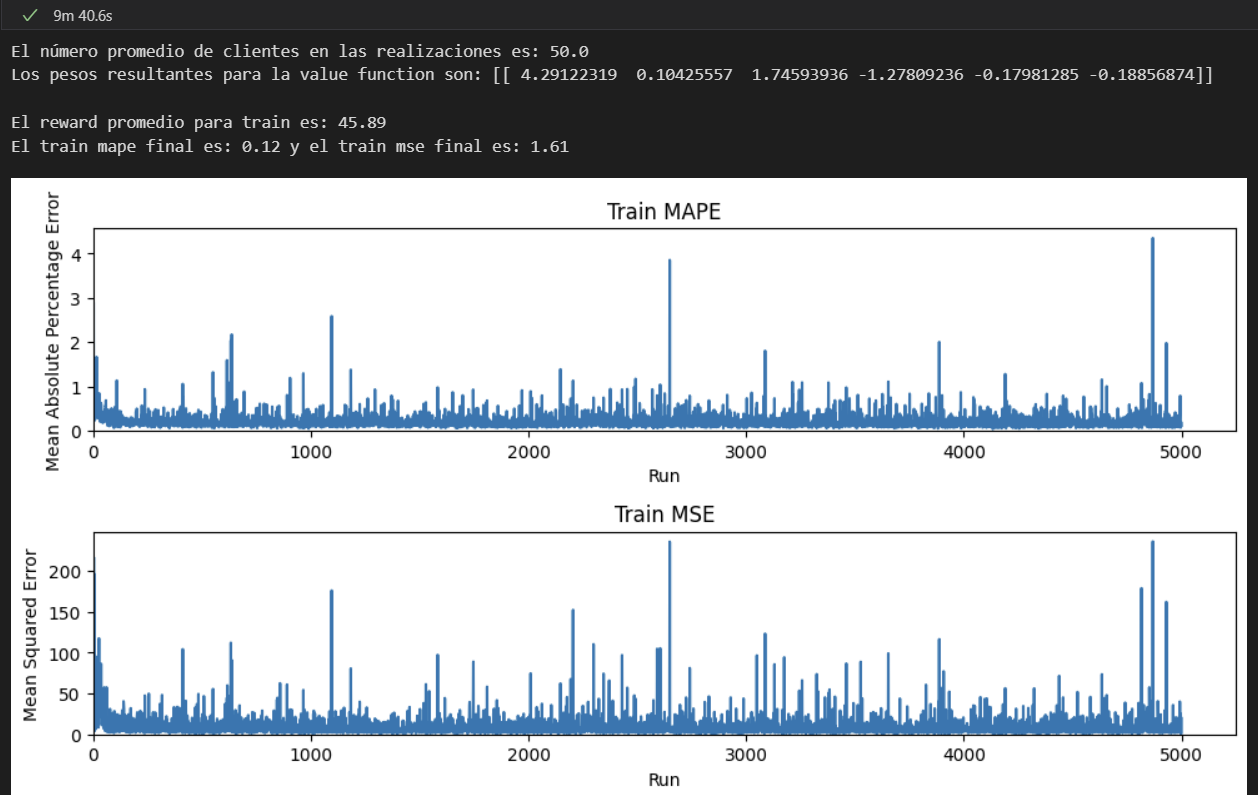

72.72
68.18
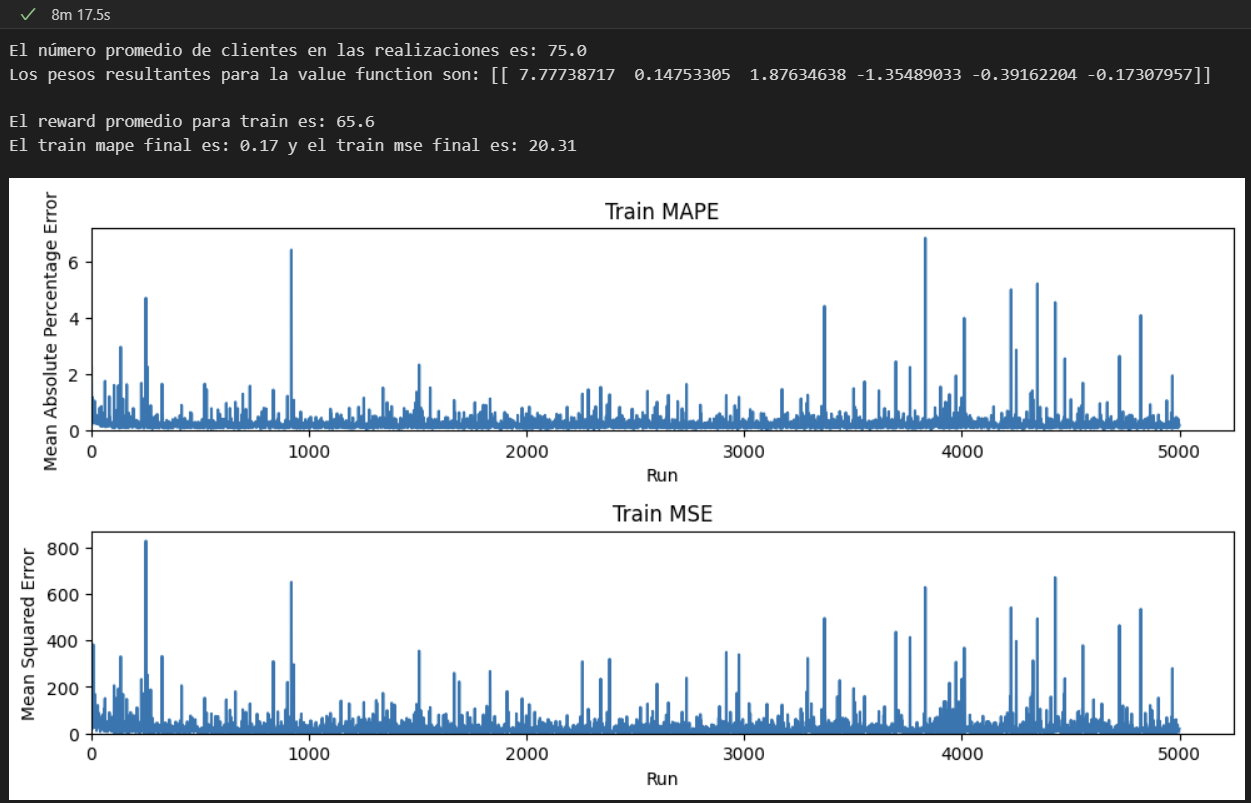

146.2
138.18
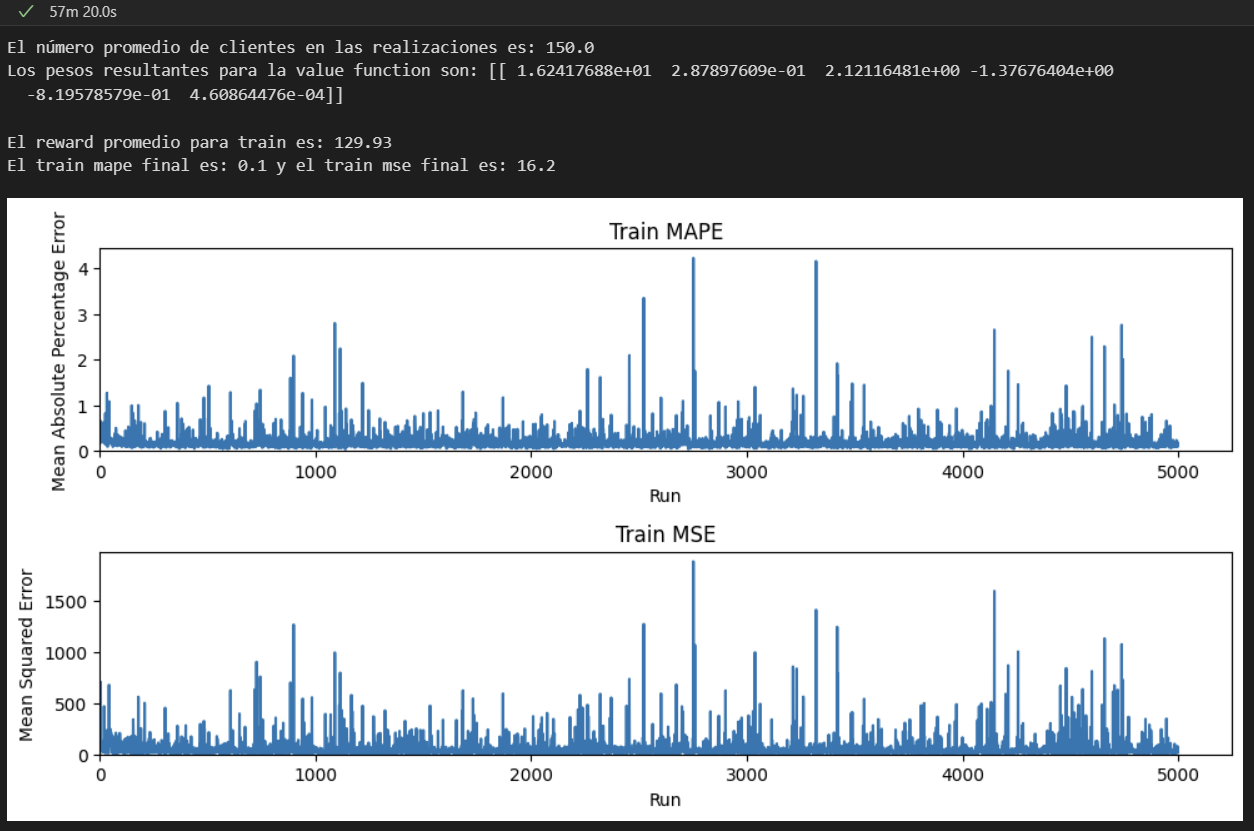

194.65
183.83
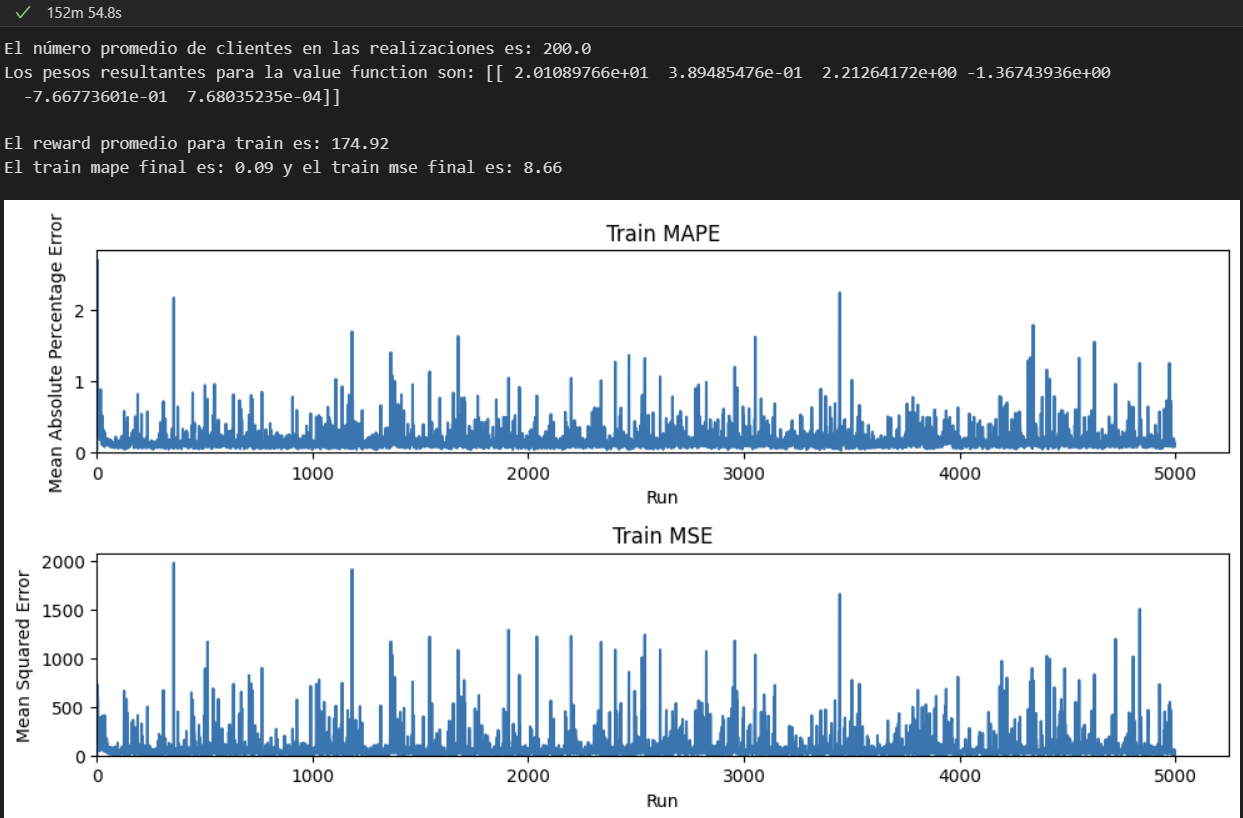

___

con 7: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_delay_system + *mean_vehicles_of*

47.64
48.02
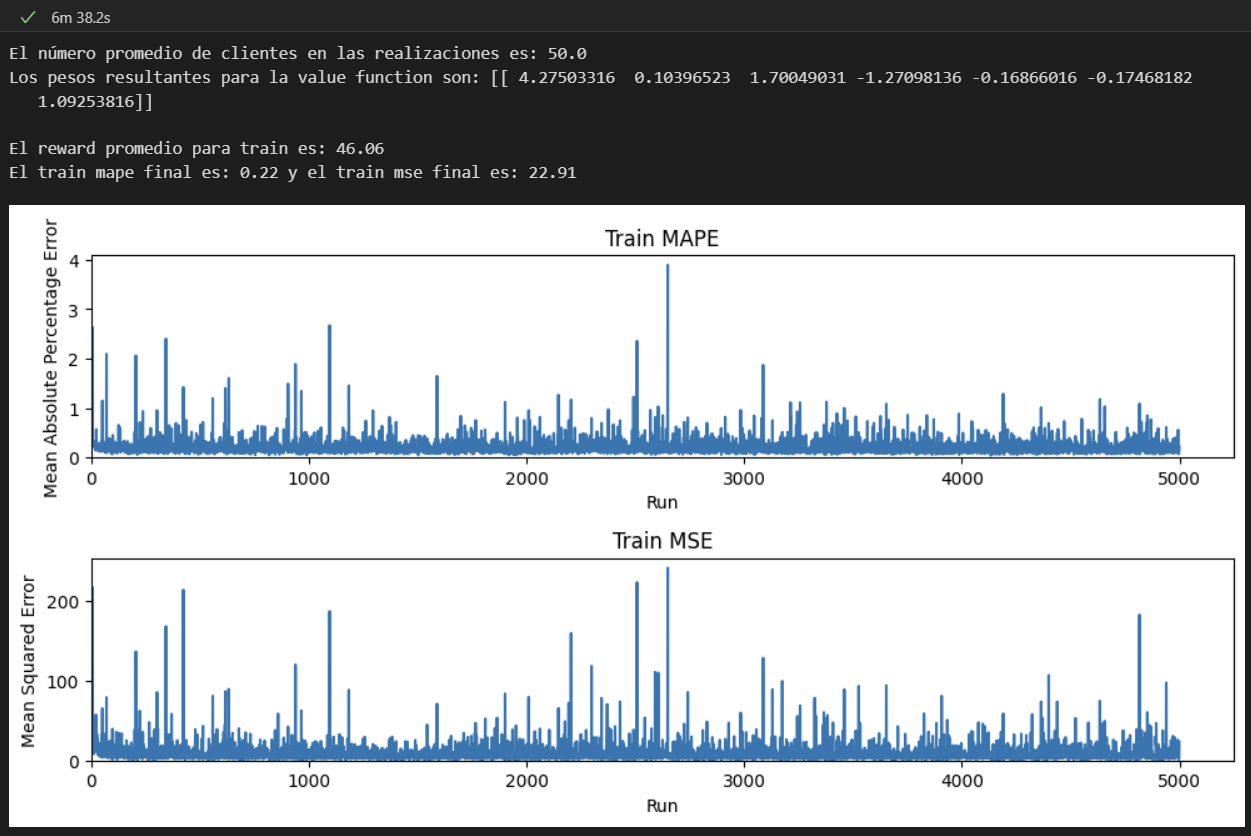

72.72
67.98
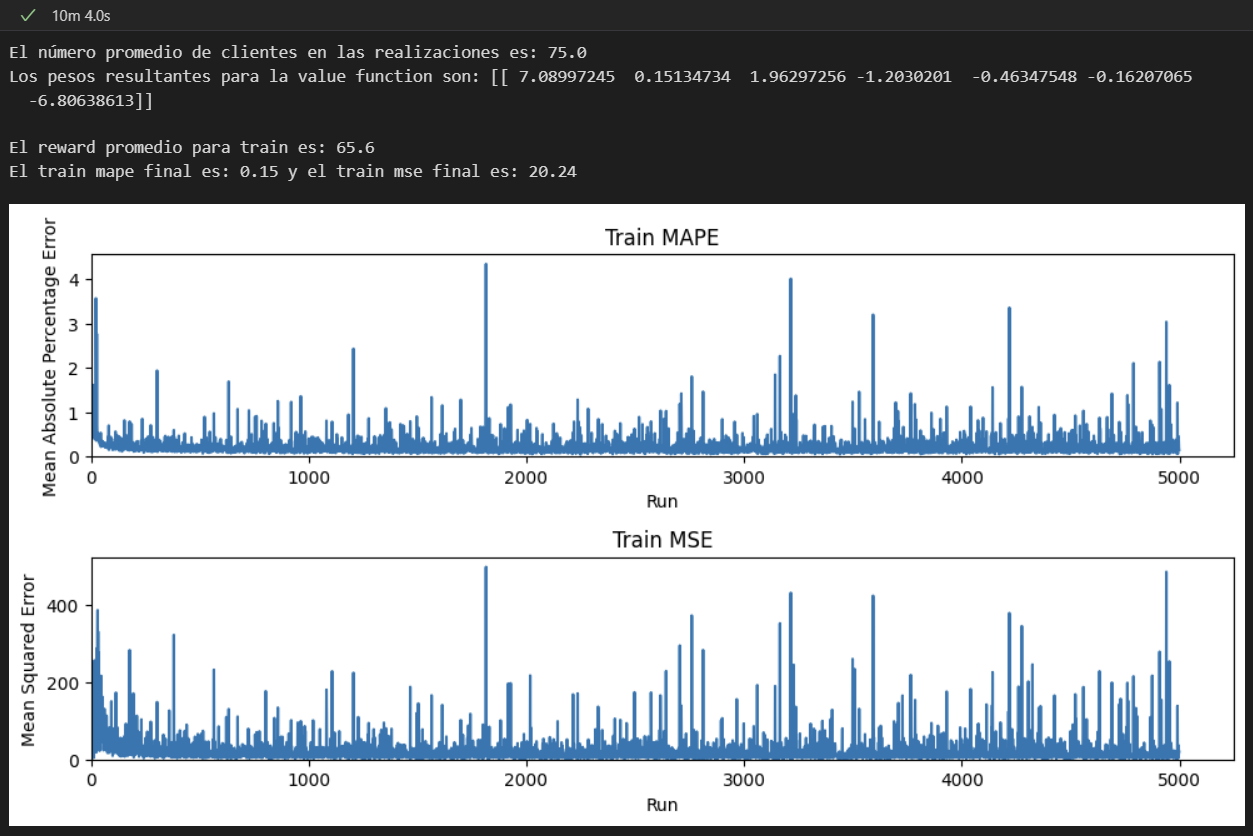

146.2
138.19
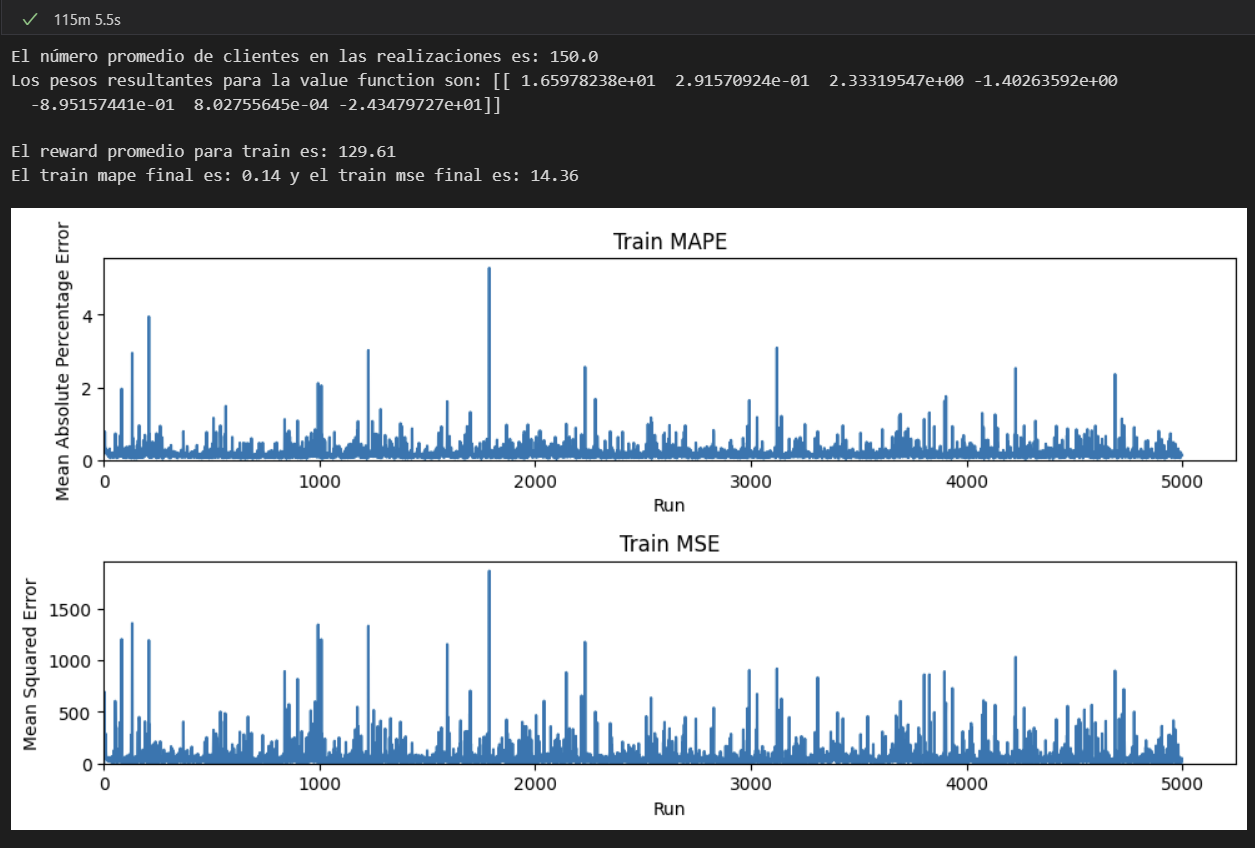

194.65
183.7
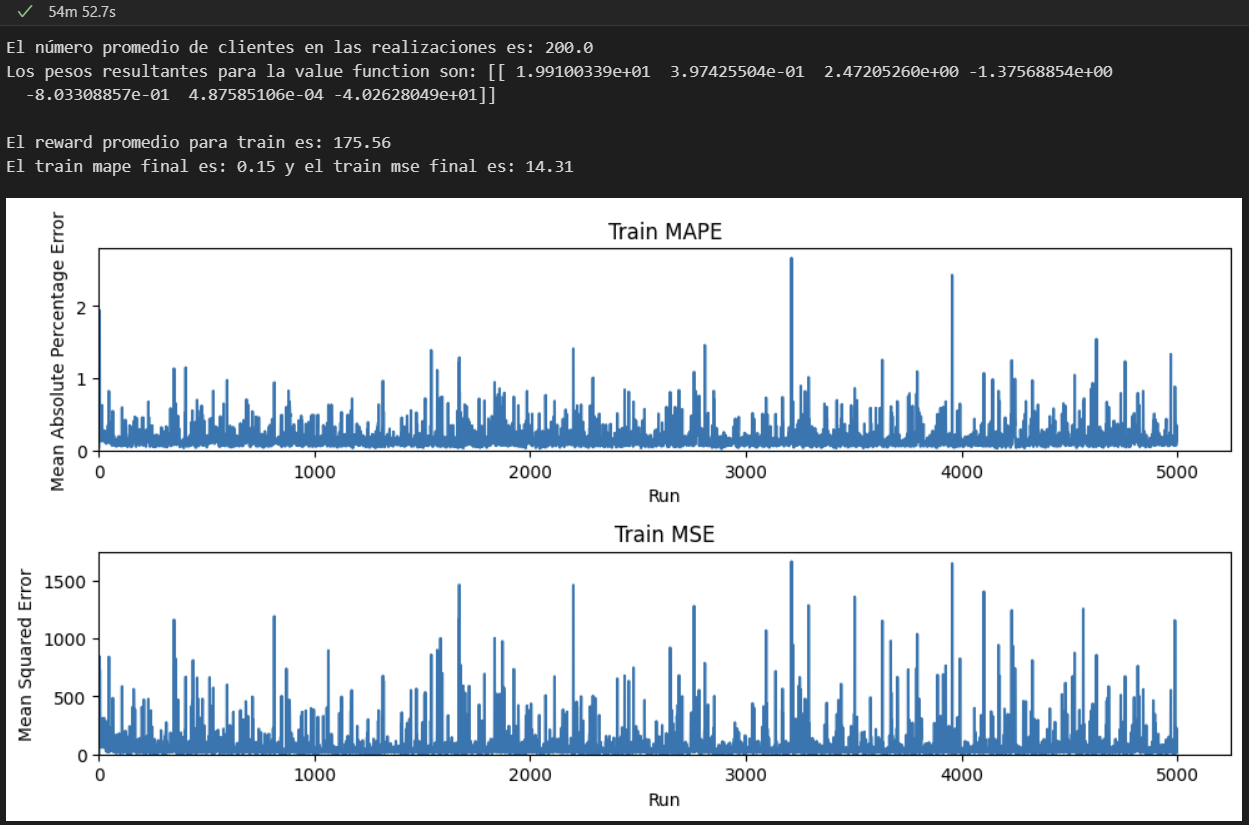

___

con 6: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_vehicles_of *(este es igual al anterior pero sacando mean_delay_system)*

47.64
48.28
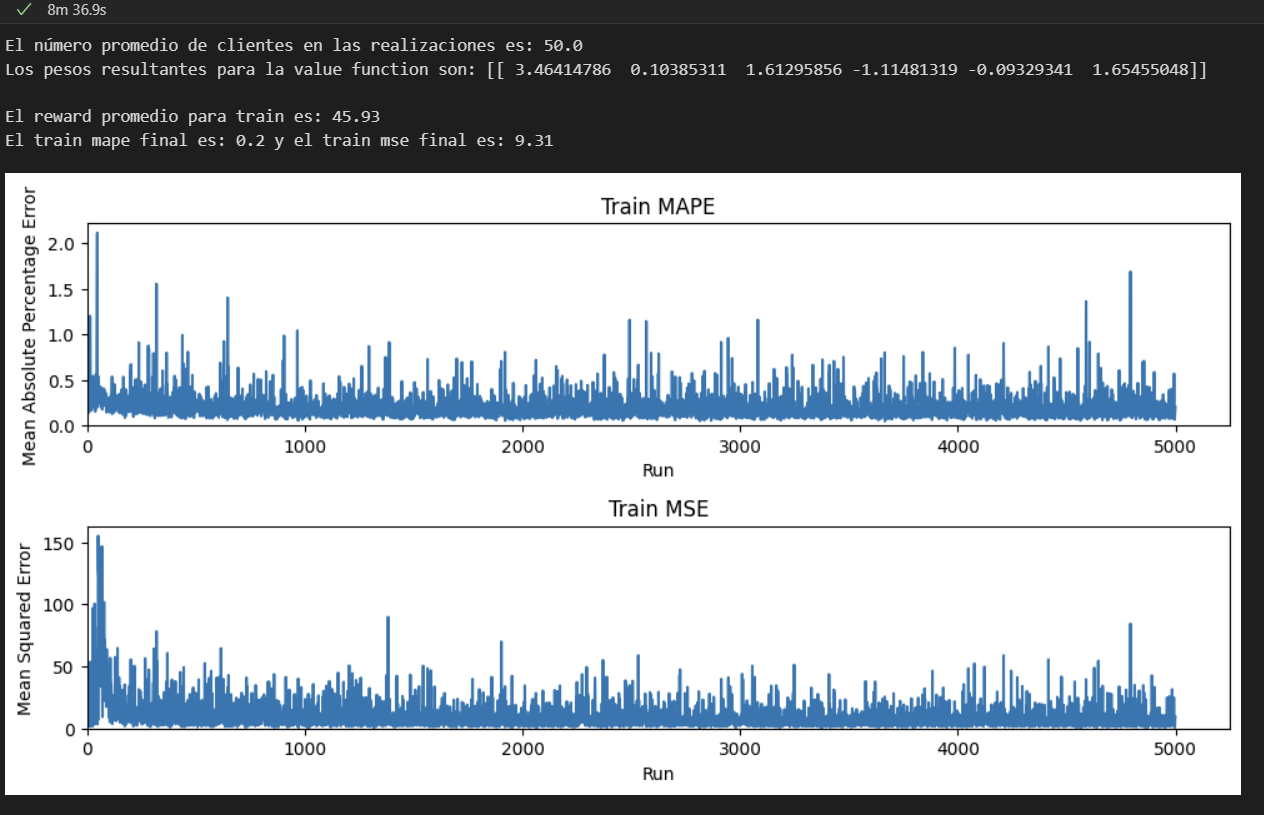

72.72
68.3
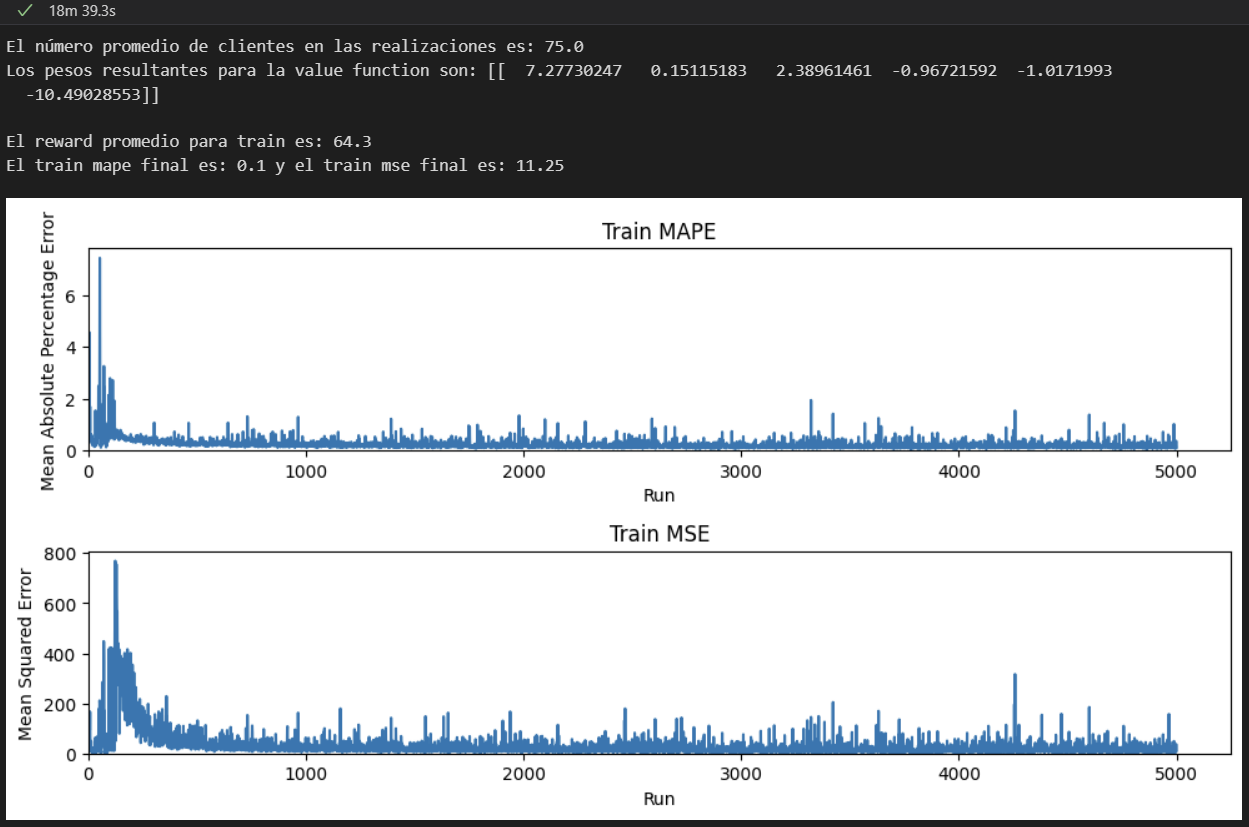

146.2
120.86
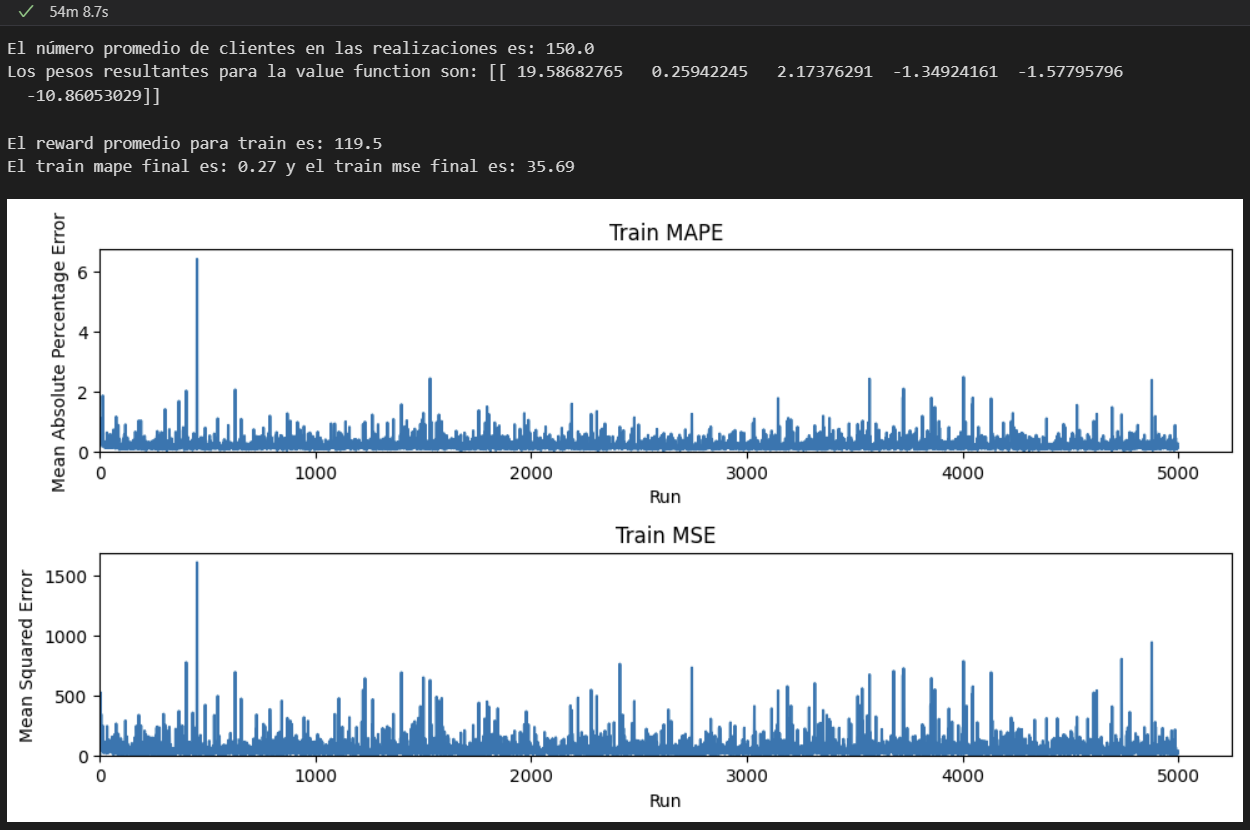

194.65
167.41
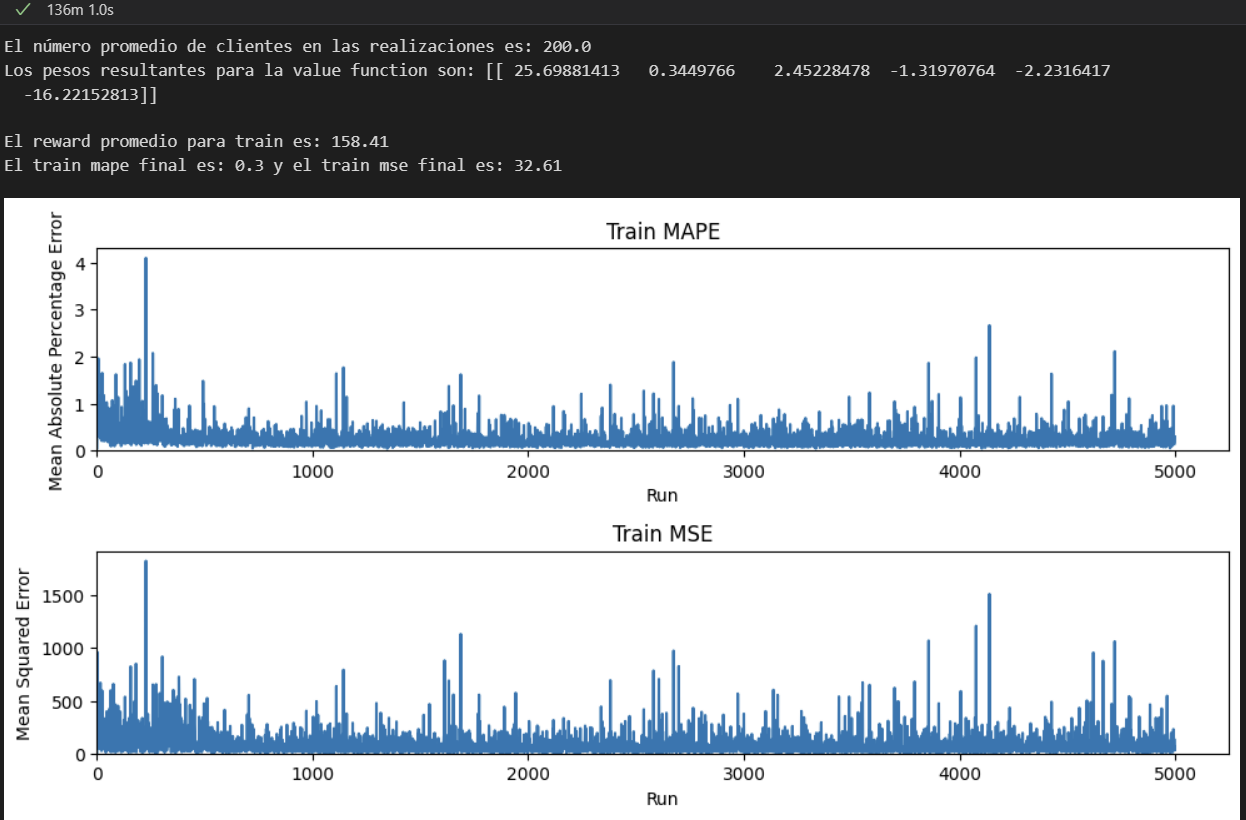

___

con 7 + n_vehicles: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_delay_system + *vehicles_of* + *std_vehicles_of*

47.64
48.49
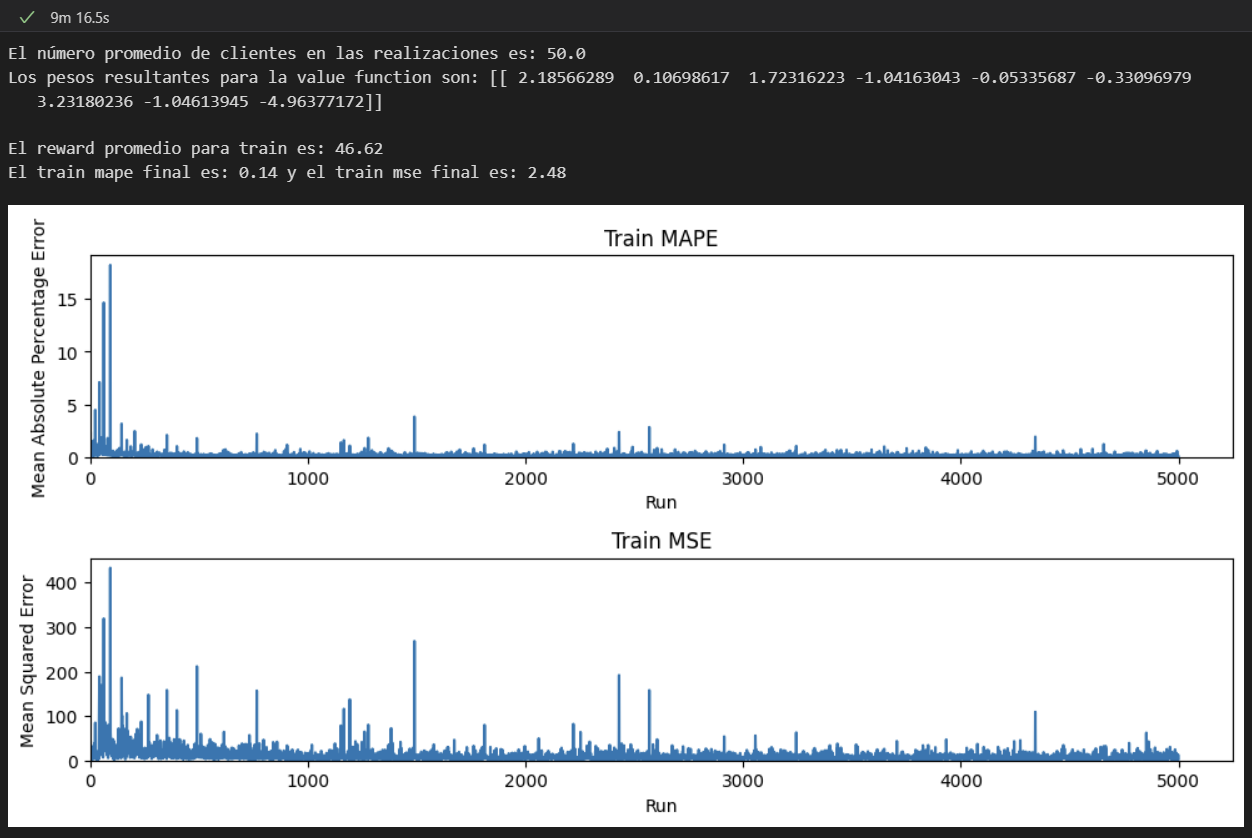

72.72
72.52
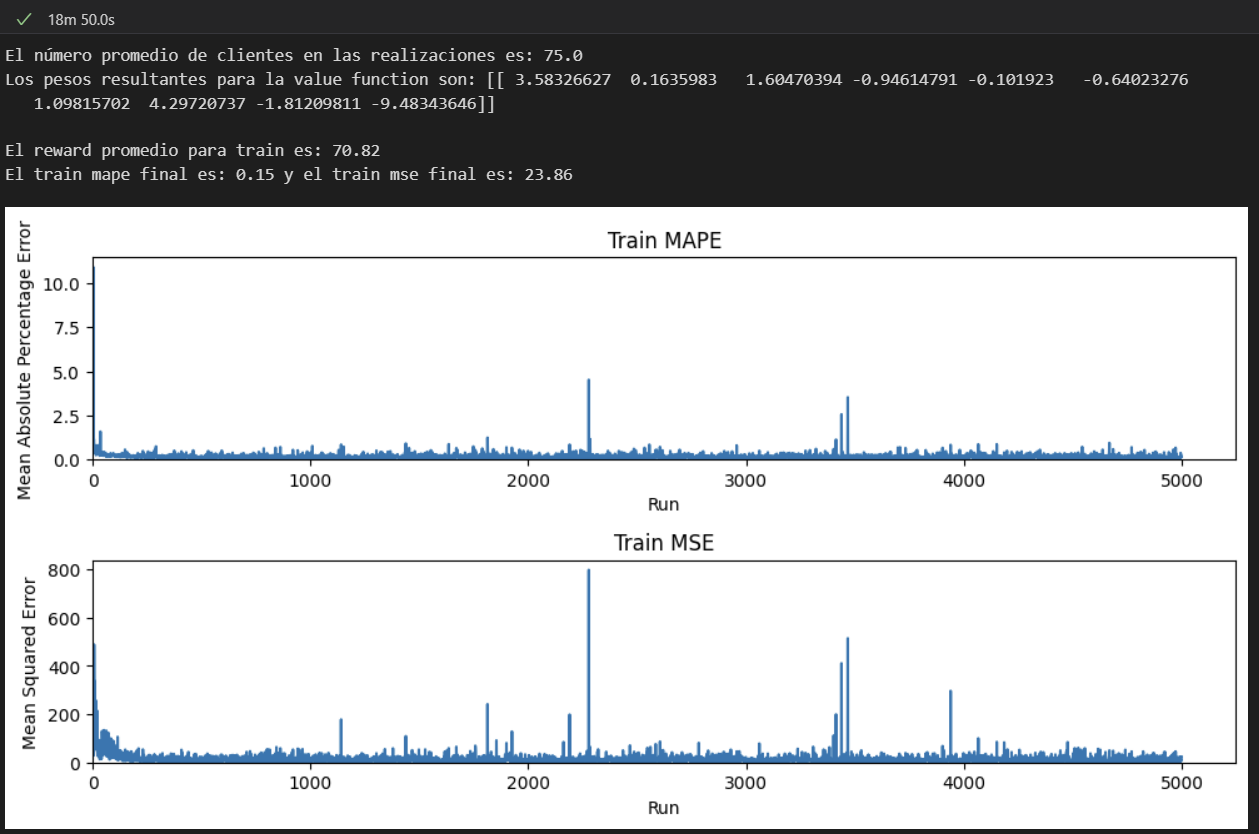

146.2
141.9
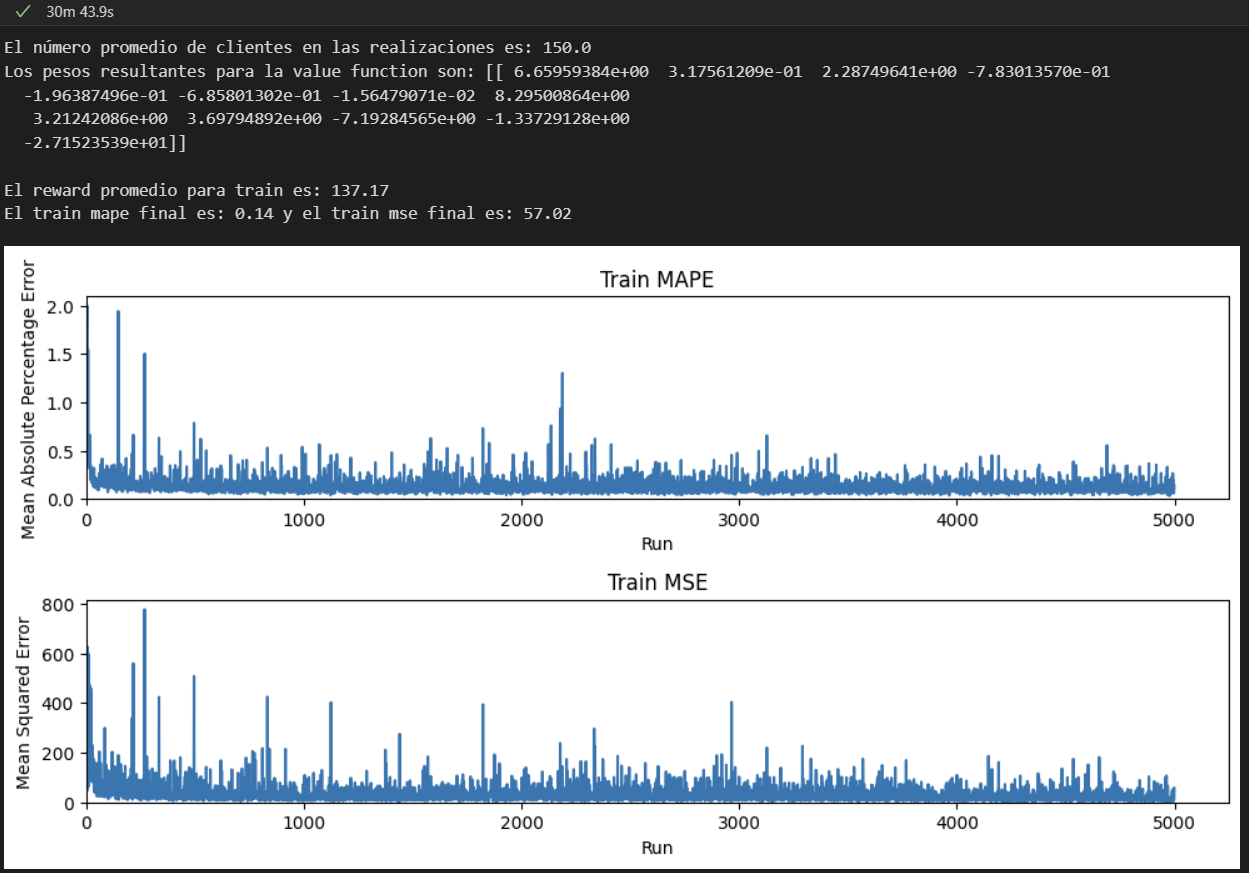

194.65
194.47
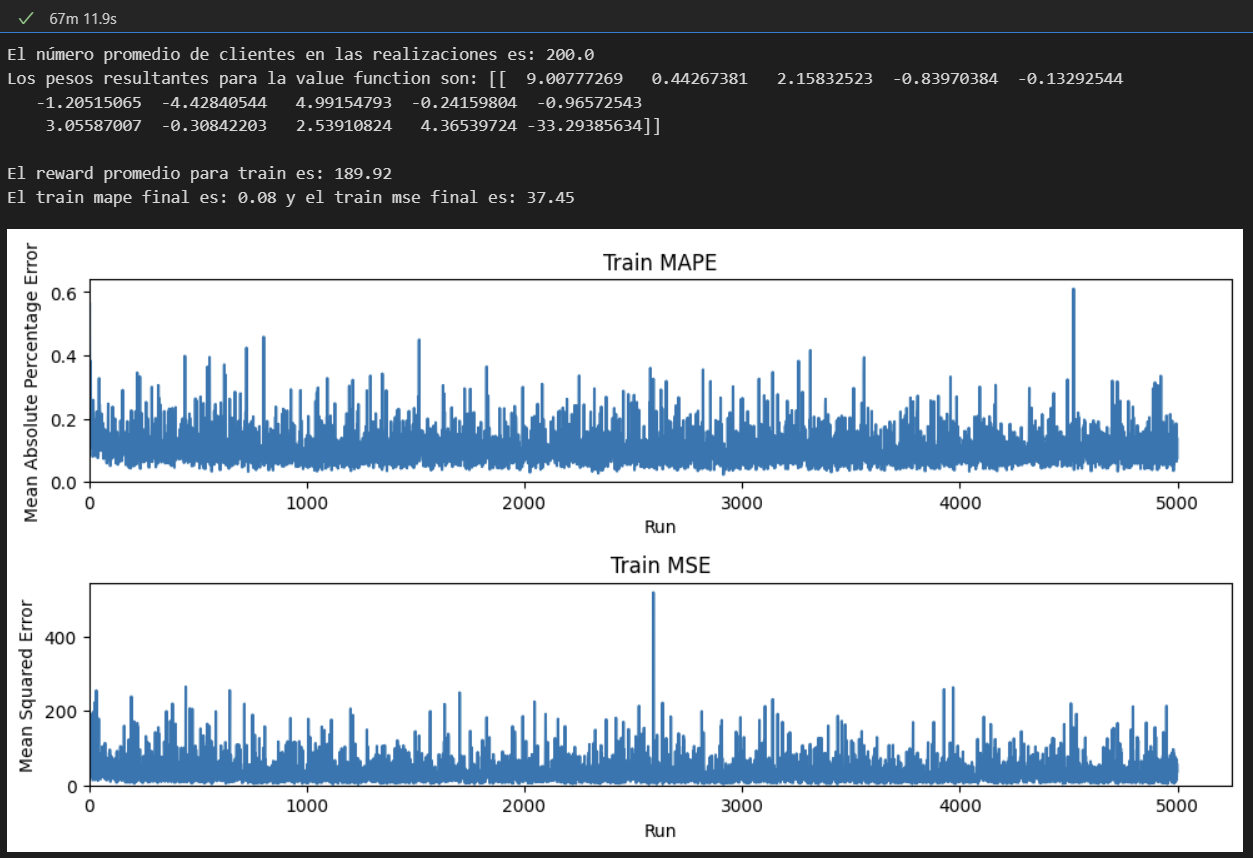

___

con 8 + 2 * n_vehicles: c + t_left + insertion_binary + n_cust_pend + *route_max_dist* + *std_route_max_dist* + mean_delay_system + vehicles_of + std_vehicles_of

47.64
49.03
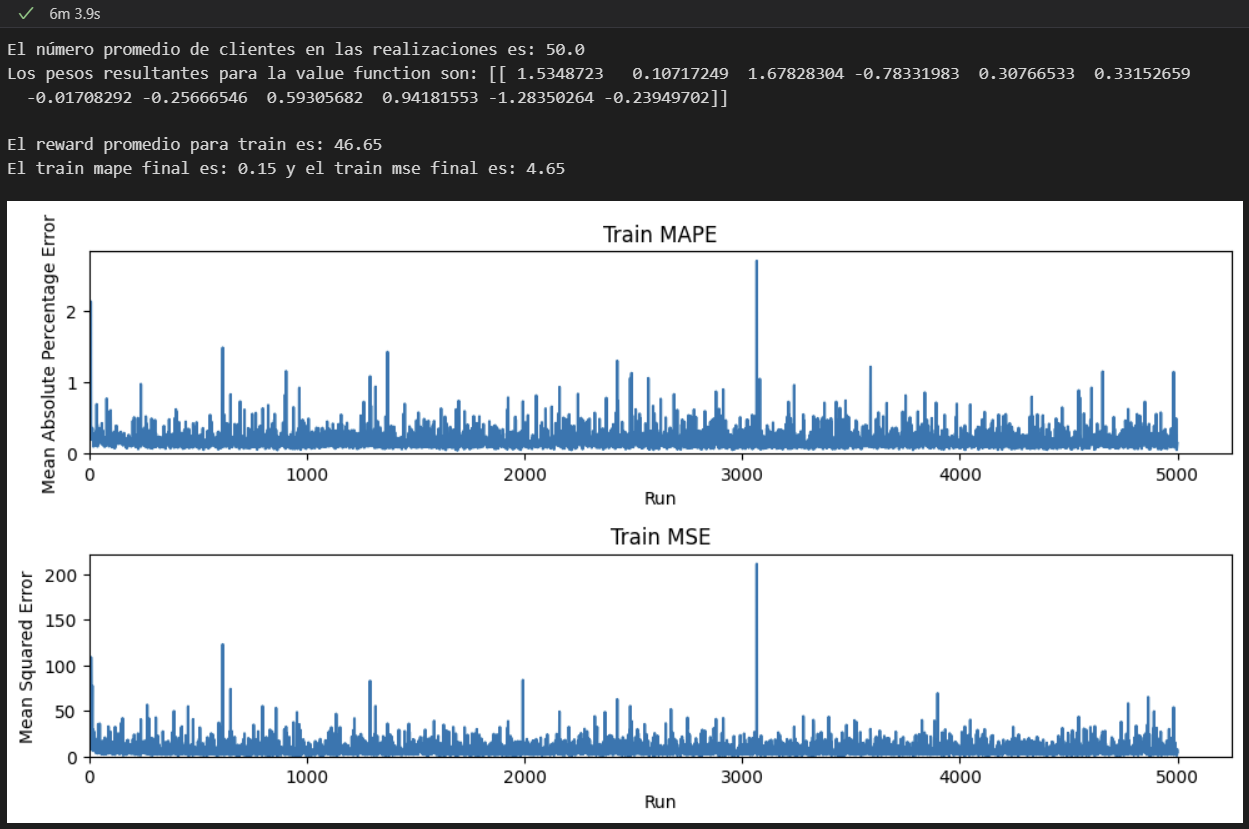

72.72
67.63
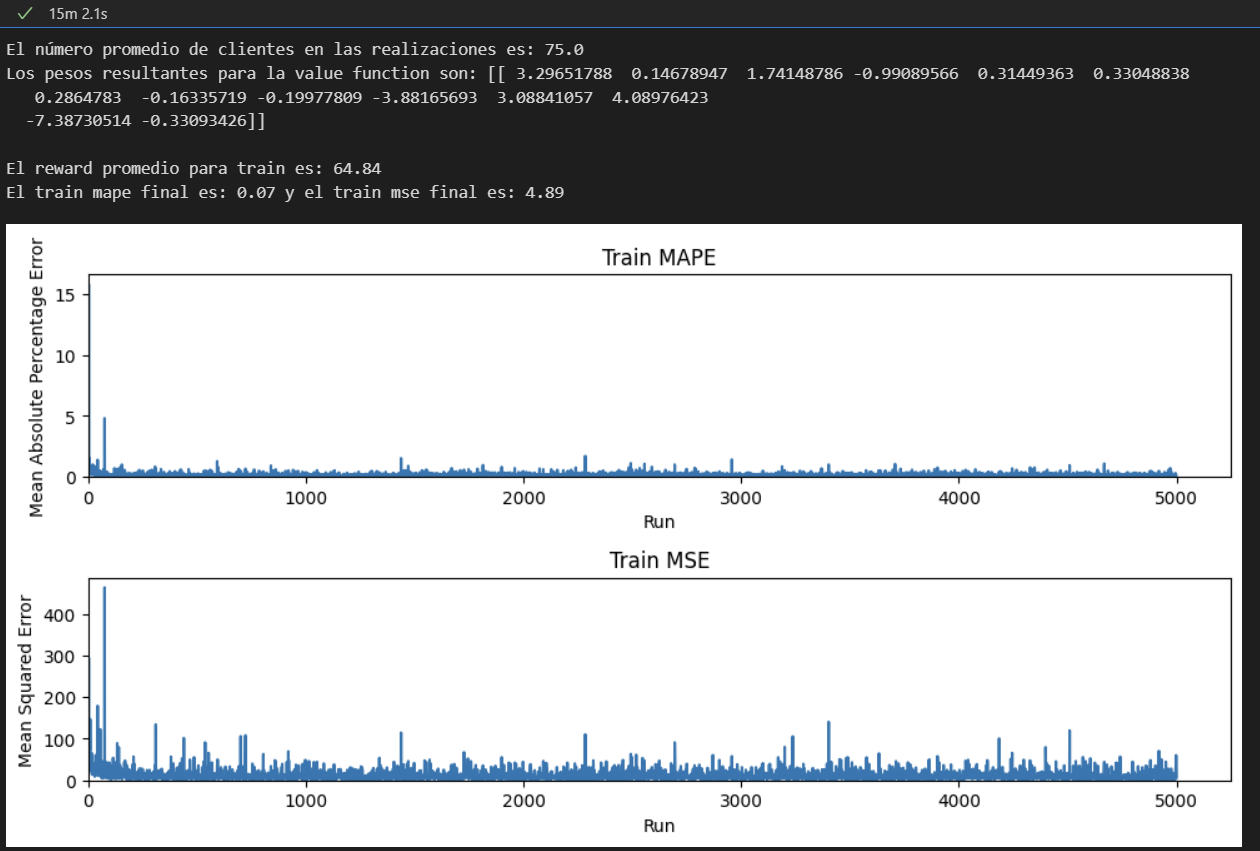

146.2


SI FUNCIONA MEJOR LO DEJO ASÍ Y PRUEBO SIN EL VEHICLES OF
SI FUNCIONA MEJOR LO DEJO ASÍ Y PRUEBO CON t_fin_route agregado y desagregado vs distancia de la ruta agregado y desagregado

___

con 8 + n_vehicles: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_delay_system + vehicles_of + std_vehicles_of + *mean_t_fin_route*

47.64
48.5
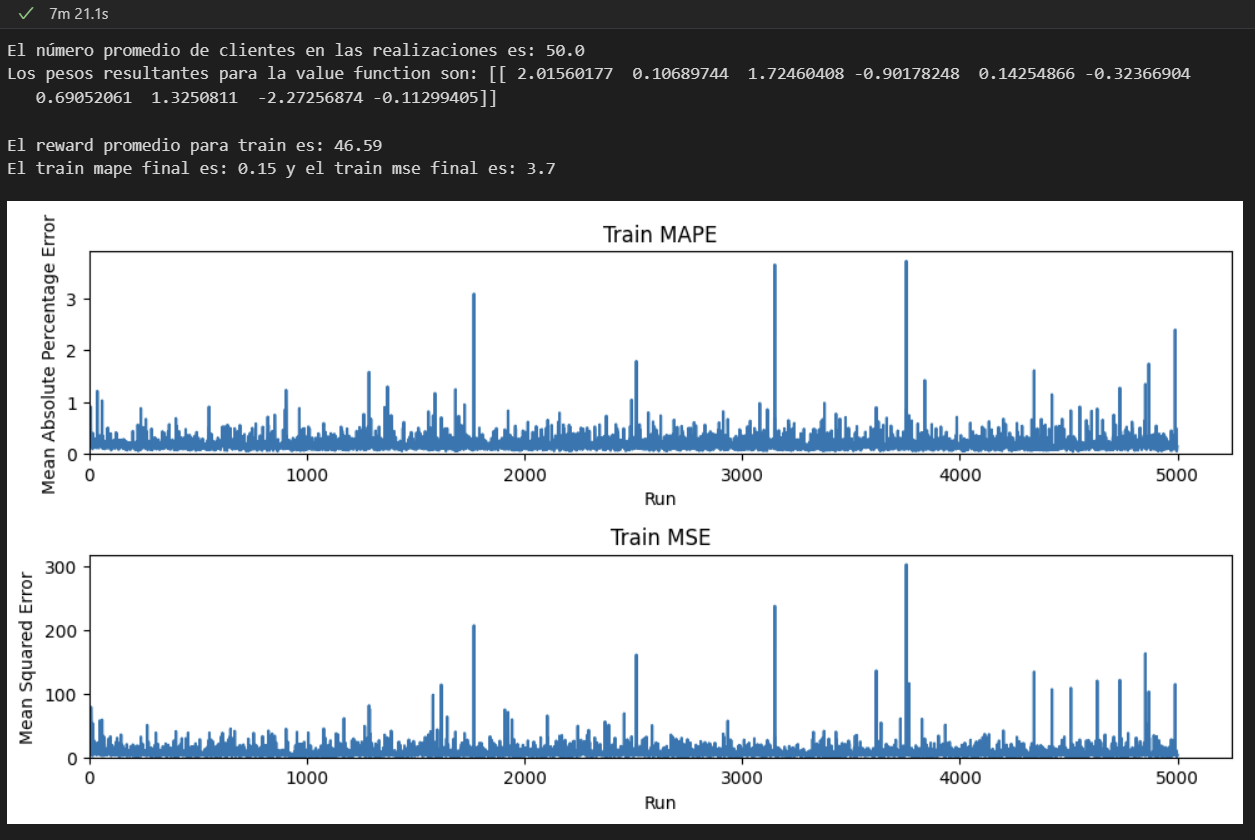

72.72
71.95
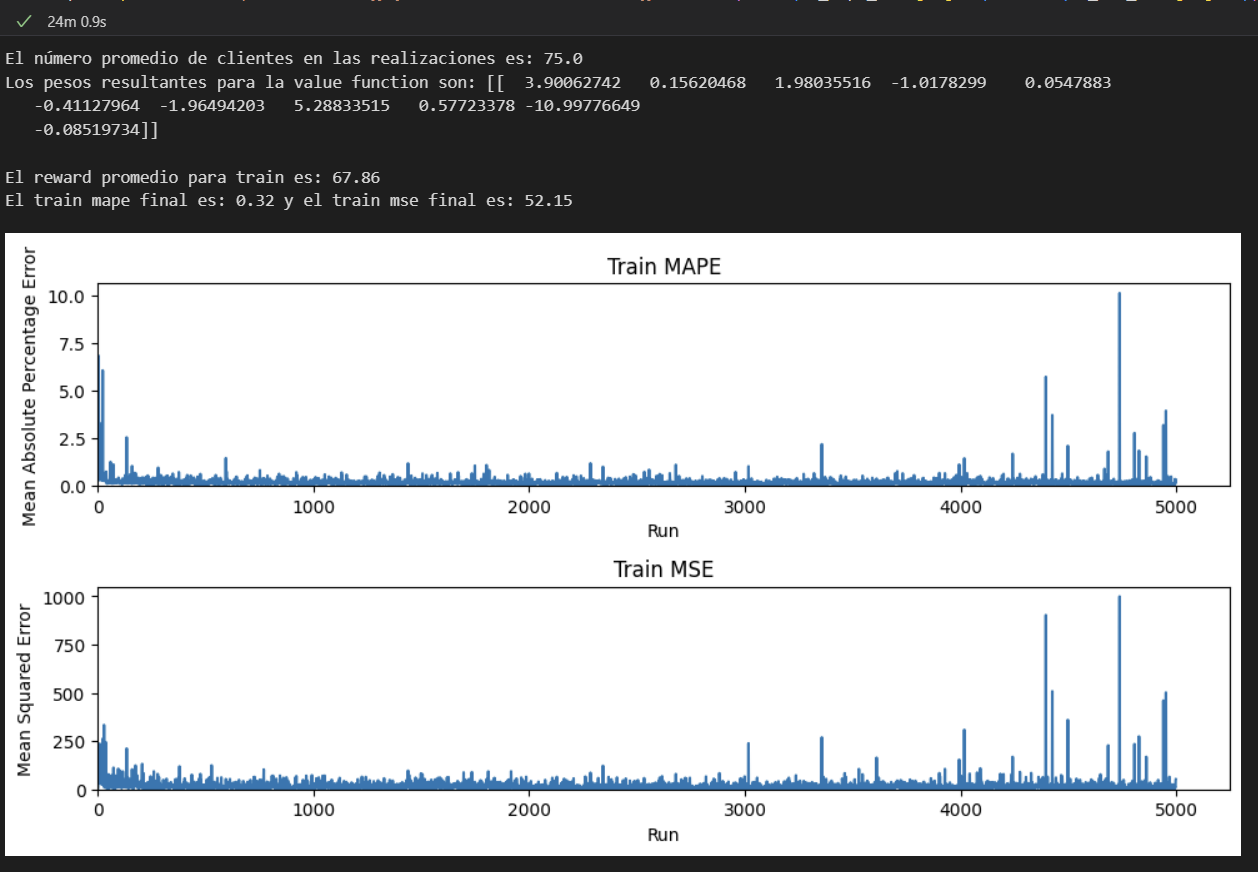

146.2
138.24
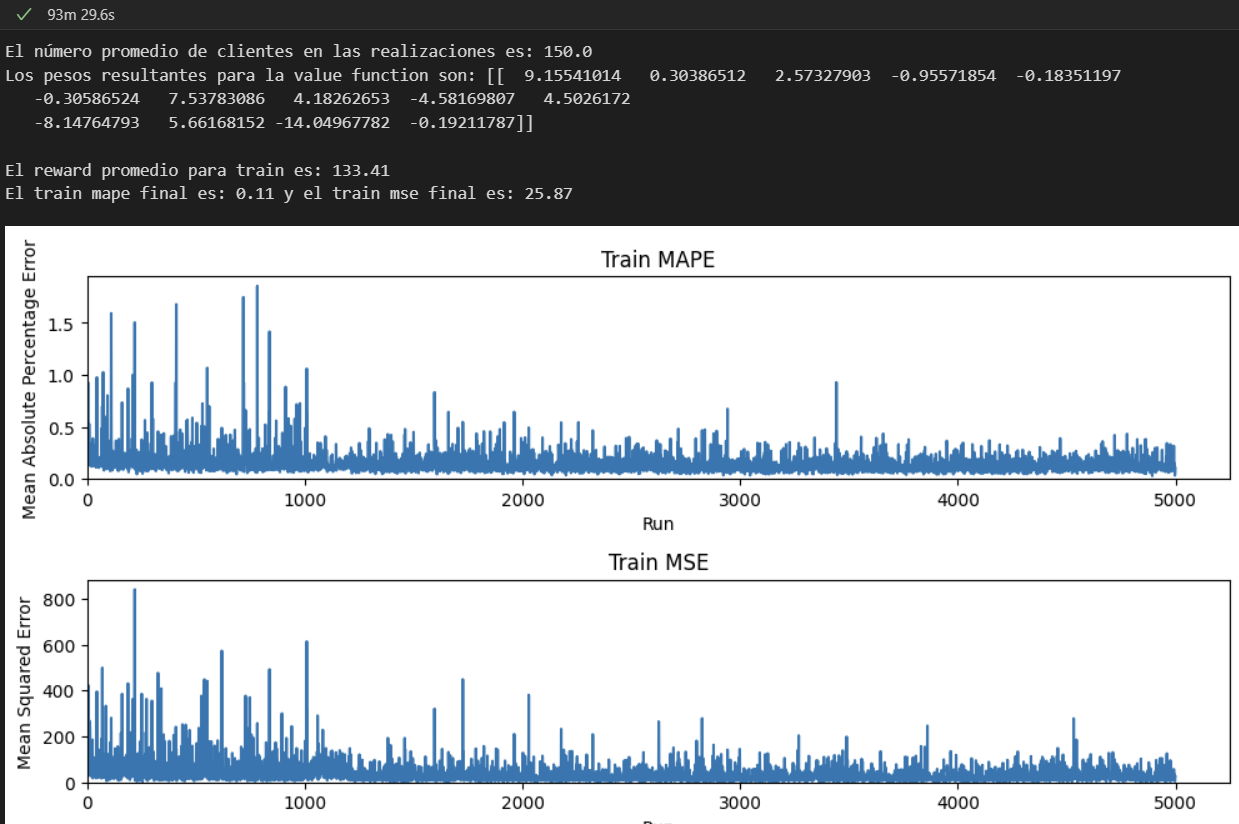

no probé con la última instancia porque pareciera que el modelo no mejora con el feature agregado

___

con 8 + 2 * n_vehicles: c + t_left + insertion_binary + n_cust_pend + route_max_dist + mean_delay_system + vehicles_of + std_vehicles_of + *t_fin_route* + *std_t_fin_route*

___

AGREGAR EL LARGO DE LA RUTA PROMEDIO, O POR VEHÍCULO Y STD EN VEZ DE EL TIEMPO ESTIMADO EN ATENDERLA

El número promedio de clientes en las realizaciones es: 75.0
El reward promedio para test es: 67.63
El test mape es: 0.18 y el test mse es: 12.85


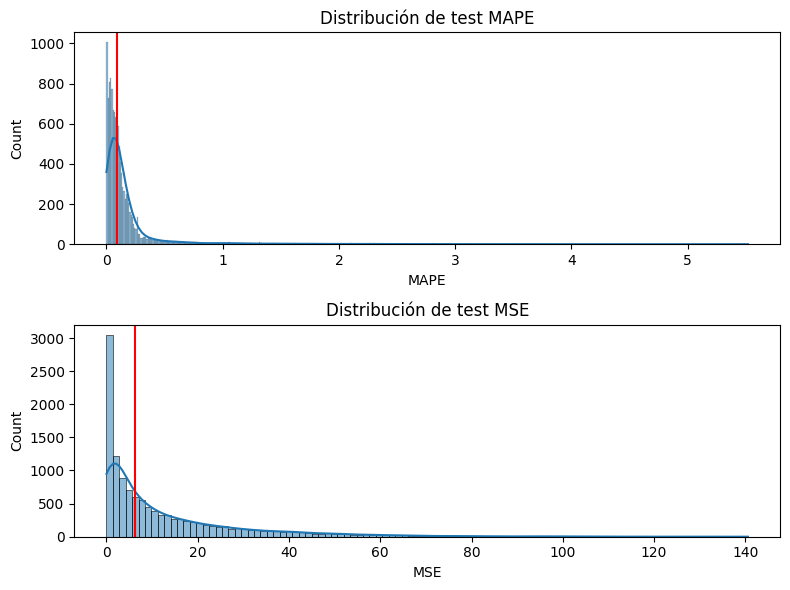

In [ ]:
# se crean las realizaciones de test para el algoritmo
monte_carlo.simulateTestRealizations(N=100, simulation_seed=5)
print('El número promedio de clientes en las realizaciones es:', round(np.mean([len(realization) for realization in monte_carlo.test_realizations]), 2))

# testeando la política encontrada en train con el método RLS
mc_test_rewards, mc_test_mape, mc_test_mse, mc_fig_test_errors = monte_carlo.test(mc_trained_value_function)
print('El reward promedio para test es:', round(np.mean(mc_test_rewards), 2))
print('El test mape es: {} y el test mse es: {}'.format(mc_test_mape, mc_test_mse))

___

CON PENALTY

CON FEATURES ORIGINALES

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
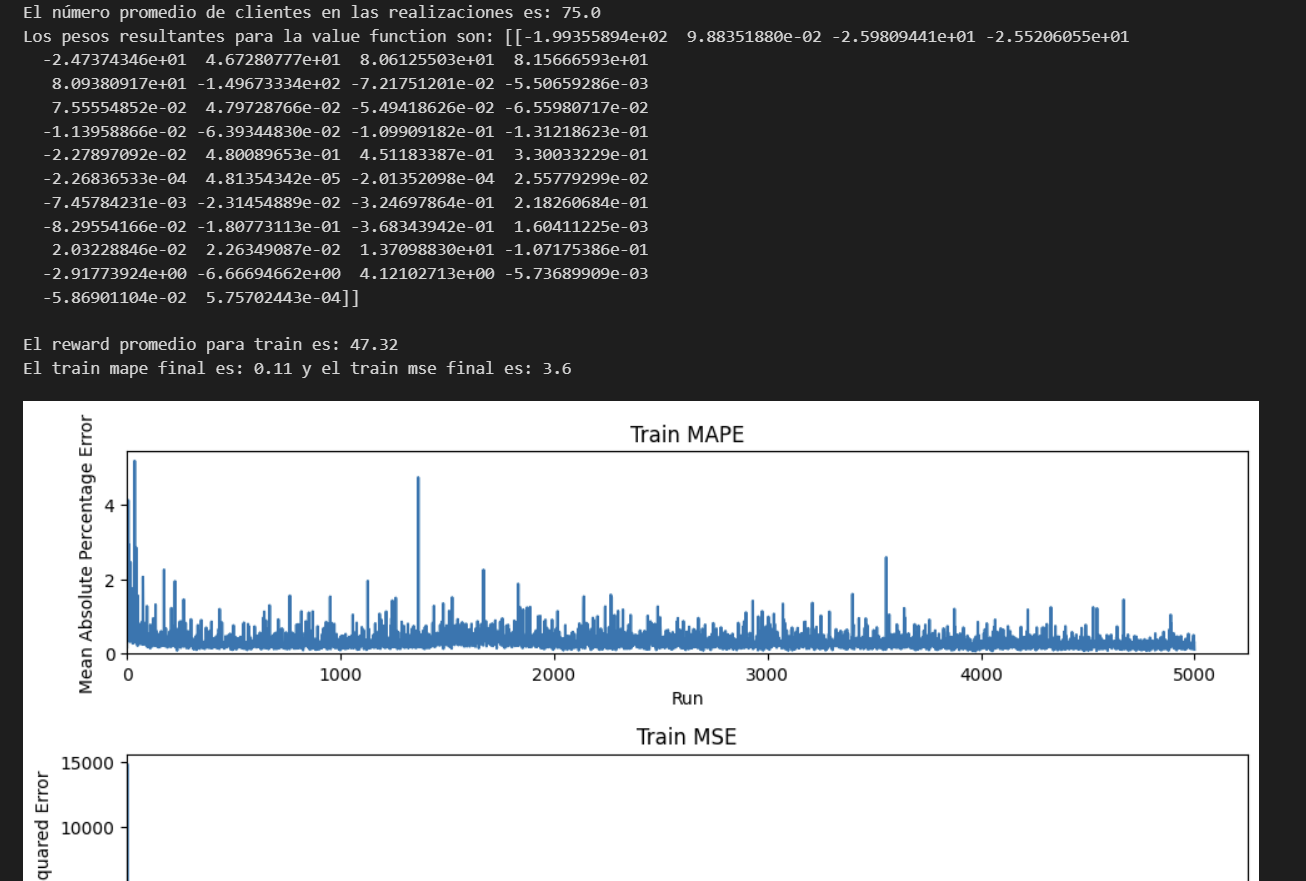

TEST
CI myopic: 72.72/75
MC rls: 54.91/75 con MAPE:0.25 y MSE:9.88

Bajandole el lambda de 100 a 10

TEST
CI myopic: 72.72/75
MC rls: 59.14/75 con MAPE:0.44 y MSE:16.7

CON 22 FEATURES

Instancia con 2 vehículos y de 50 clientes por vehículo

TRAIN MC rls 5000 realizaciones
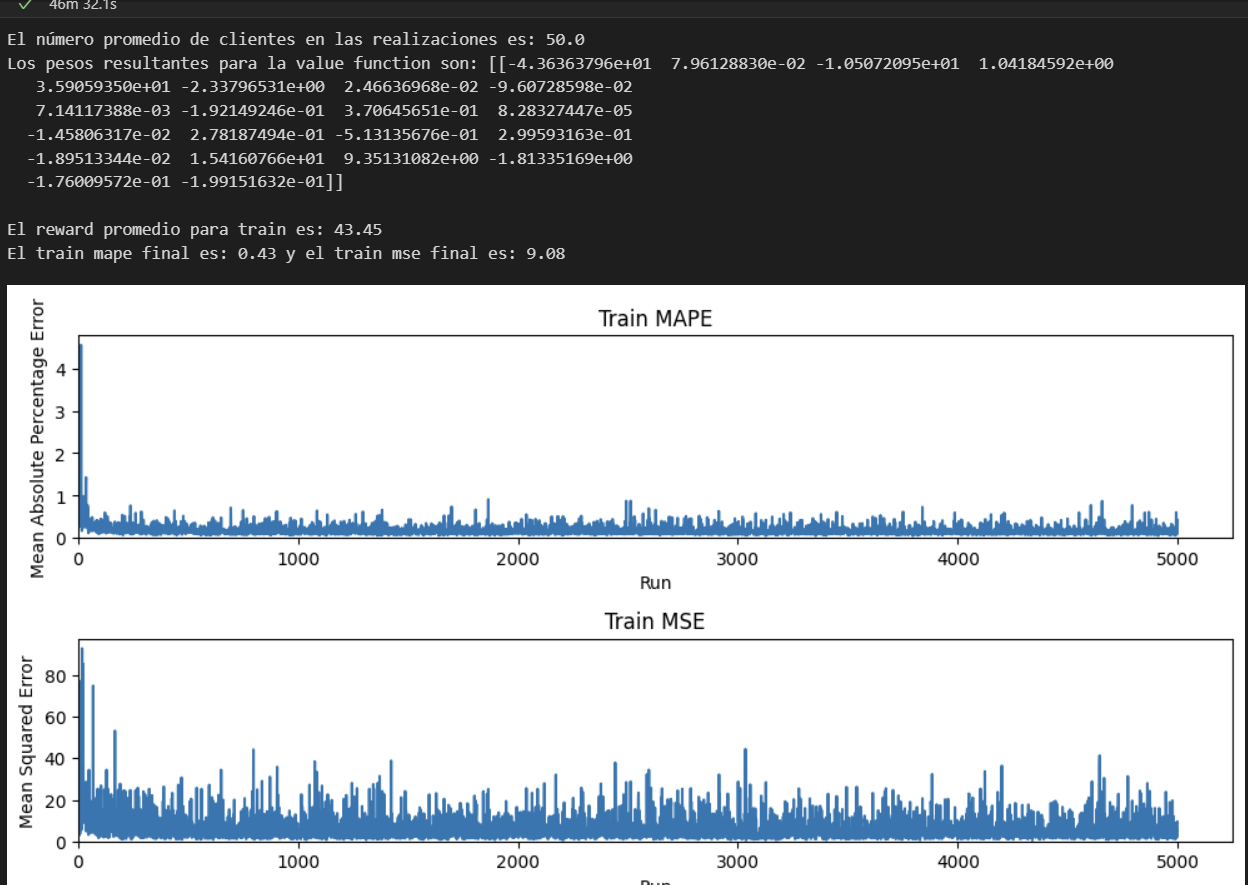
TEST
CI myopic: 47.64/50
MC rls: 45/50 con MAPE:0.43 y MSE:5.32

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
TEST
CI myopic: 72.72/75
MC rls: 34.91/75 con MAPE:1.33 y MSE:17.59

CON 6 FEATURES

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
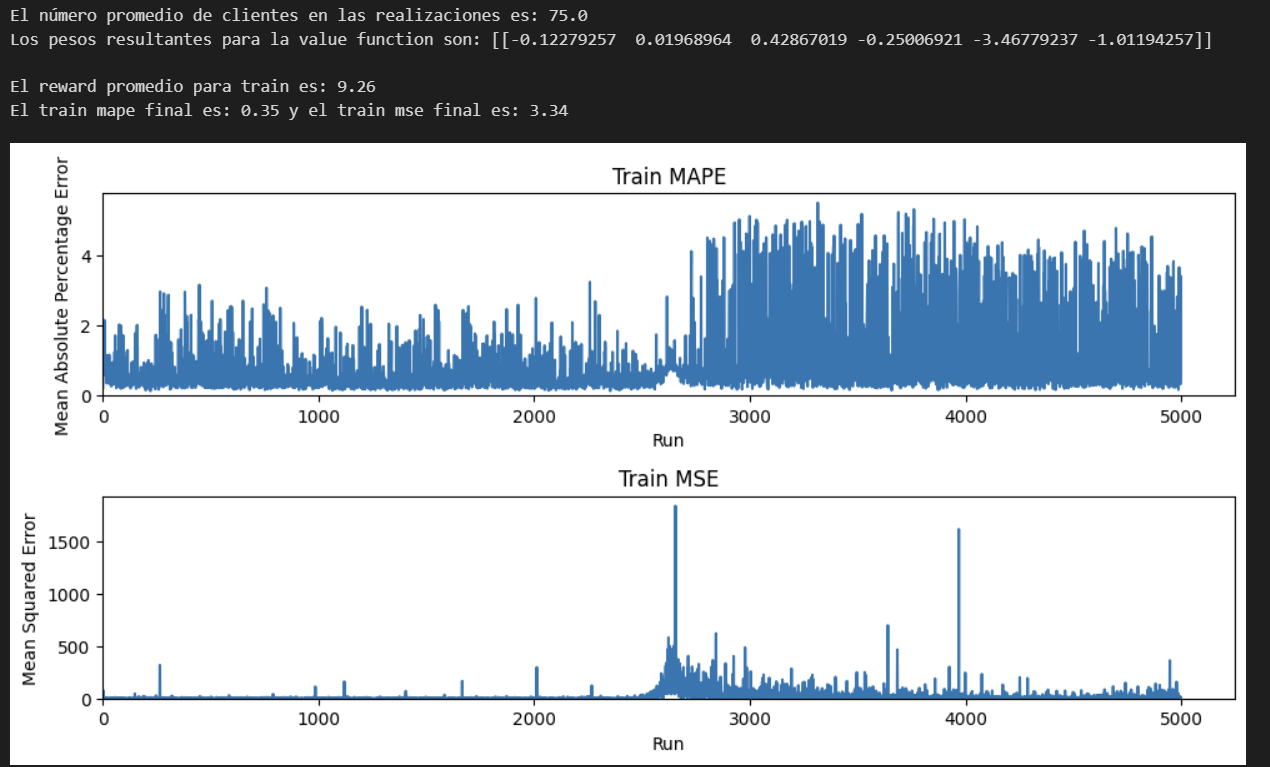
TEST
CI myopic: 72.72/75
MC rls: 2.24/75 con MAPE:4.07 y MSE:21.84

TRAIN MC rls 30000 realizaciones
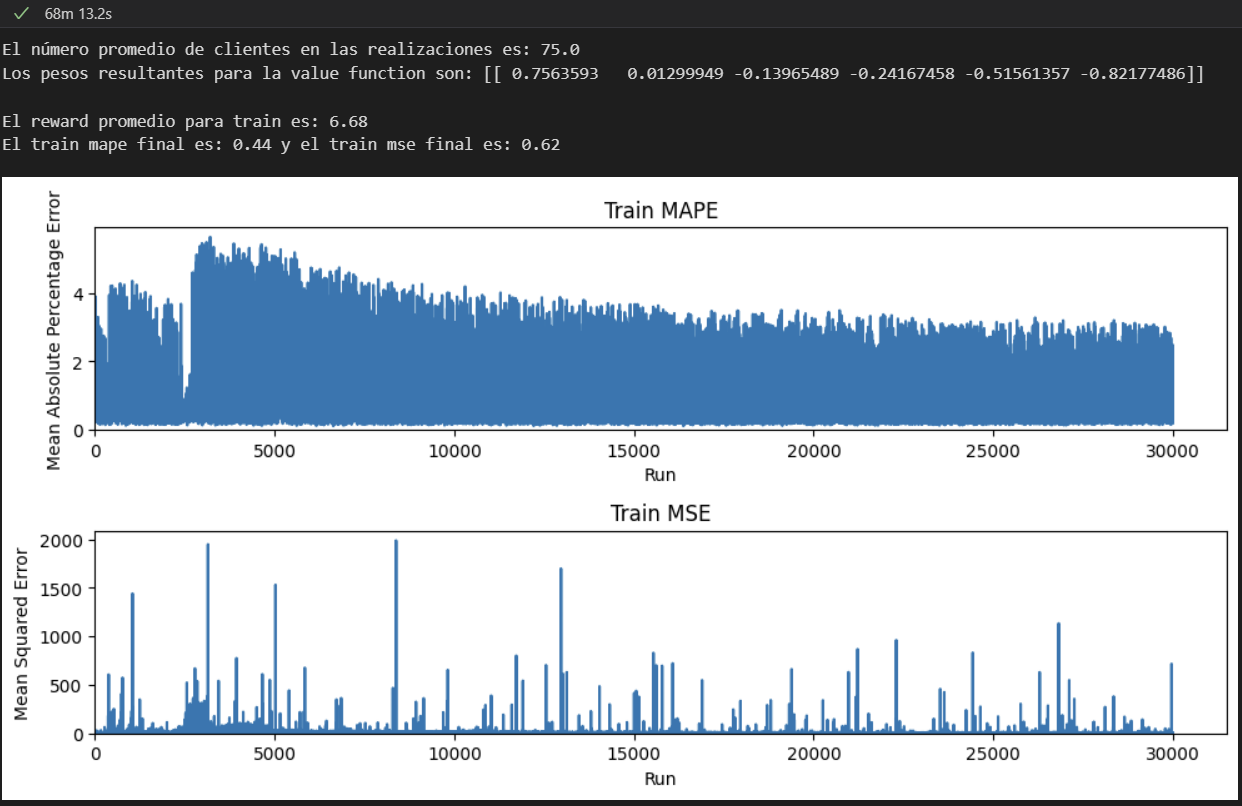
TEST
CI myopic: 72.72/75
MC rls: 1/75 con MAPE:2.85 y MSE:10.59

Bajandole el lambda de 100 a 10
TEST
CI myopic: 72.72/75
MC rls: 1/75 con MAPE:3.56 y MSE:16.58

___

SACÁNDO EL PENALTY

CON 6 FEATURES (- EL DE PENALTY)

___
___

Instancia con 2 vehículos y de 50 clientes por vehículo

TRAIN MC rls 10000 realizaciones
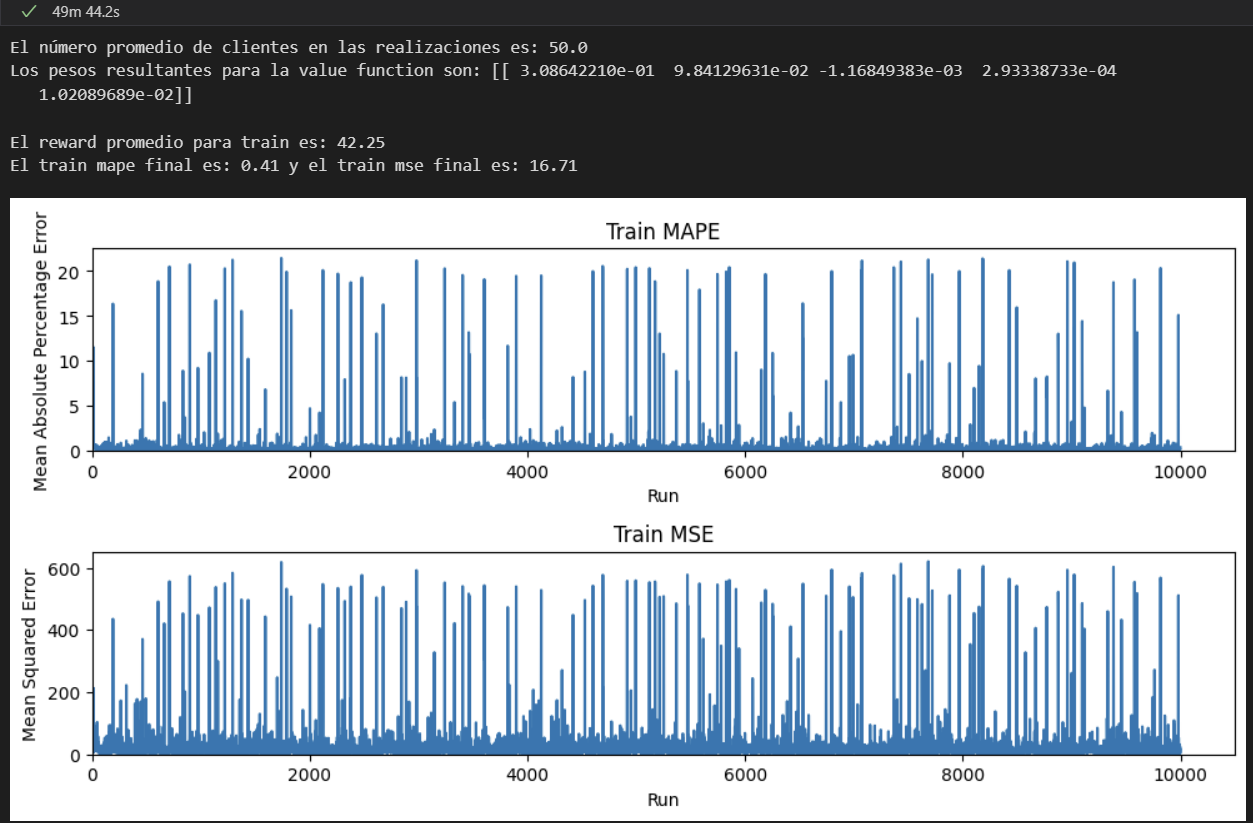
TEST
CI myopic: 50/50
MC rls: 40.41/50 con MAPE:0.27 y MSE:12.38

TRAIN MC rls 20000 realizaciones
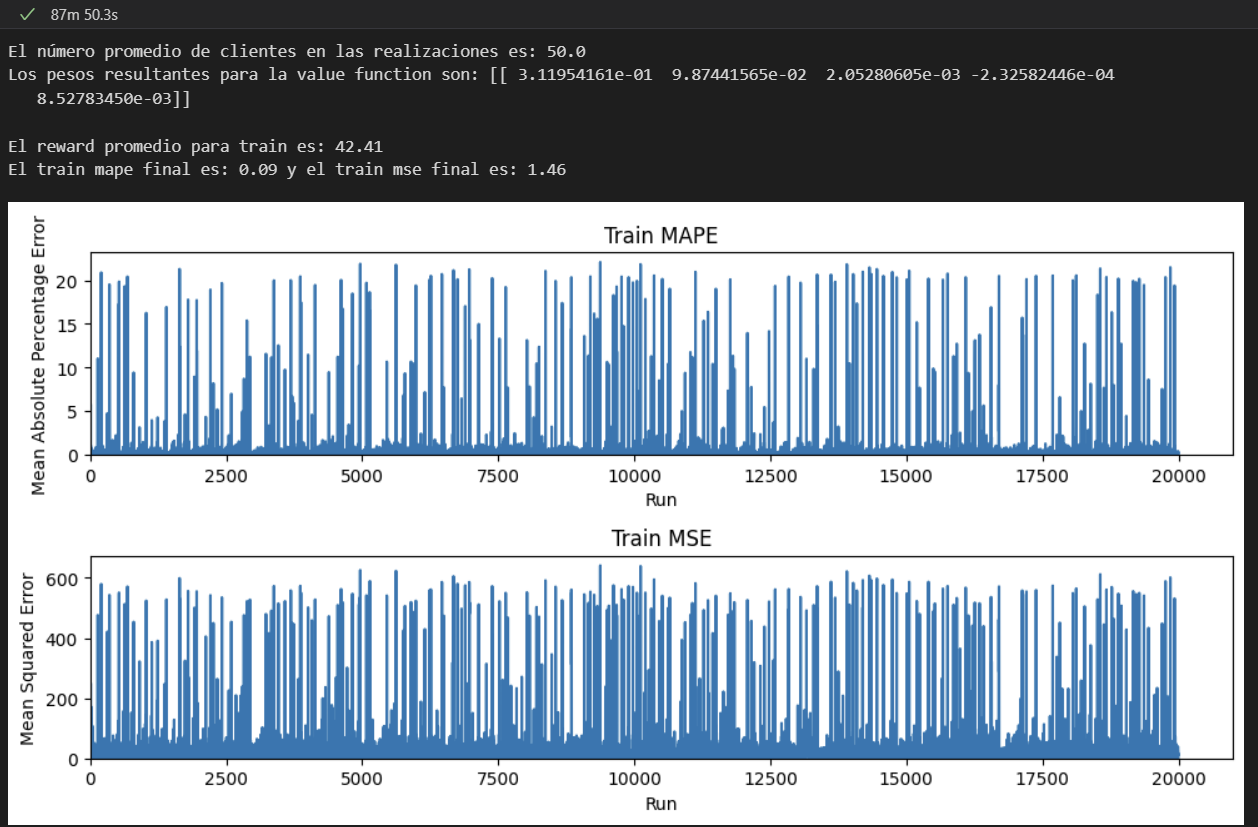
TEST
CI myopic: 50/50
MC rls: 47.96/50 con MAPE:0.23 y MSE:19.35

TRAIN MC rls 30000 realizaciones
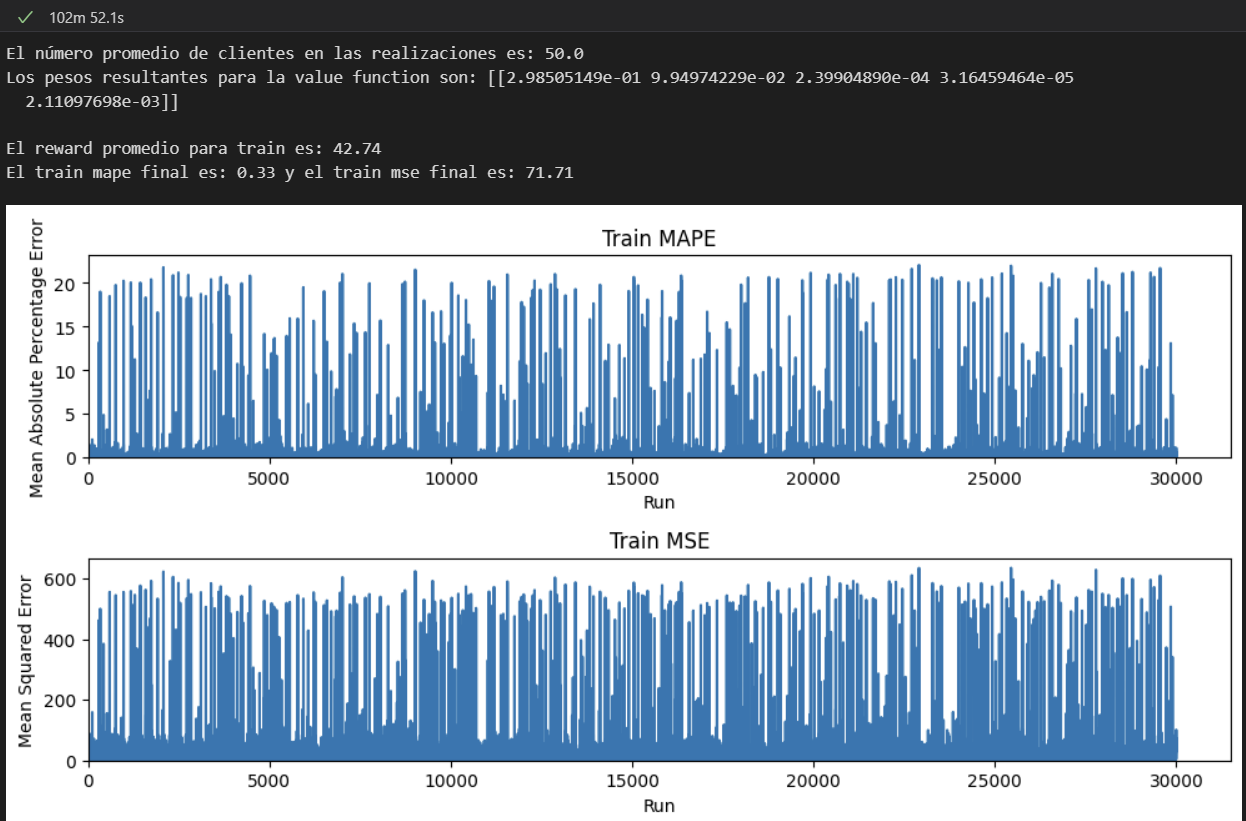
TEST
CI myopic: 50/50
MC rls: 49.23/50 con MAPE:0.2 y MSE:22.1

___
___

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
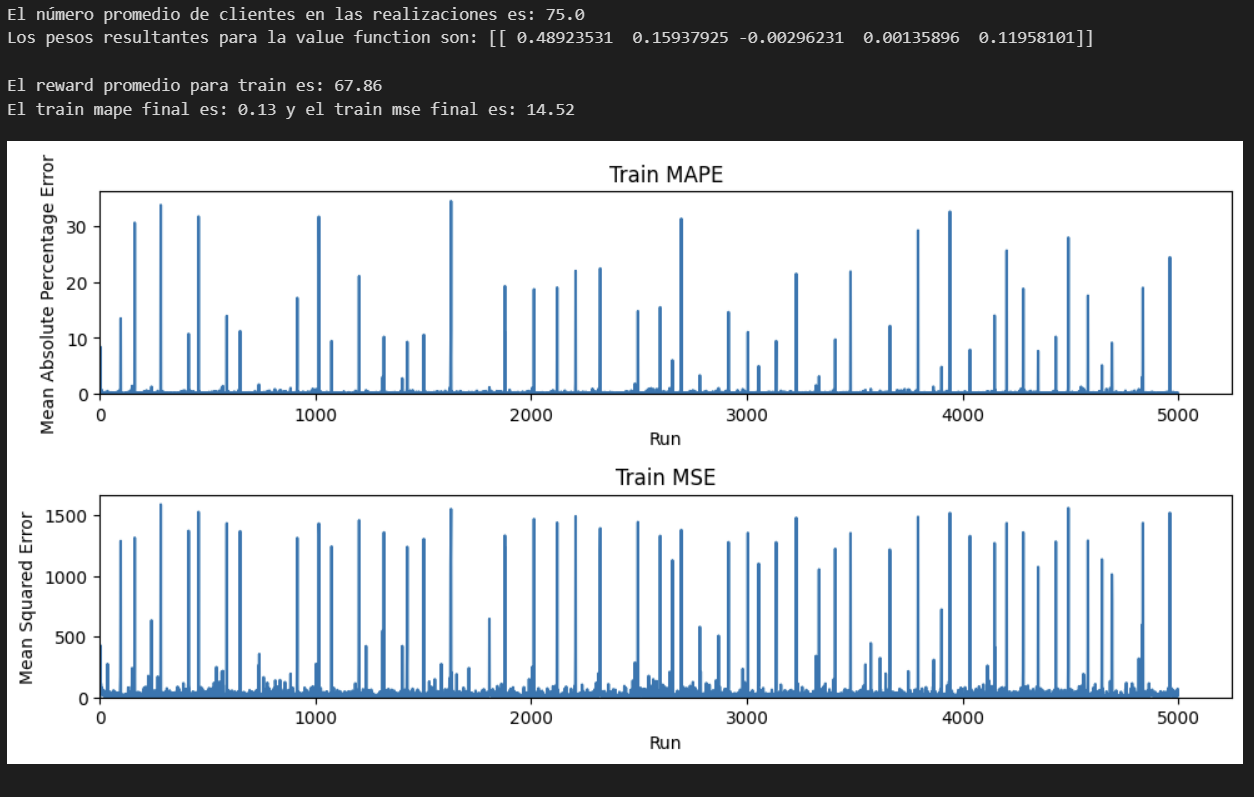
TEST
CI myopic: 75/75
MC rls: 73.67/75 con MAPE:0.16 y MSE:25.35

TRAIN MC rls 10000 realizaciones
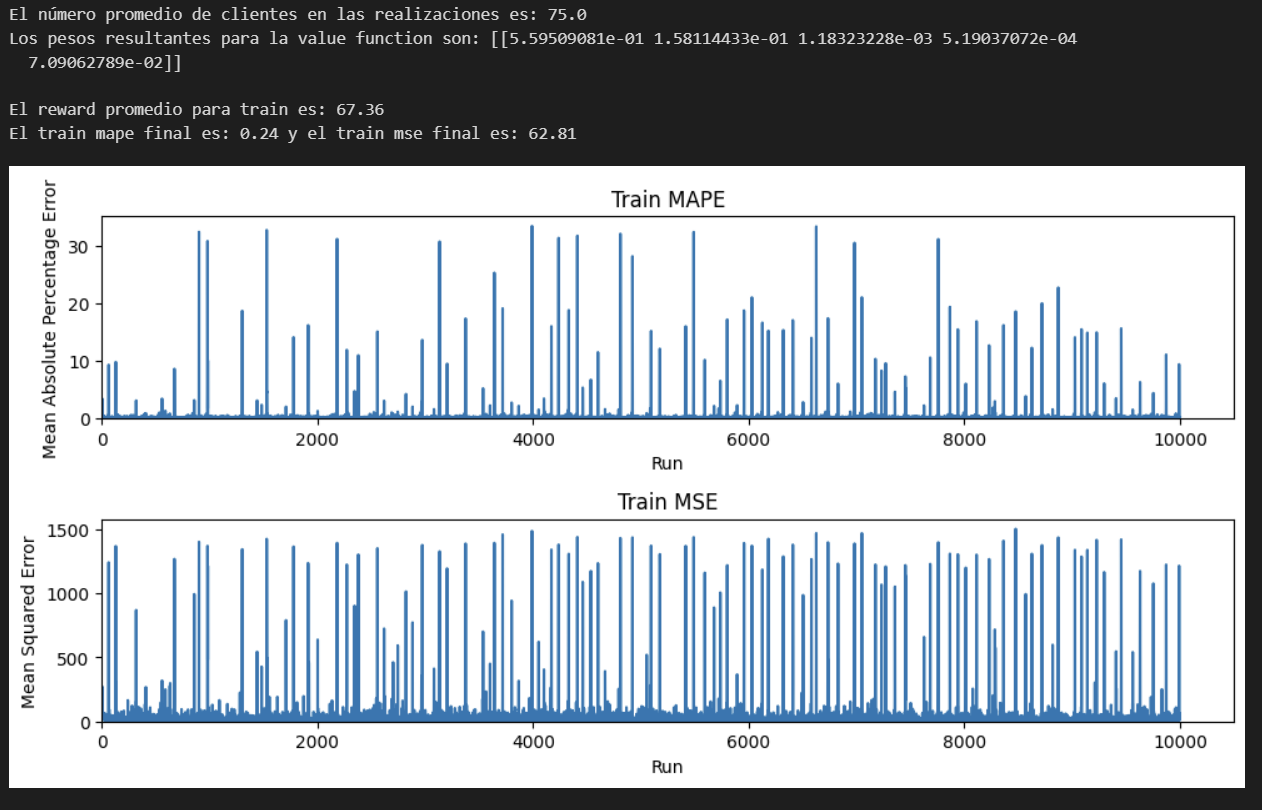
TEST
CI myopic: 75/75
MC rls: 74.55/75 con MAPE:0.17 y MSE:31.53

TRAIN MC rls 20000 realizaciones
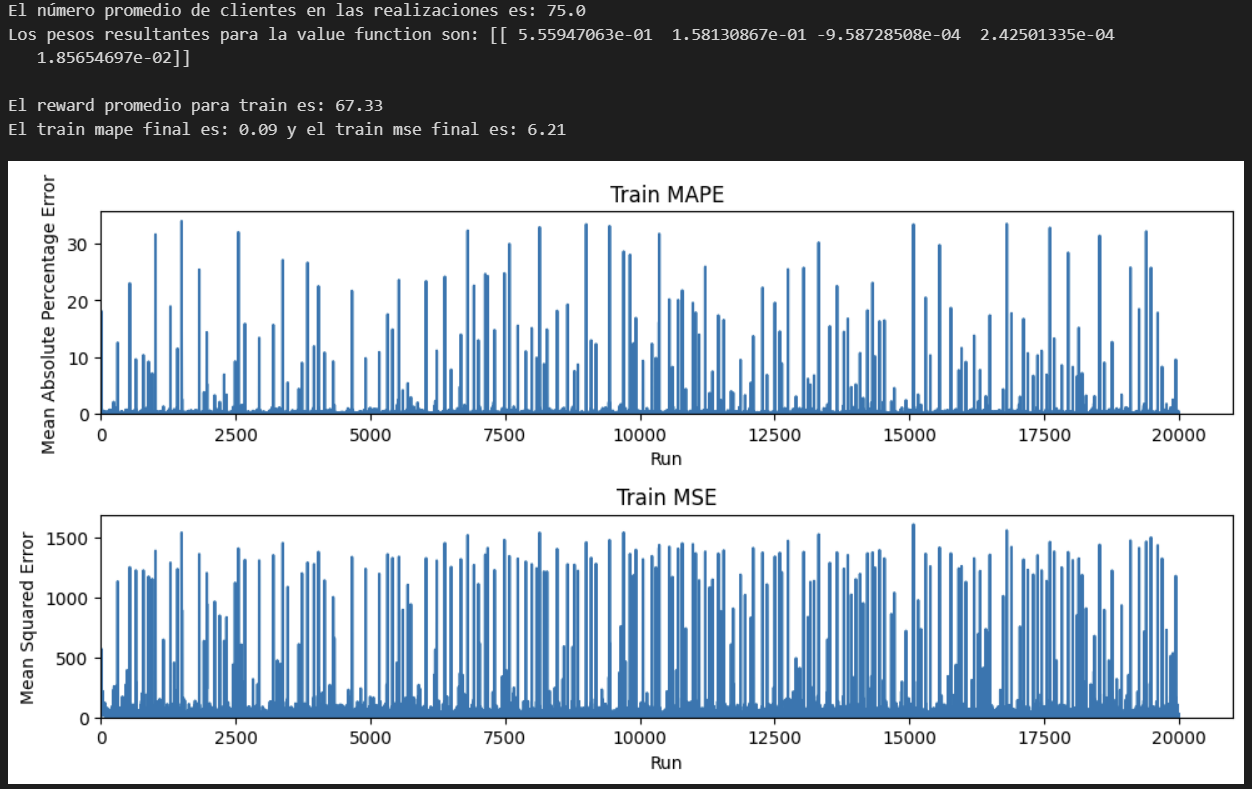
TEST
CI myopic: 75/75
MC rls: 66.19/75 con MAPE:0.19 y MSE:15.52

TRAIN MC rls 30000 realizaciones
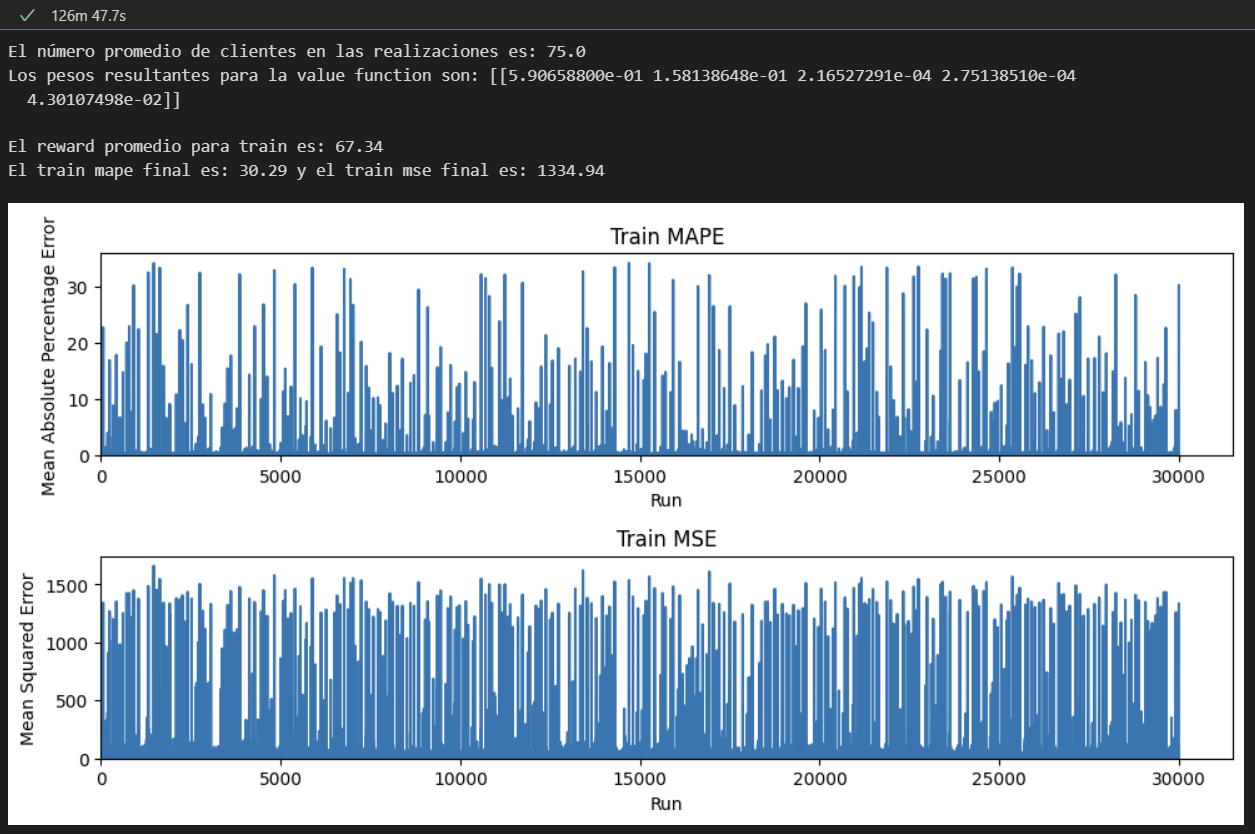
TEST
CI myopic: 75/75
MC rls: 74.63/75 con MAPE:0.16 y MSE:31.41

___
___

Instancia con 6 vehículos y de 150 clientes por vehículo

TRAIN MC rls 10000 realizaciones
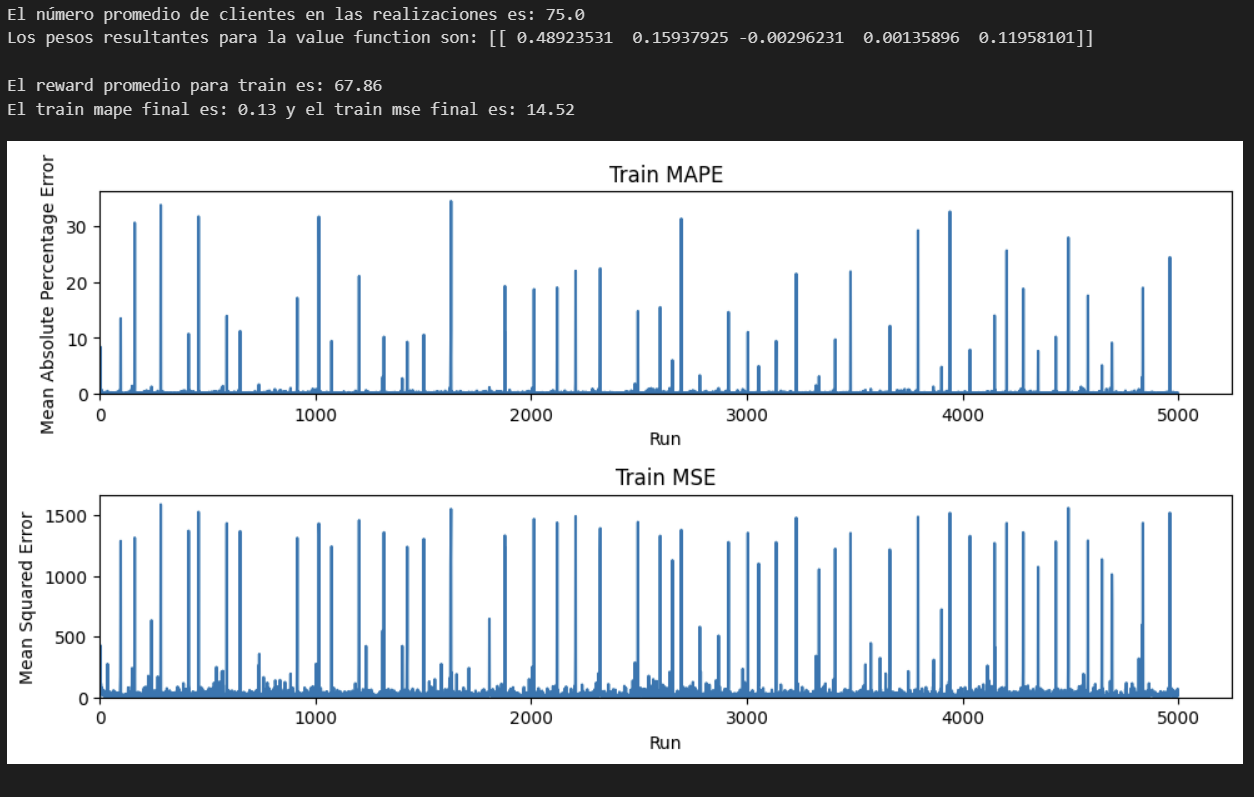
TEST
CI myopic: 150/150
MC rls: 96.94/150 con MAPE:0.18 y MSE:38.56

TRAIN MC rls 20000 realizaciones
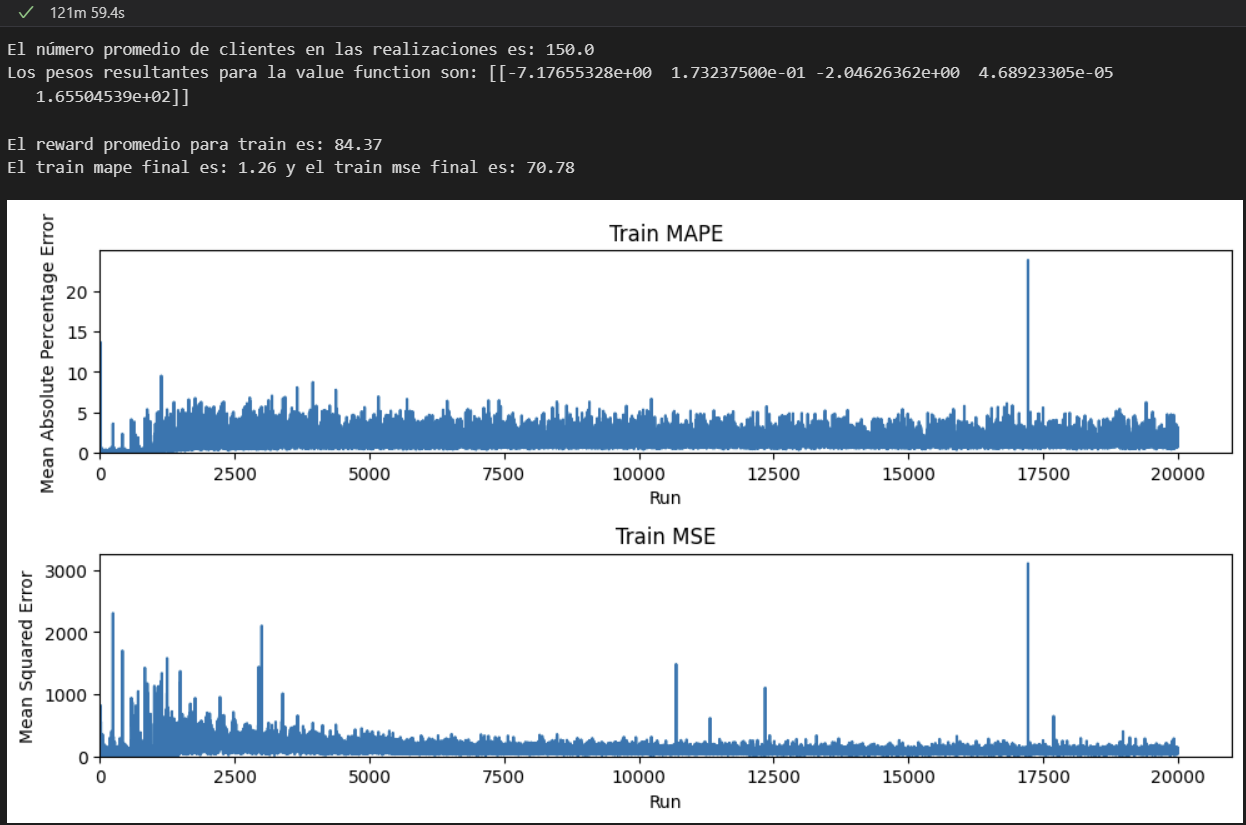
TEST
CI myopic: 150/150
MC rls: 2/150 con MAPE:52.78 y MSE:3255.36

TRAIN MC rls 30000 realizaciones
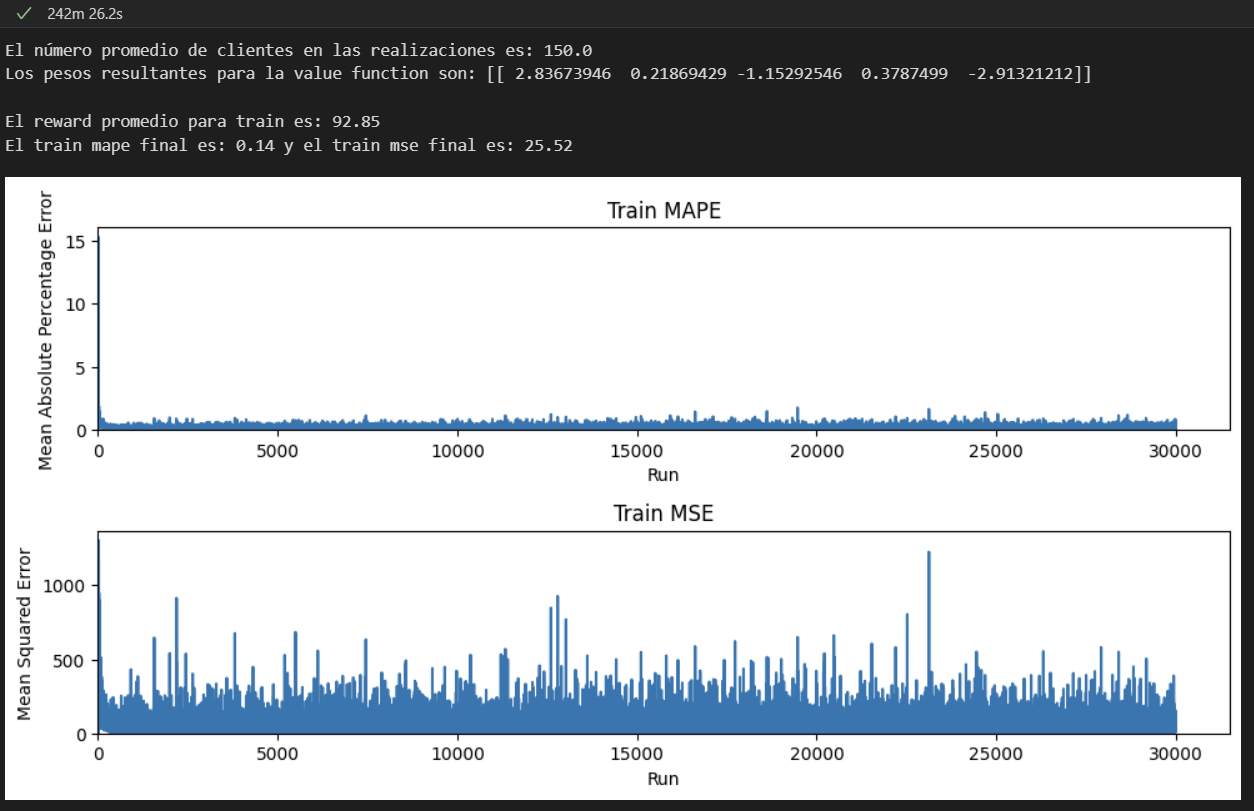
TEST
CI myopic: 150/150
MC rls: 94/150 con MAPE:0.2 y MSE:43.4

TRAIN MC rls 50000 realizaciones
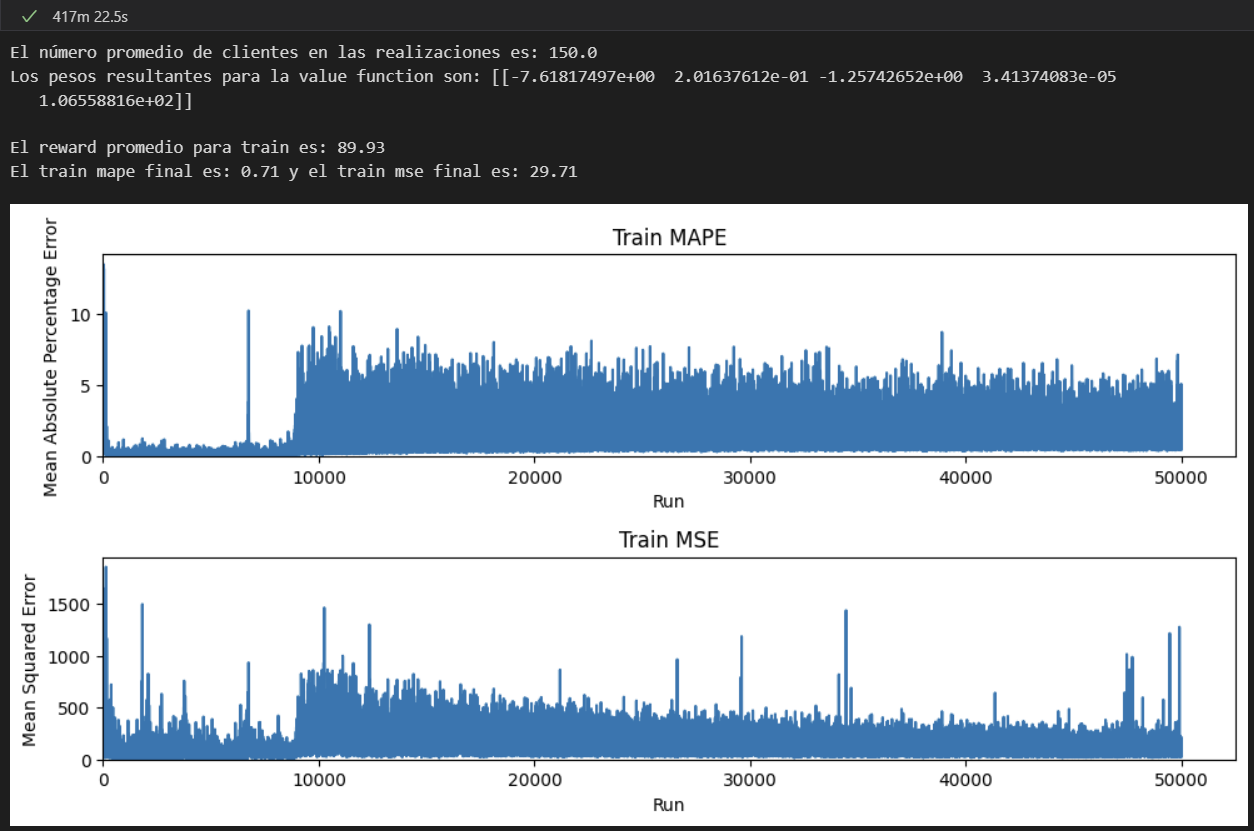
TEST
CI myopic: 150/150
MC rls: 2/150 con MAPE:50.11 y MSE:3138.34

___
___

Instancia con 8 vehículos y de 200 clientes por vehículo

TRAIN MC rls 2000 realizaciones
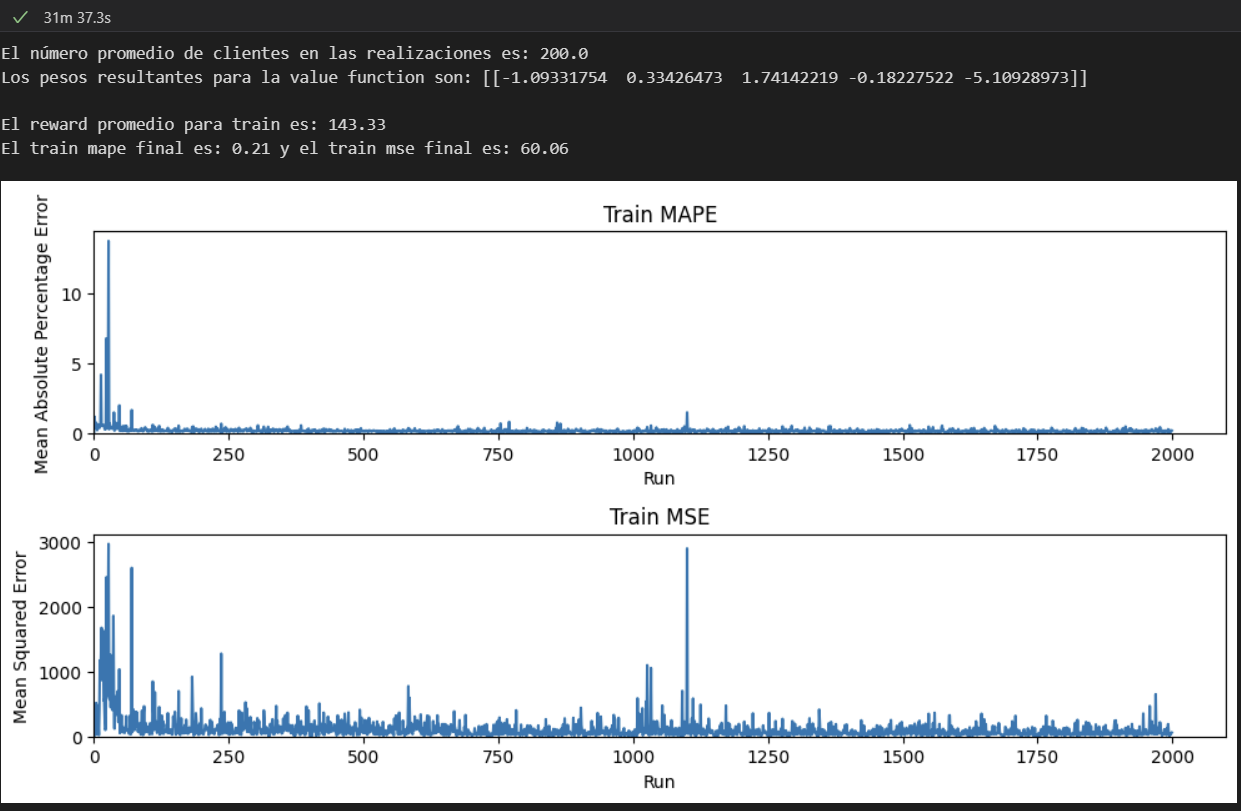
TEST
CI myopic: 200/200
MC rls: 154.73/200 con MAPE:0.17 y MSE:109.69

TRAIN MC rls 5000 realizaciones
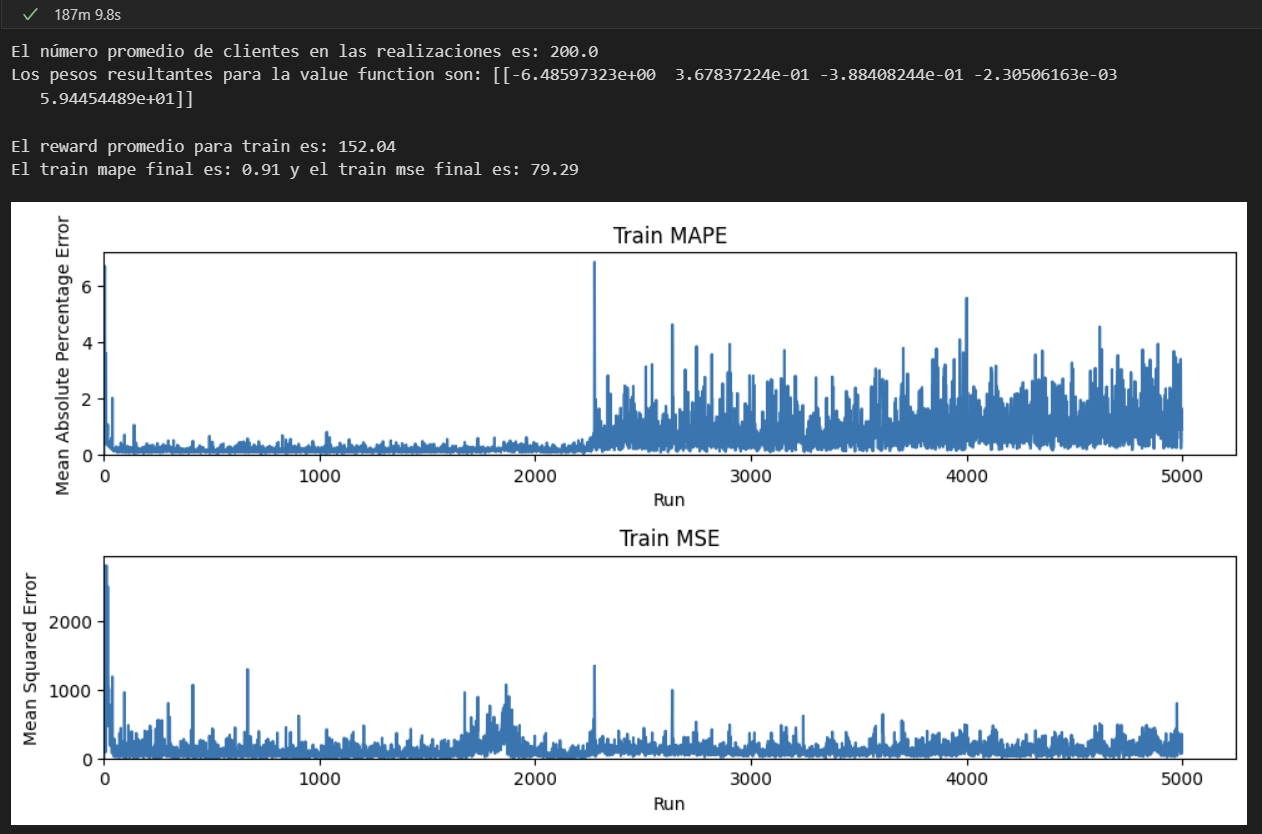
TEST
CI myopic: 200/200
MC rls: 146/200 con MAPE:3.59 y MSE:342.83

TRAIN MC rls 30000 realizaciones
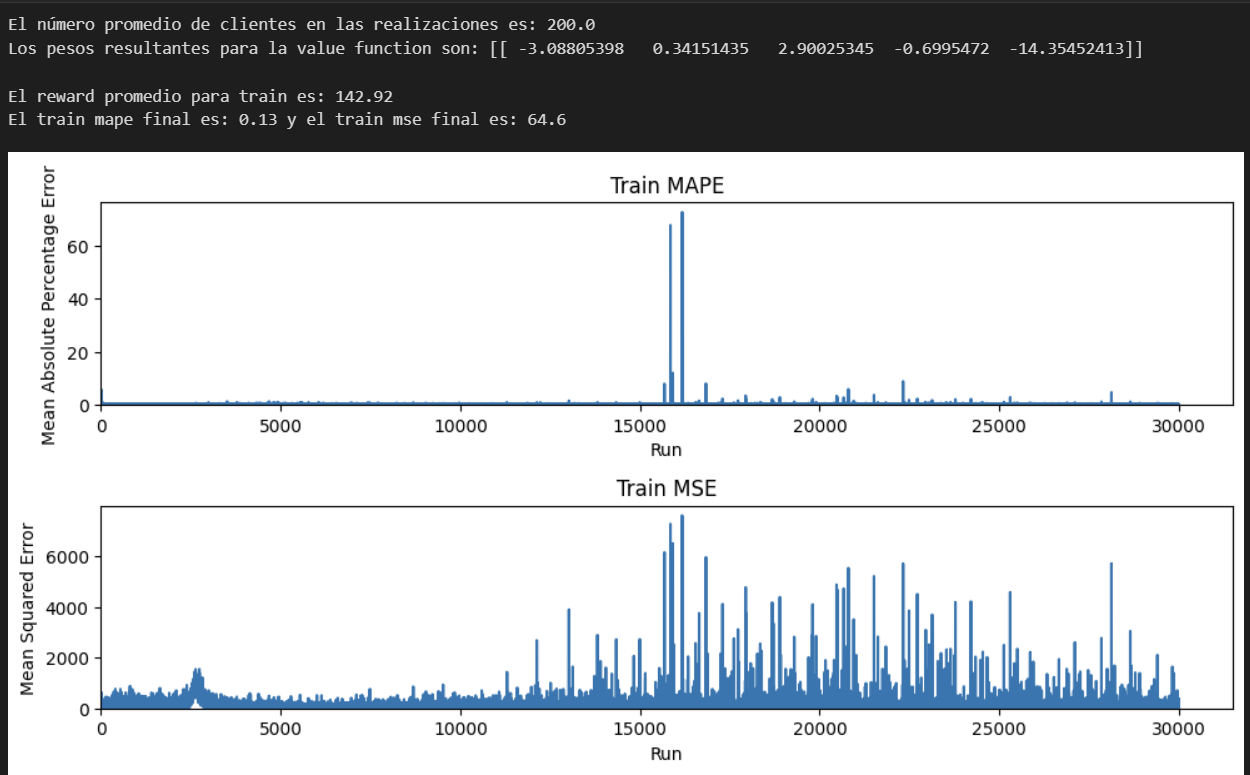
TEST
CI myopic: 200/200
MC rls: 139.43/200 con MAPE:6.81 y MSE:756.72

CON 22 FEATURES (- EL DE PENALTY) (se demoró mucho)

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
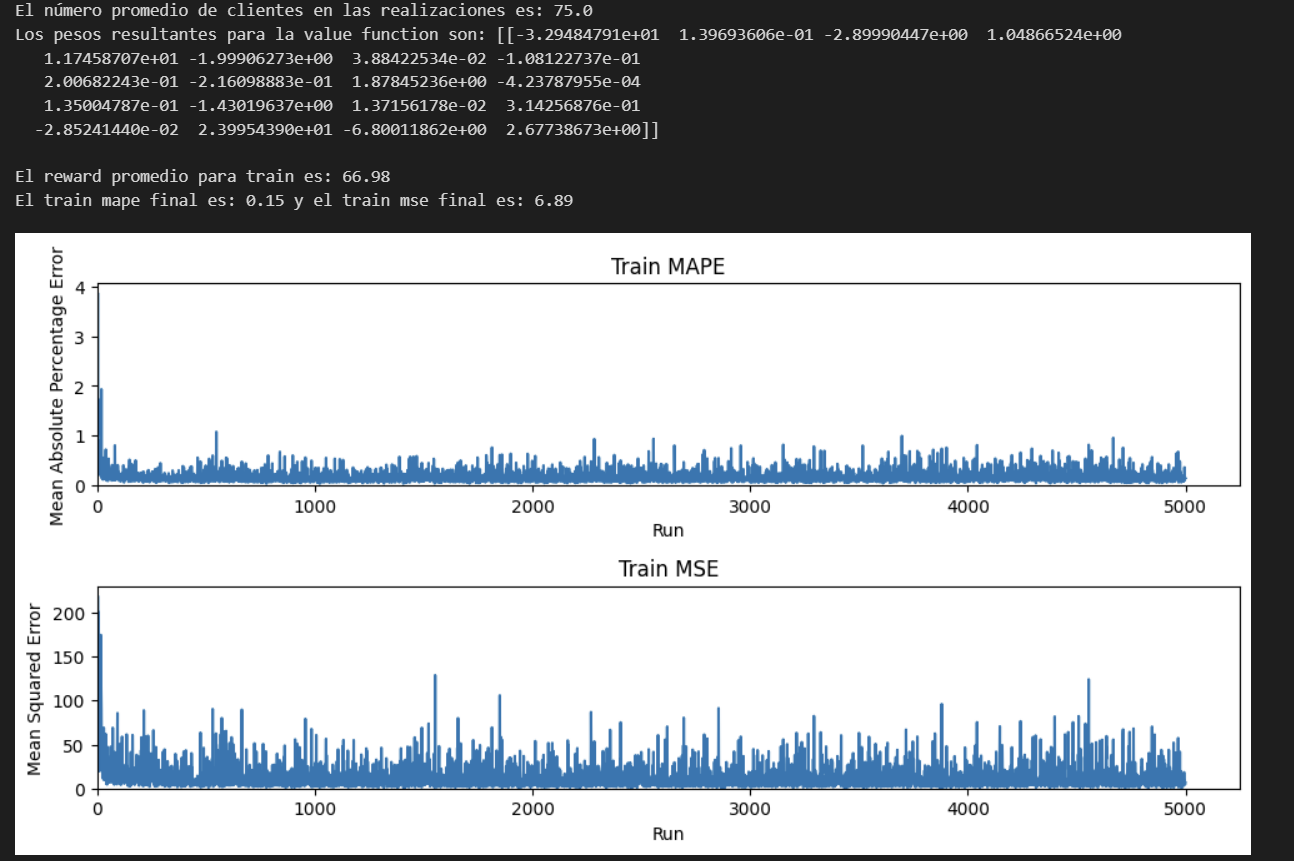

TEST
CI myopic: 75/75
MC rls: 66.26/75 con MAPE:0.21 y MSE:12.12

CON FEATURES ORIGINALES (- LOS DE PENALTY)

Instancia con 3 vehículos y de 75 clientes por vehículo

TRAIN MC rls 5000 realizaciones
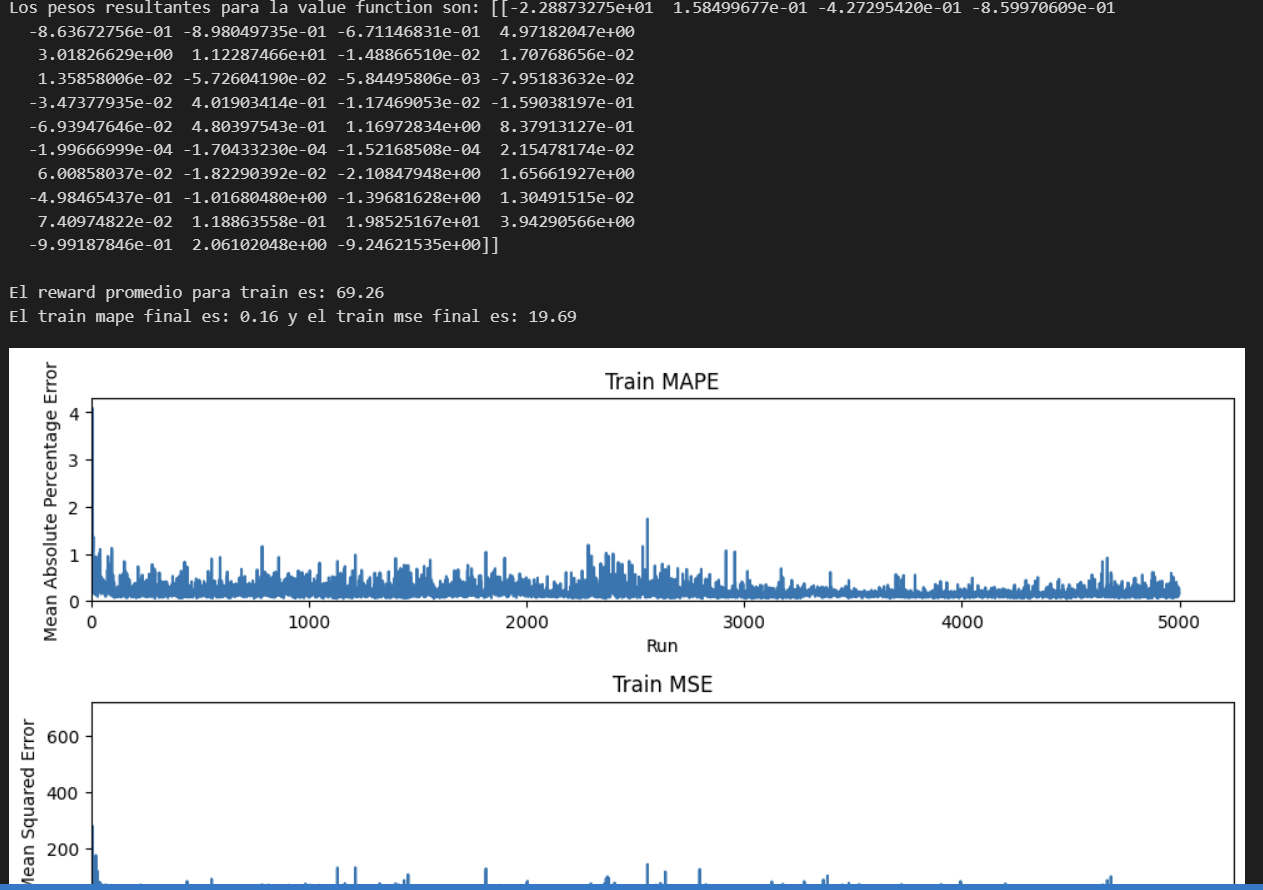

TEST
CI myopic: 75/75
MC rls: 67.66/75 con MAPE:0.28 y MSE:23.46

___
___
___

### A continuación se realizan experimentos con diferentes instancias

In [375]:
# # se crea un objeto Process que contiene el MDP
# process = Process()

# # se crea una lista de instancias
# instances = [
    
# # Instance(A_x=6, 
# #         A_y=6, 
# #         n_vehicles=2, 
# #         n_cust_range=[40, 50], 
# #         dod=0.99, 
# #         t_max=7, 
# #         t_service=7, 
# #         t_window=30, 
# #         cust_categories=[1], 
# #         penalty_factor=15, 
# #         t_delta=5, 
# #         vel_mean=30,
# #         vel_std=0, 
# #         idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
# #         stoc_travel_time=False),

# Instance(A_x=6, 
#         A_y=6, 
#         n_vehicles=3, 
#         n_cust_range=[60, 75], 
#         dod=0.99, 
#         t_max=7, 
#         t_service=5, 
#         t_window=30, 
#         cust_categories=[1], 
#         penalty_factor=15, 
#         t_delta=5, 
#         vel_mean=30,
#         vel_std=0, 
#         idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#         stoc_travel_time=False),

# Instance(A_x=6, 
#         A_y=6, 
#         n_vehicles=6, 
#         n_cust_range=[120, 150], 
#         dod=0.99, 
#         t_max=7, 
#         t_service=5, 
#         t_window=30, 
#         cust_categories=[1], 
#         penalty_factor=15, 
#         t_delta=5, 
#         vel_mean=30,
#         vel_std=0, 
#         idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
#         stoc_travel_time=False)#,

# # instance = Instance(A_x=6, 
# #                     A_y=6, 
# #                     n_vehicles=8, 
# #                     n_cust_range=[160, 200], 
# #                     dod=0.99, 
# #                     t_max=7, 
# #                     t_service=5, 
# #                     t_window=30, 
# #                     cust_categories=[1], 
# #                     penalty_factor=15, 
# #                     t_delta=5, 
# #                     vel_mean=30,
# #                     vel_std=0, 
# #                     idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
# #                     stoc_travel_time=False),

# # Instance(A_x=6,
# #         A_y=6,
# #         n_vehicles=12, 
# #         n_cust_range=[250, 280], 
# #         dod=0.99, 
# #         t_max=7, 
# #         t_service=5, 
# #         t_window=30, 
# #         cust_categories=[1], 
# #         penalty_factor=15, 
# #         t_delta=5, 
# #         vel_mean=30,
# #         vel_std=0, 
# #         idle_points_pos=[(1.5, 1.5), (4.5, 1.5), (3.0, 4.5)], 
# #         stoc_travel_time=False)    
# ]

In [376]:
# results = {}

# for i, instance in enumerate(instances):

#     # se crea un objeto de CI
#     cheapest_insertion = CheapestInsertion(instance, process)

#     # se crean las realizaciones de entrenamiento para el algoritmo
#     cheapest_insertion.simulateTrainRealizations(N=1, simulation_seed=7)
#     # se entrena el modelo con las realizaciones train
#     ci_policy, ci_train_rewards, ci_train_mape, ci_train_mse = cheapest_insertion.train(ridge_penalty=100)
#     # se crean las realizaciones de testeo para el algoritmo
#     cheapest_insertion.simulateTestRealizations(N=1, simulation_seed=5)

#     # se testea la política CI con Ridge entrenada
#     ci_test_rewards_ridge, ci_test_mape, ci_test_mse, ci_fig_test_errors= cheapest_insertion.testLr(ci_policy)
#     # se testea la política CI míope
#     ci_test_rewards = cheapest_insertion.test()
    

#     # se crea un objeto de OPMC
#     monte_carlo = OnPolicyMonteCarlo(instance, process)

#     # se crean las realizaciones de entrenamiento para el algoritmo
#     monte_carlo.simulateTrainRealizations(N=1, simulation_seed=9)
#     # se crea un vector de pesos inicial para los entrenamientos:
#     initial_weights = np.insert(ci_policy.coef_, 0, ci_policy.intercept_)
#     # se crea una instancia de value function
#     mc_initial_value_function = ValueFunction(instance, initial_weights=initial_weights)
#     # se inicializa RLS para la aproximación de la value function
#     mc_initial_value_function.initializeRecursiveLeastSquares(lambd=100)
#     # se entrena el modelo con el algoritmo que utiliza RLS
#     mc_trained_value_function, mc_train_rewards, mc_mape_list, mc_mse_list, mc_fig_train_errors = monte_carlo.train(mc_initial_value_function, epsilon=0.1)

#     # se crean las realizaciones de test para el algoritmo
#     monte_carlo.simulateTestRealizations(N=1, simulation_seed=5)
#     # se testea la política encontrada en train con RLS
#     mc_test_rewards, mc_test_mape, mc_test_mse, mc_fig_test_errors = monte_carlo.test(mc_trained_value_function)

#     # se guarda la cantidad promedio de clientes para las realizaciones de train y test de cada algoritmo
#     ci_mean_train_cust = round(np.mean([len(realization) for realization in cheapest_insertion.train_realizations]), 2)
#     mc_mean_train_cust = round(np.mean([len(realization) for realization in monte_carlo.train_realizations]), 2)
#     ci_mean_test_cust = round(np.mean([len(realization) for realization in cheapest_insertion.test_realizations]), 2)
#     mc_mean_test_cust = round(np.mean([len(realization) for realization in monte_carlo.test_realizations]), 2)

#     results[i] = {'Train':{'CI':{'mean_train_cust':ci_mean_train_cust, 'policy': ci_policy, 'rewards': ci_train_rewards, 'mape': ci_train_mape, 'mse': ci_train_mse},
#                            'MC':{'mean_train_cust':mc_mean_train_cust, 'policy': mc_trained_value_function, 'rewards': mc_train_rewards, 'mape_list': mc_mape_list, 'mse_list': mc_mse_list, 'fig': mc_fig_train_errors}}, 

#                   'Test':{'CI ridge':{'mean_test_cust': ci_mean_test_cust, 'rewards': ci_test_rewards_ridge, 'mape': ci_test_mape, 'mse': ci_test_mse, 'fig': ci_fig_test_errors},
#                           'CI myopic':{'mean_test_cust': ci_mean_test_cust, 'rewards': ci_test_rewards},
#                           'MC':{'mean_test_cust': mc_mean_test_cust, 'rewards': mc_test_rewards, 'mape': mc_test_mape, 'mse': mc_test_mse, 'fig': mc_fig_test_errors}}}

In [377]:
# # se guardan los resultados en un archivo pickle
# with open('Results_3_6_new.pkl', 'wb') as archivo:
#     pickle.dump(results, archivo)

In [378]:
# # se abre el archivo que contiene los resultados de los experimentos 
# with open('Results_3_6_new.pkl', 'rb') as archivo:
#     results = pickle.load(archivo)

In [379]:
# # se muestran los resultados obtenidos
# for i in range(len(results)):

#     print('TRAIN')

#     print('\nCI')
#     print('Cantidad promedio de clientes:', results[i]['Train']['CI']['mean_train_cust'])
#     # print('Policy:', results[i]['Train']['CI']['policy'])
#     print('Reward promedio:', round(np.mean(results[i]['Train']['CI']['rewards']), 2))
#     print('MAPE:', results[i]['Train']['CI']['mape'])
#     print('MSE:', results[i]['Train']['CI']['mse'])

#     print('\nMC')
#     print('Cantidad promedio de clientes:', results[i]['Train']['MC']['mean_train_cust'])
#     # print('Policy:', results[i]['Train']['MC']['policy'])
#     print('Reward promedio:', round(np.mean(results[i]['Train']['MC']['rewards']), 2))
#     print('MAPE:', results[i]['Train']['MC']['mape_list'][-1])
#     print('MSE:', results[i]['Train']['MC']['mse_list'][-1])
#     # print('Errores train por episodio:', results[i]['Train']['MC']['fig'])

#     print('\nTEST')

#     print('\nCI ridge')
#     print('Cantidad promedio de clientes:', results[i]['Test']['CI ridge']['mean_test_cust'])
#     print('EL reward promedio de test es:', round(np.mean(results[i]['Test']['CI ridge']['rewards']), 2))
#     print('MAPE:', results[i]['Test']['CI ridge']['mape'])
#     print('MSE:', results[i]['Test']['CI ridge']['mse'])
#     # print('Distribución de errores', results[i]['Test']['CI ridge']['fig'])

#     print('\nCI myopic')
#     print('Cantidad promedio de clientes:', results[i]['Test']['CI myopic']['mean_test_cust'])
#     print('EL reward promedio de test es:', round(np.mean(results[i]['Test']['CI myopic']['rewards']), 2))

#     print('\nMC')
#     print('Cantidad promedio de clientes:', results[i]['Test']['MC']['mean_test_cust'])
#     print('EL reward promedio de test es:', round(np.mean(results[i]['Test']['MC']['rewards']), 2))
#     print('MAPE:', results[i]['Test']['MC']['mape'])
#     print('MSE:', results[i]['Test']['MC']['mse'])
#     # print('Distribución de errores:', results[i]['Test']['MC']['fig'])

#     print('____\n____\n____\n')